# On particle filters applied to electricity load forecasting

PyMC tuto

https://pymc-devs.github.io/pymc/tutorial.html#fitting-the-model-with-mcmc

http://sdsawtelle.github.io/blog/output/mcmc-in-python-with-pymc.html
    

NC Email:

Voilà quelques pistes que vous pouvez suivre:
* commencer par implémenter un bootstrap filter pour le modèle proposé, et des valeurs des paramètres choisis à la main ﴾en fonction des valeurs reportées dans l'article par exemple﴿ et des données que vous pouvez simuler. Déterminer à quel point l'algorithme marche bien:
+ graphe de l'ESS en fonction du temps; voir si effectivement certains outliers font fortement chuter l'ESS. Essayer la méthode proposée pour gérer ses outliers.
+ intervalles de confiance pour l'estimation de E[X_t|Y_{0:t}], basé sur plusieurs exécutions, par exemple.

Deuxième étape: estimation des paramètres. Vous pouvez essayer une des trois approches suivantes, triées par ordre de difficulté:
1. maximisation de la vraisemblance ﴾estimée par votre filtre particulaire pour un theta donné﴿, en utilisant une méthode de maximisation pour fonction bruitée ﴾par ex Robbins‐Monroe﴿.
2. PMMH, voir le prochain cours. Principale difficulté: l'algorithme peut prendre du temps, et ne pas être très facile à calibrer, mais je vais en parler en cours.
3. Particle Gibbs: c'est peut‐être un peu compliqué pour ce modèle, mais si vous arrivez, gros bonus!

In [1]:
import pandas as pd
import numpy as np
import numpy.random as npr
import matplotlib as mtp
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import truncnorm
import scipy.stats as stats
from scipy.stats import invgamma
from scipy import ndimage
import math

### Parameters

In [43]:
M=10**4 #number of particles
n_pred=349  #number of predictions
N_daytype=8  #number of day types

In [3]:
#Define functions for filtering and regularization of weigths for Particle Fitler algo 3.10

def ESS(w,n):
    return(1/(sum(w[n,:])**2))

def resid_resample(x_h,w_h):  #algorithm 3.5 - Residual Multinomial Sampling
    #R=sum(np.floor(M*w_h))  #number of (normalized) weights over 1/M
    R=len(w_h[w_h>1/M])
    print("R=",R)
    z=np.zeros(M)
    z[:R]=x_h[w_h>1/M]  #Copy the R particles having weight >1/M
    w_=np.ones(M)
    for j in range(M):
        w_[j]=(M*w_h[j]-np.floor(M*w_h[j]))/(M-R)
    print("w_:",w_)
    z[R:]=np.random.multinomial(1,w_[R:],1)*w_[R:]
    w=np.ones(M)*(1/M)
    return z, w

def regul(x,w):  #algorithm 3.6
    eps=sp.ndimage.filters.gaussian_filter(x,sigma=1)  #assume gaussian kernel
    h=0.2 #bandwidth
    z=x+h*(np.cov(x)**0.5)*eps
    return(z)

### Load temperatures data 2015-2016

In [4]:
df_temp=pd.read_csv('data/temp_1516.csv',sep=',')
df_temp=df_temp.drop(df_temp.columns[0],axis=1)
df_temp=df_temp.sort_values(by='date')
df_temp.head()

,date,hour,t
0,2015-01-01,00:00,5.057414
1,2015-01-01,03:00,4.609138
2,2015-01-01,06:00,4.729828
3,2015-01-01,09:00,6.052241
4,2015-01-01,12:00,9.347069


In [5]:
#temperatures every day at 3pm
temp_day=df_temp[df_temp.hour=="15:00"]
temp_day.head()
#Array vector of temperatures for each day of the year
T_h=list(temp_day.t)

### Load electricity data

In [30]:
mypath="data/"
df=pd.read_csv(mypath+"cdc_conso_daytypes.csv",sep=",",encoding='latin-1')
df=df.drop(["daytype"+str(i) for i in range(0,9)],axis=1)
df=df.drop(df.columns[0],axis=1)
df.index=range(0,len(df))
df=df.sort_values(by=['Date'])
df['Date - Heure']=pd.to_datetime(df['Date - Heure'])
df.sort_values(by=["Date - Heure"])
#truncate to the data from 2015
df=df[(df.Date >='2015-01-01')]
df.head()

,Date - Heure,Date,Heure,Consommation (MW),Qualite donnee,daytype
166957,2015-01-01 03:30:00,2015-01-01,04:30,64838,DÃ©finitive,6
153294,2015-01-01 18:30:00,2015-01-01,19:30,72562,DÃ©finitive,6
153293,2015-01-01 18:00:00,2015-01-01,19:00,71766,DÃ©finitive,6
152017,2015-01-01 01:00:00,2015-01-01,02:00,71134,DÃ©finitive,6
152018,2015-01-01 04:30:00,2015-01-01,05:30,64379,DÃ©finitive,6


### Set variables of electricity demand

In [31]:
from datetime import date
df['Consommation']=df['Consommation (MW)']   #leave it in MW
#For prediction, every day at 3pm
consumption_day_ahead = list(df[df['Heure']=='15:00']['Consommation'])
#for initialization
consumption = list(df[df['Heure']=='15:00']['Consommation'][:30])

## Implementation of Algorithm 3.10

## At time n=0:

### 1.Definition of MCMC initial model at n=0 - sample $X_0^{j} \sim \mu(x_0)$

### Option A: Set values by hand

### Option C: MCMC using MHA or Gibbs (TBA)

#### Freeze parameters from Zak's simulation in gibbs-parameters_init_v1

In [32]:
N_daytype=9
k_day=npr.dirichlet(np.ones(N_daytype),1)
len_init=15

In [33]:
#Load pickle file
import pickle
output_file ='data/parameters_init_20180110-102854.pkl'
pkl_file = open(output_file, 'rb')
parameters_init = pickle.load(pkl_file)
parameters_init["x_init"][:20]

array([  1.47891903e+63,   7.69395809e+04,   6.65664387e+04,
         6.81207363e+04,   7.14502802e+04,   5.07239317e+04,
         6.87925901e+04,   6.79254776e+04,   6.64789388e+04,
         6.69291468e+04,   7.02870564e+04,   6.72162235e+04,
         6.13931229e+04,   6.70012333e+04,   6.97843307e+04,
         6.89930685e+04,   6.82153628e+04,   6.36456017e+04,
         7.50874631e+04,   7.18940313e+04])

In [10]:
parameters_init

{'g_heat_init': array([ -9.99946914e+27,  -5.42998824e+02,  -1.20368741e+04, ...,
         -1.29732429e+04,  -1.61914297e+04,  -1.74323565e+04]),
 'kappa': array([ 0.11111111,  0.11111111,  0.11111111,  0.11111111,  0.11111111,
         0.11111111,  0.11111111,  0.11111111,  0.11111111]),
 's_init': array([  1.33102713e+64,   6.72597280e+05,   1.58876634e+05, ...,
          3.91430788e-08,   3.82795043e-08,   9.78069125e-08]),
 'sigma2': 27000000,
 'sigma_g_init': 1.7189511907681099e+27,
 'sigma_s_init': 6.3306065683604752e-08,
 'u_h': 13,
 'w_init': array([ 0.        ,  0.25286083,  0.94446275, ...,  0.01100679,
         0.88847701,  0.8894034 ]),
 'x_init': array([  1.47891903e+63,   7.69395809e+04,   6.65664387e+04, ...,
          5.27185416e+04,   6.57960826e+04,   7.08387576e+04])}

In [34]:
s_init=parameters_init['s_init']
g_heat_init=parameters_init['g_heat_init']
sigma_s_init=parameters_init['sigma_s_init']
sigma_g_init=parameters_init['sigma_g_init']
x_init=parameters_init['x_init']
sigma2=parameters_init['sigma2']
u_h=parameters_init['u_h']
kappa=parameters_init['kappa']
w_init=parameters_init['w_init']

In [35]:
sigma2=np.ones(M)*3*10**7
sigma_g_init=np.ones(M)*10**4
sigma_s_init=np.ones(M)*10**4
kappa=np.ones(M)*1/9

In [36]:
w_init[0]=np.median(w_init)
x_init[0]=np.median(x_init)
g_heat_init[0]=np.median(g_heat_init)
s_init[0]=np.median(s_init)

### Part 2: regularize weights and x if necessary

In [37]:
#STEP 2 OF PARTICLE FILTER
def resample(x_pred,w_prev,len_init,n,sigma_s,sigma_g,g_h,s,sigma):   
    #compute y_n
    delta_cons_gaus=-np.square(consumption_day_ahead[len_init+n]-x_pred)/(2*sigma**2)
    y_n=np.exp(delta_cons_gaus)
    #compute new weights
    if n>0:
        w_=w_prev*y_n
    else:
        w_=w_prev
    #likelihood of y_n
    lh_y_n=np.sum(delta_cons_gaus)
    #normalize weights
    w_h=w_/sum(w_)
    #calculate ESS
    ESS=1/sum(np.square(w_h))
    x =np.zeros(M)
    w =np.zeros(M)
    print("ESS of normalized weights=",round(ESS,6))
    if ESS <0.001*M: #reset the weights, keep x predicted as such
        print("ESS <0.001*M")
        x=x_pred
        if n==0:
            w=np.ones(M)*(1/M)
        w=w_prev
    elif (ESS>=0.001*M and ESS<0.5*M):  #reset all the weights, add some noise to a fraction of the x's
        print("ESS>=0.001*M and ESS_0<0.5*M")
        #x_temp,w_temp=resid_resample(x_pred,w_h)
        #x=regul(x_temp,w_temp)
        #w=w_temp
        x,w,sigma_s,sigma_g,g_h,s=resample_multinomial(x_pred,w_h,sigma_s,sigma_g,g_h,s)
    elif ESS>=0.5*M:  #No degeneracy
        print("ESS>=0.5*M")
        x=x_pred
        w=w_h
    else:
        print("ESS critically low")
        x=x_pred
        if n==0:
            w=np.ones(M)*(1/M)
        w=w_prev
            
    print("new ESS=",round(1/sum(np.square(w)),6))
    return x,w,ESS,lh_y_n,sigma_s,sigma_g,g_h,s

In [38]:
def resample_multinomial(x_temp,w_temp,sigma_s,sigma_g,g_h,s):
    multinomial = np.random.multinomial(1,w_temp,M)
    new_x = np.zeros(M)
    new_s = np.zeros(M)
    new_g_heat = np.zeros(M)
    new_sigma_s = np.zeros(M)
    new_sigma_g = np.zeros(M)
    for i in range(M):
        new_x[i]=x_temp[np.argmax(multinomial[i,])]
        new_s[i]=s[np.argmax(multinomial[i,])]
        new_g_heat[i]=g_h[np.argmax(multinomial[i,])]
        new_sigma_s[i]=sigma_s[np.argmax(multinomial[i,])]
        new_sigma_g[i]=sigma_g[np.argmax(multinomial[i,])]
    new_w=(1/M)*np.ones(M)   
    return new_x,new_w,new_sigma_s,new_sigma_g,new_g_heat,new_s

In [39]:
#initialize matrix of x_heat, x_season
ESS=np.array(np.ones(n_pred+1))
x =np.zeros([n_pred+1,M])
w =np.zeros([n_pred+1,M])
lh_y_n =np.zeros(n_pred+1)
x_season =np.zeros([n_pred+1,M]) 
x_heat =np.zeros([n_pred+1,M])

x[0,:],w[0,:],ESS[0],lh_y,sigma_s_init,sigma_g_init,g_heat_init,s_init=resample(x_init,w_init,15,0,sigma_s_init,
                                                                                sigma_g_init,
                                                                                g_heat_init,s_init,sigma2**0.5)

ESS of normalized weights= 8651.09274
ESS>=0.5*M
new ESS= 8651.09274


## Prediction and Filtering at time n>0

### 1. Sample $x^j_n \mid X^j_{n-1} $ for all j=1...M particles

In [40]:
def x_season(day_type,k_day,s_prev,sigma_s_prev):
    nu=truncnorm.rvs(a = (-sigma_s_prev-0) / sigma_g_init , b = np.inf, loc= 0, scale = sigma_g_init, size=M)
    sigma_s=sigma_s_prev+nu
    err=truncnorm.rvs(a = -s_prev / sigma_s , b = np.inf, loc= 0, scale = sigma_s, size=M)
    s=s_prev+err
    x_s=s*k_day[day_type]
    return x_s, s, sigma_s

def x_heat(g_h_prev,day,sigma_g_prev):
    nu=truncnorm.rvs(a = -sigma_g_prev / sigma_g_init , b = np.inf, loc= 0, scale = sigma_g_init, size=M)
    sigma_g=sigma_g_prev+nu
    err=truncnorm.rvs(a = -np.inf , b =(-g_h_prev-0) / sigma_g, loc= 0, scale = sigma_g, size=M)
    g_h=g_h_prev+err
    if(u_h-T_h[day]<0):
        print("No heating effect")
    x_h=g_h*(T_h[day]-u_h)*max(np.sign(u_h-T_h[day]),0)
    return x_h, g_h, sigma_g

In [41]:
daytype=np.array(df.daytype)

In [42]:
#Initialize parameters
def particle_filter(len_init,len_filtering,s,g_h,sigma_s,sigma_g,sigma,lh_y):
    lh_y_n=np.zeros(len_filtering)
    for n in range(1,len_filtering):
        print("n=",n)
        #prediction X[n] one day ahead, hourly forecast
        x_s=x_season(int(daytype[len_init+n]),kappa,s,sigma_s)
        x_h=x_heat(g_h,n+len_init,sigma_g)
        x_pred=x_s[0]+x_h[0]
        print("number of negative values:",len(x_pred[x_pred<0]))
        print("x_pred_mean =","{:.2e}".format(np.mean(x_pred)),
              "real consumption=","{:.2e}".format(consumption_day_ahead[n]))
        print("x_pred min=","{:.2e}".format(np.min(x_pred)),"x_pred max","{:.2e}".format(np.max(x_pred)))
        #take new values of parameters to feed x_season and x_heat in the next step
        s, sigma_s=x_s[1:]
        g_h, sigma_g=x_h[1:]
        #regularization
        x[n,:],w[n,:],ESS[n],lh_y_n[n],sigma_s,sigma_g,g_h,s=resample(x_pred,w[n-1,:],len_init,n,sigma_s,sigma_g,g_h,s,sigma)
        print("------------------------")
    return lh_y_n

In [44]:
log_lh_init=particle_filter(len_init,n_pred,s_init,g_heat_init,sigma_s_init,sigma_g_init,sigma2**0.5,lh_y_n)

n= 1
number of negative values: 0
x_pred_mean = 3.84e+04 real consumption= 6.86e+04
x_pred min= 9.01e+01 x_pred max 2.33e+05
ESS of normalized weights= 997.608246
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 2
number of negative values: 0
x_pred_mean = 8.48e+04 real consumption= 6.41e+04
x_pred min= 2.03e+02 x_pred max 4.06e+05
ESS of normalized weights= 2030.898749
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 3
number of negative values: 0
x_pred_mean = 9.30e+04 real consumption= 5.74e+04
x_pred min= 1.13e+03 x_pred max 4.71e+05
ESS of normalized weights= 2436.359249
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 4
number of negative values: 0
x_pred_mean = 9.59e+04 real consumption= 7.31e+04
x_pred min= 1.92e+02 x_pred max 4.82e+05
ESS of normalized weights= 2425.47807
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 5
number of negative values: 0
x_pred_mean = 8.07e+04 real 

KeyboardInterrupt: 

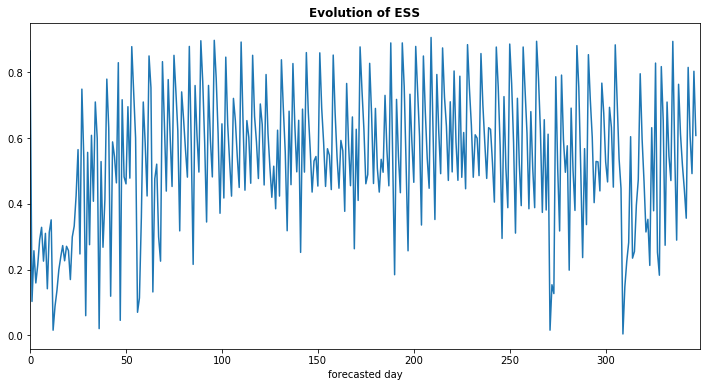

In [28]:
fig=plt.figure(figsize=(12,6))
plt.plot(range(n_pred-1),ESS[:n_pred-1]/M)
plt.title("Evolution of ESS",fontweight='bold')
plt.xlabel('forecasted day')
plt.xlim(0,n_pred)
plt.show()

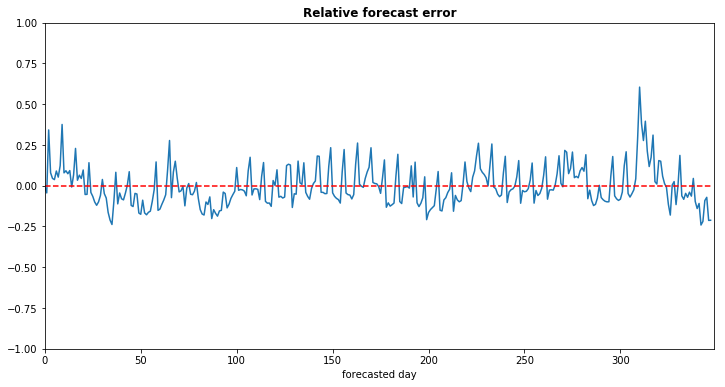

In [27]:
fig=plt.figure(figsize=(12,6))
mean_x_pred=np.zeros(n_pred-1)
for i in range(n_pred-1):
    mean_x_pred[i]=np.median(x[i,:])
plt.plot(range(n_pred-1),(mean_x_pred[:n_pred-1]-consumption_day_ahead[:n_pred-1])/consumption_day_ahead[:n_pred-1])
plt.plot(range(n_pred-1),np.zeros(n_pred-1),color='red',linestyle='--')
plt.ylim(-1,1)
plt.xlim(0,n_pred)
plt.xlabel('forecasted day')
plt.title("Relative forecast error",fontweight='bold')
plt.show()

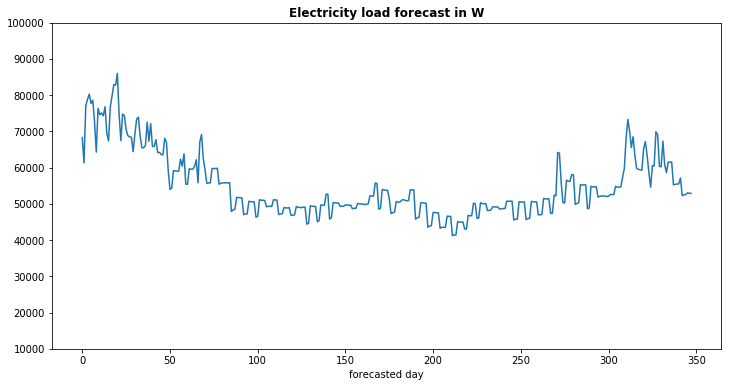

In [26]:
fig=plt.figure(figsize=(12,6))
plt.plot(range(n_pred-1),mean_x_pred[:n_pred-1])
plt.xlabel('forecasted day')
plt.ylim(10**4,10**5)
plt.title("Electricity load forecast in W",fontweight='bold')
plt.show()

Goal: re-estimate the one-dimensional parameters ($\sigma_g,\sigma_s,\mu_h,\kappa,\sigma$)<br>
Proposal distribution for these parameters: truncated gaussian random walk<br>
We set kappa constant at 1/8



## PMMH

#### Initialization of parameters

In [746]:
u_h_current=13
sigma_current=10**4
sigma_g_current=10**4
sigma_s_current=10**4

In [747]:
len_filter_pmmh=349
len_iter_mha=100
accept_log_proba=np.zeros(len_filter_pmmh)
accept_rate=0
log_lh_init=np.zeros(len_filter_pmmh)
lh_y_prop=np.zeros(len_filter_pmmh)

In [758]:
#store the accepted value in lists
u_h_list=[]
sigma_list=[]
sigma_g_list=[]
sigma_s_list=[]

#### Initialization of hyperparameters

In [748]:
#standard deviation of normal/trunc normal proposals on parameters
std_hyp_sigma_g,std_hyp_sigma_s,std_hyp_sigma=np.ones(3)*5*10**3
std_hyp_u=1

In [749]:
#joint prior density of parameters
def log_joint_prior(u_h,sigma,sigma_g,sigma_s):
    res=0
    res=(-(u_h-14)**2)/2
    res=res+(-0.01-1)*np.log(sigma**2) - (0.01/sigma**2)
    res=res+(-0.01-1)*np.log(sigma_g**2) - (0.01/sigma_g**2)
    res=res+(-0.01-1)*np.log(sigma_s**2) - (0.01/sigma_s**2)
    return res

In [750]:
#joint log prior density initialize
log_prior_init=log_joint_prior(u_h_current,sigma_current,sigma_g_current,sigma_s_current)
print(log_prior_init)
#initial parameters otbained from Gibbs. These initialized parameters will not change through iterations

-56.3146626545


#### Run initial particle filter and get the log likelihood

In [751]:
log_lh_init=particle_filter(len_init,len_filter_pmmh,s_init,g_heat_init,sigma_s_current,sigma_g_current,sigma_current,lh_y_n)

n= 1
number of negative values: 0
x_pred_mean = 9.43e+04 real consumption= 5.75e+04
x_pred min= 2.31e+02 x_pred max 5.29e+05
ESS of normalized weights= 3059.691655
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 2
number of negative values: 0
x_pred_mean = 1.31e+05 real consumption= 6.65e+04
x_pred min= 1.21e+03 x_pred max 8.68e+05
ESS of normalized weights= 1988.516811
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 3
number of negative values: 0
x_pred_mean = 1.47e+05 real consumption= 6.92e+04
x_pred min= 3.04e+03 x_pred max 7.75e+05
ESS of normalized weights= 1807.854253
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 4
number of negative values: 0
x_pred_mean = 1.83e+05 real consumption= 6.97e+04
x_pred min= 6.66e+02 x_pred max 8.12e+05
ESS of normalized weights= 1053.015292
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 5
number of negative values: 0
x_pred_mean = 1.89e+05 rea

x_pred_mean = 3.66e+04 real consumption= 5.50e+04
x_pred min= 4.77e+01 x_pred max 7.88e+04
ESS of normalized weights= 1562.372326
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 37
number of negative values: 0
x_pred_mean = 4.52e+04 real consumption= 6.69e+04
x_pred min= 1.55e+04 x_pred max 8.43e+04
ESS of normalized weights= 3620.104564
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 38
number of negative values: 0
x_pred_mean = 6.57e+04 real consumption= 7.02e+04
x_pred min= 2.52e+04 x_pred max 1.22e+05
ESS of normalized weights= 7624.635169
ESS>=0.5*M
new ESS= 7624.635169
------------------------
n= 39
number of negative values: 0
x_pred_mean = 7.16e+04 real consumption= 7.12e+04
x_pred min= 2.41e+04 x_pred max 1.48e+05
ESS of normalized weights= 5351.744945
ESS>=0.5*M
new ESS= 5351.744945
------------------------
n= 40
number of negative values: 0
x_pred_mean = 1.74e+05 real consumption= 7.03e+04
x_pred min= 1.68e+04 x_pred max 6.

new ESS= 10000.0
------------------------
n= 71
No heating effect
number of negative values: 0
x_pred_mean = 8.45e+04 real consumption= 5.34e+04
x_pred min= 5.40e+04 x_pred max 1.17e+05
ESS of normalized weights= 1225.561984
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 72
No heating effect
number of negative values: 0
x_pred_mean = 8.08e+04 real consumption= 6.39e+04
x_pred min= 5.14e+04 x_pred max 1.09e+05
ESS of normalized weights= 4836.654468
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 73
No heating effect
number of negative values: 0
x_pred_mean = 7.82e+04 real consumption= 6.24e+04
x_pred min= 3.82e+04 x_pred max 1.06e+05
ESS of normalized weights= 5118.684436
ESS>=0.5*M
new ESS= 5118.684436
------------------------
n= 74
No heating effect
number of negative values: 0
x_pred_mean = 7.81e+04 real consumption= 7.02e+04
x_pred min= 2.22e+04 x_pred max 1.24e+05
ESS of normalized weights= 3235.330369
ESS>=0.001*M and ESS_0<0.5*

new ESS= 10000.0
------------------------
n= 105
No heating effect
number of negative values: 0
x_pred_mean = 7.37e+04 real consumption= 4.74e+04
x_pred min= 5.52e+04 x_pred max 9.52e+04
ESS of normalized weights= 3930.305809
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 106
No heating effect
number of negative values: 0
x_pred_mean = 7.46e+04 real consumption= 4.55e+04
x_pred min= 5.10e+04 x_pred max 9.60e+04
ESS of normalized weights= 6994.296945
ESS>=0.5*M
new ESS= 6994.296945
------------------------
n= 107
No heating effect
number of negative values: 0
x_pred_mean = 7.46e+04 real consumption= 5.69e+04
x_pred min= 4.59e+04 x_pred max 1.03e+05
ESS of normalized weights= 3017.092874
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 108
No heating effect
number of negative values: 0
x_pred_mean = 7.54e+04 real consumption= 5.50e+04
x_pred min= 5.30e+04 x_pred max 9.62e+04
ESS of normalized weights= 5186.149641
ESS>=0.5*M
new ESS= 518

x_pred_mean = 4.70e+04 real consumption= 5.29e+04
x_pred min= 4.30e+03 x_pred max 9.37e+04
ESS of normalized weights= 8399.49921
ESS>=0.5*M
new ESS= 8399.49921
------------------------
n= 143
No heating effect
number of negative values: 0
x_pred_mean = 4.71e+04 real consumption= 5.28e+04
x_pred min= 2.24e+03 x_pred max 1.08e+05
ESS of normalized weights= 7184.92541
ESS>=0.5*M
new ESS= 7184.92541
------------------------
n= 144
No heating effect
number of negative values: 0
x_pred_mean = 4.71e+04 real consumption= 5.17e+04
x_pred min= 8.28e+02 x_pred max 1.11e+05
ESS of normalized weights= 6158.415449
ESS>=0.5*M
new ESS= 6158.415449
------------------------
n= 145
No heating effect
number of negative values: 0
x_pred_mean = 4.71e+04 real consumption= 5.07e+04
x_pred min= 3.41e+01 x_pred max 1.29e+05
ESS of normalized weights= 5335.433813
ESS>=0.5*M
new ESS= 5335.433813
------------------------
n= 146
No heating effect
number of negative values: 0
x_pred_mean = 4.73e+04 real consumption=

new ESS= 10000.0
------------------------
n= 177
No heating effect
number of negative values: 0
x_pred_mean = 3.39e+04 real consumption= 5.19e+04
x_pred min= 9.35e+03 x_pred max 8.04e+04
ESS of normalized weights= 4412.083518
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 178
No heating effect
number of negative values: 0
x_pred_mean = 3.70e+04 real consumption= 5.25e+04
x_pred min= 1.55e+03 x_pred max 7.95e+04
ESS of normalized weights= 5935.135012
ESS>=0.5*M
new ESS= 5935.135012
------------------------
n= 179
No heating effect
number of negative values: 0
x_pred_mean = 3.70e+04 real consumption= 5.31e+04
x_pred min= 7.29e+01 x_pred max 9.04e+04
ESS of normalized weights= 5197.551353
ESS>=0.5*M
new ESS= 5197.551353
------------------------
n= 180
No heating effect
number of negative values: 0
x_pred_mean = 3.71e+04 real consumption= 5.34e+04
x_pred min= 3.73e+01 x_pred max 9.44e+04
ESS of normalized weights= 4055.152419
ESS>=0.001*M and ESS_0<0.5*M
new ESS=

new ESS= 10000.0
------------------------
n= 213
No heating effect
number of negative values: 0
x_pred_mean = 2.38e+04 real consumption= 4.85e+04
x_pred min= 9.88e+00 x_pred max 7.39e+04
ESS of normalized weights= 2982.499718
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 214
No heating effect
number of negative values: 0
x_pred_mean = 2.53e+04 real consumption= 4.92e+04
x_pred min= 4.76e+00 x_pred max 6.93e+04
ESS of normalized weights= 4262.145888
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 215
No heating effect
number of negative values: 0
x_pred_mean = 3.21e+04 real consumption= 4.87e+04
x_pred min= 4.59e+00 x_pred max 7.73e+04
ESS of normalized weights= 5649.768381
ESS>=0.5*M
new ESS= 5649.768381
------------------------
n= 216
No heating effect
number of negative values: 0
x_pred_mean = 3.34e+04 real consumption= 4.64e+04
x_pred min= 7.78e+00 x_pred max 9.74e+04
ESS of normalized weights= 4638.638461
ESS>=0.001*M and ESS_0<

new ESS= 10000.0
------------------------
n= 250
No heating effect
number of negative values: 0
x_pred_mean = 6.53e+04 real consumption= 5.36e+04
x_pred min= 1.64e+01 x_pred max 1.93e+05
ESS of normalized weights= 3396.220154
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 251
No heating effect
number of negative values: 0
x_pred_mean = 7.52e+04 real consumption= 5.28e+04
x_pred min= 3.61e+02 x_pred max 2.10e+05
ESS of normalized weights= 3874.711501
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 252
No heating effect
number of negative values: 0
x_pred_mean = 4.93e+04 real consumption= 4.52e+04
x_pred min= 2.93e+03 x_pred max 1.86e+05
ESS of normalized weights= 7625.999729
ESS>=0.5*M
new ESS= 7625.999729
------------------------
n= 253
No heating effect
number of negative values: 0
x_pred_mean = 4.94e+04 real consumption= 4.10e+04
x_pred min= 1.33e+02 x_pred max 2.04e+05
ESS of normalized weights= 5704.087088
ESS>=0.5*M
new ESS= 570

new ESS= 10000.0
------------------------
n= 284
No heating effect
number of negative values: 0
x_pred_mean = 2.00e+04 real consumption= 5.83e+04
x_pred min= 1.57e+00 x_pred max 6.26e+04
ESS of normalized weights= 1113.775866
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 285
No heating effect
number of negative values: 0
x_pred_mean = 2.36e+04 real consumption= 6.12e+04
x_pred min= 3.12e+01 x_pred max 8.01e+04
ESS of normalized weights= 2081.976602
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 286
No heating effect
number of negative values: 0
x_pred_mean = 2.50e+04 real consumption= 5.96e+04
x_pred min= 1.70e+01 x_pred max 8.08e+04
ESS of normalized weights= 3123.836938
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 287
No heating effect
number of negative values: 0
x_pred_mean = 2.46e+04 real consumption= 4.86e+04
x_pred min= 2.79e+00 x_pred max 7.75e+04
ESS of normalized weights= 2944.192056
ESS>=0.00

new ESS= 10000.0
------------------------
n= 317
number of negative values: 0
x_pred_mean = 5.77e+05 real consumption= 6.67e+04
x_pred min= 1.30e+04 x_pred max 2.13e+06
ESS of normalized weights= 170.422814
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 318
number of negative values: 0
x_pred_mean = 2.09e+06 real consumption= 6.60e+04
x_pred min= 1.77e+04 x_pred max 6.01e+06
ESS of normalized weights= 32.64031
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 319
No heating effect
number of negative values: 0
x_pred_mean = 1.55e+04 real consumption= 6.47e+04
x_pred min= 8.72e+01 x_pred max 4.37e+04
ESS of normalized weights= 42.251964
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 320
number of negative values: 0
x_pred_mean = 1.36e+05 real consumption= 6.25e+04
x_pred min= 6.60e+03 x_pred max 3.49e+05
ESS of normalized weights= 2005.986696
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
-----------------------

In [752]:
print(log_lh_init[len_filter_pmmh-1])

-2116619937.47


#### PMMH Algorithm

In [753]:
for step in range(len_iter_mha):
    print("___________________________________________________________")
    print("Metropolis Hastings step:",step)
    #we need 6 inputs to compute the (log) acceptance probability log(r):
    #log_likelihood, joint prior density, log proposal density for both current parameters and proposed parameters
    #sample proposal for u_h, sigma, sigma_g, sigma_s
    u_h_prop=npr.normal(u_h_current,std_hyp_u,size=1)
    sigma_prop=stats.truncnorm.rvs(a=(0-sigma_current)/std_hyp_sigma,b=np.inf,scale=std_hyp_sigma,size=1)
    sigma_g_prop=stats.truncnorm.rvs(a=(0-sigma_g_current)/std_hyp_sigma_g,b=np.inf,scale=std_hyp_sigma_g,size=1)
    sigma_s_prop=stats.truncnorm.rvs(a=(0-sigma_s_current)/std_hyp_sigma_s,b=np.inf,scale=std_hyp_sigma_s,size=1)
    print("proposed parameters:","u_heat:",u_h_prop,"sigma:",sigma_prop,"sigma_g:",sigma_g_prop,"sigma_s:",sigma_s_prop)
    #1/run a particle filter with the proposed parameters to obtain a an estimation of likelihood proposed
    #  consider the likelihood of the last day of the fitering
    lh_y_prop=particle_filter(len_init,len_filter_pmmh,s_init,g_heat_init,sigma_s_prop,sigma_g_prop,sigma_prop,lh_y_n)
    print("log likelihood proposal of y:",np.sum(lh_y_prop))
    #2/generate prior proposals and compute joint log density of them
    log_prior_prop = log_joint_prior(u_h_prop,sigma_prop,sigma_g_prop,sigma_s_prop)
    print("proposed log prior:",log_prior_prop)
    #3/compute log proposal density h(current parameter|proposed parameter)
    current_log_density=np.log(stats.norm.cdf(sigma_current/std_hyp_sigma,loc=0,scale=1))+np.log(
        stats.norm.cdf(sigma_s_current/std_hyp_sigma_s,loc=0,scale=1))+np.log(
        stats.norm.cdf(sigma_g_current/std_hyp_sigma_g,loc=0,scale=1))
    print("proposal log density initial parameters given proposed param:",current_log_density)
    #4/log likelihood from initial parameters --> already done: log_lh_init
    #5/joint prior of the initial parameters: we already have them
    #6/compute log proposal density h(proposed parameter|current parameter)
    prop_log_density=np.log(stats.norm.cdf(sigma_prop/std_hyp_sigma,loc=0,scale=1))+np.log(
    stats.norm.cdf(sigma_s_prop/std_hyp_sigma_s,loc=0,scale=1))+np.log(
    stats.norm.cdf(sigma_g_prop/std_hyp_sigma_g,loc=0,scale=1))
    print("proposal log density proposed parameters given current param:",prop_log_density)
    #we add up these elements to construct the log acceptance probability
    #numerator
    accept_log_proba[step]=np.sum(lh_y_prop)+log_prior_prop+current_log_density
    #denominator
    accept_log_proba[step]=accept_log_proba[step]-np.sum(log_lh_init)-log_prior_init-prop_log_density
    print("acceptance log probability:",accept_log_proba[step])
    u=npr.random()
    #to get an acceptance rate > 5%, we need log_proba to be at least -3
    if(np.log(u)<min(0,accept_log_proba[step])):
        print("ACCEPT")
        accept_rate=accept_rate+1
        log_lh_init=lh_y_prop
        sigma_current=sigma_prop
        sigma_g_current=sigma_g_prop
        sigma_s_current=sigma_s_prop
        u_h_current=u_h_prop
        #store the accepted values
        u_h_list.append(u_h_current)
        sigma_list.append(sigma_current)
        sigma_g_list.append(sigma_g_current)
        sigma_s_list.append(sigma_s_current)
    else:
        print("REJECT")

___________________________________________________________
Metropolis Hastings step: 0
proposed parameters: u_heat: [ 13.29860407] sigma: [-2045.40922051] sigma_g: [ 9804.88399488] sigma_s: [ 515.77711475]
n= 1
number of negative values: 0
x_pred_mean = 9.40e+04 real consumption= 5.75e+04
x_pred min= 1.10e+02 x_pred max 5.82e+05
ESS of normalized weights= 777.956847
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 2
number of negative values: 0
x_pred_mean = 1.18e+05 real consumption= 6.65e+04
x_pred min= 1.37e+03 x_pred max 8.19e+05
ESS of normalized weights= 511.275031
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 3
number of negative values: 0
x_pred_mean = 1.23e+05 real consumption= 6.92e+04
x_pred min= 6.49e+02 x_pred max 7.48e+05
ESS of normalized weights= 616.93877
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 4
number of negative values: 0
x_pred_mean = 1.96e+05 real consumption= 6.97e+04
x_pred m

ESS of normalized weights= 1703.504793
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 38
number of negative values: 0
x_pred_mean = 8.04e+04 real consumption= 7.02e+04
x_pred min= 4.07e+03 x_pred max 2.21e+05
ESS of normalized weights= 835.284544
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 39
number of negative values: 0
x_pred_mean = 9.78e+04 real consumption= 7.12e+04
x_pred min= 4.95e+03 x_pred max 2.92e+05
ESS of normalized weights= 431.529836
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 40
number of negative values: 0
x_pred_mean = 3.32e+05 real consumption= 7.03e+04
x_pred min= 1.34e+04 x_pred max 1.37e+06
ESS of normalized weights= 103.605657
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 41
number of negative values: 0
x_pred_mean = 3.86e+05 real consumption= 7.26e+04
x_pred min= 2.18e+03 x_pred max 1.40e+06
ESS of normalized weights= 143.637323
ESS>=0.001*M and ESS_

new ESS= 10000.0
------------------------
n= 72
No heating effect
number of negative values: 0
x_pred_mean = 6.34e+04 real consumption= 6.39e+04
x_pred min= 3.52e+02 x_pred max 1.28e+05
ESS of normalized weights= 1703.268537
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 73
No heating effect
number of negative values: 0
x_pred_mean = 6.63e+04 real consumption= 6.24e+04
x_pred min= 4.27e+01 x_pred max 1.46e+05
ESS of normalized weights= 1043.361675
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 74
No heating effect
number of negative values: 0
x_pred_mean = 5.28e+04 real consumption= 7.02e+04
x_pred min= 4.71e+01 x_pred max 1.40e+05
ESS of normalized weights= 574.916872
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 75
No heating effect
number of negative values: 0
x_pred_mean = 5.60e+04 real consumption= 6.47e+04
x_pred min= 3.73e+00 x_pred max 1.38e+05
ESS of normalized weights= 1503.627407
ESS>=0.001*M a

------------------------
n= 105
No heating effect
number of negative values: 0
x_pred_mean = 3.40e+04 real consumption= 4.74e+04
x_pred min= 3.74e+00 x_pred max 1.14e+05
ESS of normalized weights= 911.910046
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 106
No heating effect
number of negative values: 0
x_pred_mean = 3.93e+04 real consumption= 4.55e+04
x_pred min= 3.35e-01 x_pred max 1.21e+05
ESS of normalized weights= 488.729983
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 107
No heating effect
number of negative values: 0
x_pred_mean = 4.12e+04 real consumption= 5.69e+04
x_pred min= 2.27e+00 x_pred max 1.29e+05
ESS of normalized weights= 686.109121
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 108
No heating effect
number of negative values: 0
x_pred_mean = 5.22e+04 real consumption= 5.50e+04
x_pred min= 4.74e+01 x_pred max 1.63e+05
ESS of normalized weights= 758.829463
ESS>=0.001*M and ESS_0<0.5*M
n

new ESS= 10000.0
------------------------
n= 144
No heating effect
number of negative values: 0
x_pred_mean = 1.04e+05 real consumption= 5.17e+04
x_pred min= 4.20e+04 x_pred max 1.53e+05
ESS of normalized weights= 7.59082
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 145
No heating effect
number of negative values: 0
x_pred_mean = 1.04e+05 real consumption= 5.07e+04
x_pred min= 3.53e+04 x_pred max 1.70e+05
ESS of normalized weights= 14.628507
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 146
No heating effect
number of negative values: 0
x_pred_mean = 9.22e+04 real consumption= 5.02e+04
x_pred min= 3.81e+04 x_pred max 1.36e+05
ESS of normalized weights= 10.375979
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 147
No heating effect
number of negative values: 0
x_pred_mean = 8.13e+04 real consumption= 4.30e+04
x_pred min= 1.86e+04 x_pred max 1.34e+05
ESS of normalized weights= 102.468475
ESS>=0.001*M and ESS_0<0.5*M
new E

new ESS= 10000.0
------------------------
n= 180
No heating effect
number of negative values: 0
x_pred_mean = 6.59e+04 real consumption= 5.34e+04
x_pred min= 3.01e+04 x_pred max 9.67e+04
ESS of normalized weights= 1835.703113
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 181
No heating effect
number of negative values: 0
x_pred_mean = 5.93e+04 real consumption= 5.24e+04
x_pred min= 2.03e+04 x_pred max 1.15e+05
ESS of normalized weights= 2124.30399
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 182
No heating effect
number of negative values: 0
x_pred_mean = 6.21e+04 real consumption= 4.41e+04
x_pred min= 3.21e+04 x_pred max 1.01e+05
ESS of normalized weights= 470.711627
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 183
No heating effect
number of negative values: 0
x_pred_mean = 7.02e+04 real consumption= 4.01e+04
x_pred min= 3.49e+04 x_pred max 1.04e+05
ESS of normalized weights= 549.051502
ESS>=0.001*M

new ESS= 10000.0
------------------------
n= 215
No heating effect
number of negative values: 0
x_pred_mean = 4.10e+04 real consumption= 4.87e+04
x_pred min= 1.90e+04 x_pred max 5.72e+04
ESS of normalized weights= 2921.026068
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 216
No heating effect
number of negative values: 0
x_pred_mean = 3.93e+04 real consumption= 4.64e+04
x_pred min= 1.93e+04 x_pred max 6.05e+04
ESS of normalized weights= 3626.769223
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 217
No heating effect
number of negative values: 0
x_pred_mean = 4.10e+04 real consumption= 4.13e+04
x_pred min= 1.07e+04 x_pred max 6.25e+04
ESS of normalized weights= 3246.225745
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 218
No heating effect
number of negative values: 0
x_pred_mean = 4.11e+04 real consumption= 3.83e+04
x_pred min= 1.39e+04 x_pred max 6.29e+04
ESS of normalized weights= 1731.301019
ESS>=0.00

ESS of normalized weights= 15.961027
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 251
No heating effect
number of negative values: 0
x_pred_mean = 2.03e+04 real consumption= 5.28e+04
x_pred min= 5.11e+01 x_pred max 4.42e+04
ESS of normalized weights= 8.662184
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 252
No heating effect
number of negative values: 0
x_pred_mean = 2.05e+04 real consumption= 4.52e+04
x_pred min= 4.60e+01 x_pred max 5.29e+04
ESS of normalized weights= 167.833866
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 253
No heating effect
number of negative values: 0
x_pred_mean = 1.88e+04 real consumption= 4.10e+04
x_pred min= 2.32e+00 x_pred max 4.20e+04
ESS of normalized weights= 1.416016
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 254
No heating effect
number of negative values: 0
x_pred_mean = 1.94e+04 real consumption= 5.40e+04
x_pred min= 2.86e+01 x_pred max 5.58e+04
ESS of normalized wei

new ESS= 10000.0
------------------------
n= 285
No heating effect
number of negative values: 0
x_pred_mean = 3.12e+04 real consumption= 6.12e+04
x_pred min= 1.05e+01 x_pred max 8.41e+04
ESS of normalized weights= 227.958735
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 286
No heating effect
number of negative values: 0
x_pred_mean = 3.44e+04 real consumption= 5.96e+04
x_pred min= 3.53e+01 x_pred max 6.96e+04
ESS of normalized weights= 1145.03387
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 287
No heating effect
number of negative values: 0
x_pred_mean = 3.30e+04 real consumption= 4.86e+04
x_pred min= 2.20e+03 x_pred max 6.67e+04
ESS of normalized weights= 2004.786289
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 288
No heating effect
number of negative values: 0
x_pred_mean = 3.24e+04 real consumption= 4.44e+04
x_pred min= 1.13e+02 x_pred max 7.76e+04
ESS of normalized weights= 874.923637
ESS>=0.001*M

new ESS= 10000.0
------------------------
n= 322
number of negative values: 0
x_pred_mean = 4.83e+05 real consumption= 5.66e+04
x_pred min= 2.29e+04 x_pred max 7.95e+05
ESS of normalized weights= 61.695515
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 323
number of negative values: 0
x_pred_mean = 4.36e+05 real consumption= 5.19e+04
x_pred min= 2.60e+04 x_pred max 7.60e+05
ESS of normalized weights= 90.733757
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 324
No heating effect
number of negative values: 0
x_pred_mean = 2.68e+04 real consumption= 6.25e+04
x_pred min= 2.21e+01 x_pred max 9.01e+04
ESS of normalized weights= 31.345492
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 325
No heating effect
number of negative values: 0
x_pred_mean = 2.38e+04 real consumption= 6.38e+04
x_pred min= 1.45e+01 x_pred max 7.12e+04
ESS of normalized weights= 1.978855
ESS <0.001*M
new ESS= 10000.0
------------------------

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


No heating effect
number of negative values: 0
x_pred_mean = 4.15e+04 real consumption= 6.18e+04
x_pred min= 2.20e+01 x_pred max 1.96e+05
ESS of normalized weights= 810.984995
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 344
No heating effect
number of negative values: 0
x_pred_mean = 3.97e+04 real consumption= 5.88e+04
x_pred min= 5.03e+01 x_pred max 1.18e+05
ESS of normalized weights= 615.729766
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 345
No heating effect
number of negative values: 0
x_pred_mean = 4.62e+04 real consumption= 7.02e+04
x_pred min= 2.47e+00 x_pred max 1.43e+05
ESS of normalized weights= 324.490767
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 346
number of negative values: 0
x_pred_mean = 1.04e+06 real consumption= 6.93e+04
x_pred min= 2.08e+05 x_pred max 1.52e+06
ESS of normalized weights= nan
ESS critically low
new ESS= 10000.0
------------------------
n= 347
No heating effect
n

number of negative values: 0
x_pred_mean = 4.52e+05 real consumption= 5.56e+04
x_pred min= 1.42e+04 x_pred max 1.03e+06
ESS of normalized weights= 3.138585
ESS <0.001*M
new ESS= 5834.544384
------------------------
n= 30
number of negative values: 0
x_pred_mean = 8.49e+05 real consumption= 6.44e+04
x_pred min= 3.80e+03 x_pred max 2.30e+06
ESS of normalized weights= 5.444565
ESS <0.001*M
new ESS= 5834.544384
------------------------
n= 31
number of negative values: 0
x_pred_mean = 7.38e+05 real consumption= 6.48e+04
x_pred min= 1.17e+04 x_pred max 2.00e+06
ESS of normalized weights= 1.450212
ESS <0.001*M
new ESS= 5834.544384
------------------------
n= 32
number of negative values: 0
x_pred_mean = 8.99e+05 real consumption= 6.78e+04
x_pred min= 7.21e+03 x_pred max 3.34e+06
ESS of normalized weights= 1.986279
ESS <0.001*M
new ESS= 5834.544384
------------------------
n= 33
number of negative values: 0
x_pred_mean = 7.20e+05 real consumption= 7.07e+04
x_pred min= 4.61e+03 x_pred max 2.20e

new ESS= 10000.0
------------------------
n= 65
No heating effect
number of negative values: 0
x_pred_mean = 1.85e+04 real consumption= 7.10e+04
x_pred min= 1.32e+00 x_pred max 6.48e+04
ESS of normalized weights= 256.537447
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 66
No heating effect
number of negative values: 0
x_pred_mean = 1.57e+04 real consumption= 7.09e+04
x_pred min= 2.96e+00 x_pred max 5.49e+04
ESS of normalized weights= 23.069815
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 67
No heating effect
number of negative values: 0
x_pred_mean = 1.82e+04 real consumption= 7.17e+04
x_pred min= 2.16e+00 x_pred max 5.32e+04
ESS of normalized weights= 13.557353
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 68
No heating effect
number of negative values: 0
x_pred_mean = 1.64e+04 real consumption= 6.90e+04
x_pred min= 7.33e+00 x_pred max 5.26e+04
ESS of normalized weights= 2.260486
ESS <0.001*M
new ESS=

new ESS= 10000.0
------------------------
n= 99
number of negative values: 0
x_pred_mean = 6.15e+04 real consumption= 4.59e+04
x_pred min= 3.59e+03 x_pred max 1.36e+05
ESS of normalized weights= 3285.233974
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 100
No heating effect
number of negative values: 0
x_pred_mean = 5.66e+04 real consumption= 5.68e+04
x_pred min= 4.96e+01 x_pred max 1.25e+05
ESS of normalized weights= 3297.261757
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 101
No heating effect
number of negative values: 0
x_pred_mean = 5.83e+04 real consumption= 5.52e+04
x_pred min= 2.01e+01 x_pred max 1.27e+05
ESS of normalized weights= 2089.583971
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 102
No heating effect
number of negative values: 0
x_pred_mean = 7.98e+04 real consumption= 5.58e+04
x_pred min= 5.51e+02 x_pred max 1.29e+05
ESS of normalized weights= 1627.7925
ESS>=0.001*M and ESS_0<0.5*M
n

No heating effect
number of negative values: 0
x_pred_mean = 8.47e+04 real consumption= 5.22e+04
x_pred min= 3.33e+04 x_pred max 1.18e+05
ESS of normalized weights= 323.902767
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 133
No heating effect
number of negative values: 0
x_pred_mean = 7.78e+04 real consumption= 4.56e+04
x_pred min= 3.11e+04 x_pred max 1.14e+05
ESS of normalized weights= 1291.218277
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 134
No heating effect
number of negative values: 0
x_pred_mean = 7.33e+04 real consumption= 4.11e+04
x_pred min= 2.74e+04 x_pred max 1.15e+05
ESS of normalized weights= 3453.504953
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 135
No heating effect
number of negative values: 0
x_pred_mean = 7.58e+04 real consumption= 4.37e+04
x_pred min= 2.67e+04 x_pred max 1.19e+05
ESS of normalized weights= 3292.932288
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
-------------

new ESS= 10000.0
------------------------
n= 165
No heating effect
number of negative values: 0
x_pred_mean = 1.07e+05 real consumption= 5.16e+04
x_pred min= 5.80e+04 x_pred max 1.42e+05
ESS of normalized weights= 9.75676
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 166
No heating effect
number of negative values: 0
x_pred_mean = 1.07e+05 real consumption= 5.16e+04
x_pred min= 4.23e+04 x_pred max 1.55e+05
ESS of normalized weights= 23.277714
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 167
No heating effect
number of negative values: 0
x_pred_mean = 1.13e+05 real consumption= 5.07e+04
x_pred min= 6.04e+04 x_pred max 1.88e+05
ESS of normalized weights= 1.882172
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 168
No heating effect
number of negative values: 0
x_pred_mean = 1.13e+05 real consumption= 4.37e+04
x_pred min= 5.52e+04 x_pred max 2.12e+05
ESS of normalized weights= 2.819049
ESS <0.001*M
new ESS= 10000.0
-----------------------

No heating effect
number of negative values: 0
x_pred_mean = 2.43e+05 real consumption= 4.44e+04
x_pred min= 2.78e+04 x_pred max 4.84e+05
ESS of normalized weights= 2.658972
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 204
No heating effect
number of negative values: 0
x_pred_mean = 2.43e+05 real consumption= 4.02e+04
x_pred min= 1.02e+04 x_pred max 5.23e+05
ESS of normalized weights= 13.922208
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 205
No heating effect
number of negative values: 0
x_pred_mean = 2.65e+05 real consumption= 5.26e+04
x_pred min= 1.17e+05 x_pred max 4.01e+05
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 206
No heating effect
number of negative values: 0
x_pred_mean = 2.65e+05 real consumption= 5.29e+04
x_pred min= 9.27e+04 x_pred max 4.46e+05
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 207
No heating effect
number of negative values: 0
x_

n= 246
No heating effect
number of negative values: 0
x_pred_mean = 3.56e+05 real consumption= 4.14e+04
x_pred min= 5.92e+03 x_pred max 9.60e+05
ESS of normalized weights= 6.578088
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 247
No heating effect
number of negative values: 0
x_pred_mean = 3.55e+05 real consumption= 5.29e+04
x_pred min= 3.22e+03 x_pred max 1.02e+06
ESS of normalized weights= 11.300472
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 248
No heating effect
number of negative values: 0
x_pred_mean = 3.93e+05 real consumption= 5.43e+04
x_pred min= 1.35e+04 x_pred max 7.23e+05
ESS of normalized weights= 21.817492
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 249
No heating effect
number of negative values: 0
x_pred_mean = 3.91e+05 real consumption= 5.43e+04
x_pred min= 2.84e+05 x_pred max 7.13e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 10000.0
------------------------
n= 250
No heating eff

x_pred_mean = 5.24e+05 real consumption= 5.96e+04
x_pred min= 8.44e+04 x_pred max 1.17e+06
ESS of normalized weights= 1.000114
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 287
No heating effect
number of negative values: 0
x_pred_mean = 5.24e+05 real consumption= 4.86e+04
x_pred min= 7.19e+04 x_pred max 1.13e+06
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 288
No heating effect
number of negative values: 0
x_pred_mean = 5.23e+05 real consumption= 4.44e+04
x_pred min= 2.72e+04 x_pred max 1.15e+06
ESS of normalized weights= 1.002567
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 289
No heating effect
number of negative values: 0
x_pred_mean = 5.23e+05 real consumption= 5.59e+04
x_pred min= 3.87e+04 x_pred max 1.19e+06
ESS of normalized weights= 1.004736
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 290
No heating effect
number of negative values: 0
x_pred_mean = 5.24e+05 real consumption= 5.61e+04
x_pred min=

x_pred min= 4.84e+04 x_pred max 2.89e+06
ESS of normalized weights= 1.242531
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 322
number of negative values: 0
x_pred_mean = 1.03e+06 real consumption= 5.66e+04
x_pred min= 5.07e+04 x_pred max 4.45e+06
ESS of normalized weights= 1.377007
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 323
number of negative values: 0
x_pred_mean = 9.57e+05 real consumption= 5.19e+04
x_pred min= 3.21e+04 x_pred max 4.05e+06
ESS of normalized weights= 1.930602
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 324
No heating effect
number of negative values: 0
x_pred_mean = 4.63e+05 real consumption= 6.25e+04
x_pred min= 7.11e+02 x_pred max 1.14e+06
ESS of normalized weights= 11.774571
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 325
No heating effect
number of negative values: 0
x_pred_mean = 4.97e+05 real consumption= 6.38e+04
x_pred min= 1.01e+05 x_pred max 1.01e+06
ESS of normalized weights= 1.14295

new ESS= 10000.0
------------------------
n= 8
No heating effect
number of negative values: 0
x_pred_mean = 4.82e+03 real consumption= 5.74e+04
x_pred min= 1.34e+00 x_pred max 2.31e+04
ESS of normalized weights= 1.554425
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 9
No heating effect
number of negative values: 0
x_pred_mean = 5.39e+03 real consumption= 6.93e+04
x_pred min= 5.44e-01 x_pred max 3.42e+04
ESS of normalized weights= 1.026837
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 10
No heating effect
number of negative values: 0
x_pred_mean = 5.95e+03 real consumption= 7.06e+04
x_pred min= 1.97e+00 x_pred max 4.10e+04
ESS of normalized weights= 1.000271
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 11
No heating effect
number of negative values: 0
x_pred_mean = 6.52e+03 real consumption= 7.21e+04
x_pred min= 2.04e-01 x_pred max 4.41e+04
ESS of normalized weights= 1.014311
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 12
number of nega

n= 45
number of negative values: 0
x_pred_mean = 5.07e+04 real consumption= 7.28e+04
x_pred min= 4.57e+03 x_pred max 1.12e+05
ESS of normalized weights= 1384.419692
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 46
number of negative values: 0
x_pred_mean = 8.23e+04 real consumption= 7.48e+04
x_pred min= 3.98e+03 x_pred max 2.30e+05
ESS of normalized weights= 3102.457173
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 47
number of negative values: 0
x_pred_mean = 1.54e+05 real consumption= 7.64e+04
x_pred min= 2.67e+04 x_pred max 3.49e+05
ESS of normalized weights= 650.818665
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 48
number of negative values: 0
x_pred_mean = 1.12e+05 real consumption= 7.02e+04
x_pred min= 8.50e+03 x_pred max 3.77e+05
ESS of normalized weights= 1267.699104
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 49
number of negative values: 0
x_pred_mean = 1.87e+05

new ESS= 10000.0
------------------------
n= 82
No heating effect
number of negative values: 0
x_pred_mean = 4.54e+04 real consumption= 6.20e+04
x_pred min= 2.15e+01 x_pred max 9.63e+04
ESS of normalized weights= 4880.609775
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 83
No heating effect
number of negative values: 0
x_pred_mean = 4.50e+04 real consumption= 6.23e+04
x_pred min= 4.49e+01 x_pred max 9.98e+04
ESS of normalized weights= 5848.866666
ESS>=0.5*M
new ESS= 5848.866666
------------------------
n= 84
No heating effect
number of negative values: 0
x_pred_mean = 4.55e+04 real consumption= 5.16e+04
x_pred min= 1.59e-01 x_pred max 1.13e+05
ESS of normalized weights= 4090.257923
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 85
No heating effect
number of negative values: 0
x_pred_mean = 4.81e+04 real consumption= 4.93e+04
x_pred min= 3.23e+01 x_pred max 1.19e+05
ESS of normalized weights= 5650.571533
ESS>=0.5*M
new ESS= 5650.57

No heating effect
number of negative values: 0
x_pred_mean = 9.27e+04 real consumption= 6.08e+04
x_pred min= 3.70e+01 x_pred max 1.57e+05
ESS of normalized weights= 15.890054
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 117
No heating effect
number of negative values: 0
x_pred_mean = 8.54e+04 real consumption= 5.90e+04
x_pred min= 3.23e+01 x_pred max 1.62e+05
ESS of normalized weights= 25.485359
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 118
No heating effect
number of negative values: 0
x_pred_mean = 1.06e+05 real consumption= 5.73e+04
x_pred min= 5.49e+01 x_pred max 1.70e+05
ESS of normalized weights= 51.829496
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 119
No heating effect
number of negative values: 0
x_pred_mean = 1.19e+05 real consumption= 5.25e+04
x_pred min= 4.65e+00 x_pred max 2.07e+05
ESS of normalized weights= 7.316353
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 120
No he

new ESS= 10000.0
------------------------
n= 150
No heating effect
number of negative values: 0
x_pred_mean = 1.09e+05 real consumption= 5.37e+04
x_pred min= 7.11e+03 x_pred max 2.18e+05
ESS of normalized weights= 619.792064
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 151
No heating effect
number of negative values: 0
x_pred_mean = 1.03e+05 real consumption= 5.29e+04
x_pred min= 3.35e+02 x_pred max 2.21e+05
ESS of normalized weights= 1139.493916
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 152
No heating effect
number of negative values: 0
x_pred_mean = 7.46e+04 real consumption= 5.38e+04
x_pred min= 5.05e-01 x_pred max 1.65e+05
ESS of normalized weights= 2514.037381
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 153
No heating effect
number of negative values: 0
x_pred_mean = 7.80e+04 real consumption= 5.21e+04
x_pred min= 3.01e+02 x_pred max 1.83e+05
ESS of normalized weights= 1413.015682
ESS>=0.001

new ESS= 10000.0
------------------------
n= 183
No heating effect
number of negative values: 0
x_pred_mean = 7.33e+04 real consumption= 4.01e+04
x_pred min= 7.92e+03 x_pred max 1.58e+05
ESS of normalized weights= 1757.19566
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 184
No heating effect
number of negative values: 0
x_pred_mean = 7.15e+04 real consumption= 5.27e+04
x_pred min= 3.50e+03 x_pred max 1.68e+05
ESS of normalized weights= 2109.523996
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 185
No heating effect
number of negative values: 0
x_pred_mean = 9.67e+04 real consumption= 5.35e+04
x_pred min= 4.53e+01 x_pred max 1.96e+05
ESS of normalized weights= 935.702479
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 186
No heating effect
number of negative values: 0
x_pred_mean = 1.18e+05 real consumption= 5.36e+04
x_pred min= 3.41e+04 x_pred max 2.09e+05
ESS of normalized weights= 281.121052
ESS>=0.001*M

new ESS= 10000.0
------------------------
n= 216
No heating effect
number of negative values: 0
x_pred_mean = 9.21e+04 real consumption= 4.64e+04
x_pred min= 9.75e+02 x_pred max 1.83e+05
ESS of normalized weights= 928.571322
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 217
No heating effect
number of negative values: 0
x_pred_mean = 8.30e+04 real consumption= 4.13e+04
x_pred min= 4.85e+02 x_pred max 1.87e+05
ESS of normalized weights= 718.440371
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 218
No heating effect
number of negative values: 0
x_pred_mean = 7.68e+04 real consumption= 3.83e+04
x_pred min= 1.18e+01 x_pred max 1.80e+05
ESS of normalized weights= 989.823793
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 219
No heating effect
number of negative values: 0
x_pred_mean = 7.38e+04 real consumption= 4.66e+04
x_pred min= 2.87e+02 x_pred max 2.02e+05
ESS of normalized weights= 2385.901076
ESS>=0.001*M

new ESS= 10000.0
------------------------
n= 251
No heating effect
number of negative values: 0
x_pred_mean = 1.17e+05 real consumption= 5.28e+04
x_pred min= 1.06e+02 x_pred max 2.80e+05
ESS of normalized weights= 465.732767
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 252
No heating effect
number of negative values: 0
x_pred_mean = 1.49e+05 real consumption= 4.52e+04
x_pred min= 1.58e+02 x_pred max 2.99e+05
ESS of normalized weights= 608.212734
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 253
No heating effect
number of negative values: 0
x_pred_mean = 1.42e+05 real consumption= 4.10e+04
x_pred min= 1.92e+02 x_pred max 3.19e+05
ESS of normalized weights= 725.450178
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 254
No heating effect
number of negative values: 0
x_pred_mean = 1.78e+05 real consumption= 5.40e+04
x_pred min= 2.97e+03 x_pred max 3.22e+05
ESS of normalized weights= 834.898732
ESS>=0.001*M 

No heating effect
number of negative values: 0
x_pred_mean = 1.75e+04 real consumption= 5.96e+04
x_pred min= 5.22e+00 x_pred max 5.94e+04
ESS of normalized weights= 106.116301
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 287
No heating effect
number of negative values: 0
x_pred_mean = 1.62e+04 real consumption= 4.86e+04
x_pred min= 7.53e+00 x_pred max 6.18e+04
ESS of normalized weights= 287.490044
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 288
No heating effect
number of negative values: 0
x_pred_mean = 1.30e+04 real consumption= 4.44e+04
x_pred min= 5.34e+00 x_pred max 4.28e+04
ESS of normalized weights= 36.559564
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 289
No heating effect
number of negative values: 0
x_pred_mean = 1.43e+04 real consumption= 5.59e+04
x_pred min= 3.46e+00 x_pred max 5.45e+04
ESS of normalized weights= 317.750697
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
-----------------

new ESS= 10000.0
------------------------
n= 320
number of negative values: 0
x_pred_mean = 1.20e+05 real consumption= 6.25e+04
x_pred min= 8.55e+04 x_pred max 1.80e+05
ESS of normalized weights= 23.49838
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 321
number of negative values: 0
x_pred_mean = 3.27e+05 real consumption= 6.37e+04
x_pred min= 2.11e+05 x_pred max 4.98e+05
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 322
number of negative values: 0
x_pred_mean = 5.32e+05 real consumption= 5.66e+04
x_pred min= 2.85e+05 x_pred max 9.40e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 10000.0
------------------------
n= 323
number of negative values: 0
x_pred_mean = 4.65e+05 real consumption= 5.19e+04
x_pred min= 2.03e+05 x_pred max 8.96e+05
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 324
No heating effect
number of negative values: 0
x_pred_mean = 1.98e+04 re

new ESS= 10000.0
------------------------
n= 5
number of negative values: 0
x_pred_mean = 1.45e+05 real consumption= 6.88e+04
x_pred min= 3.79e+03 x_pred max 9.85e+05
ESS of normalized weights= 941.737995
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 6
number of negative values: 0
x_pred_mean = 1.34e+05 real consumption= 6.73e+04
x_pred min= 5.57e+02 x_pred max 7.28e+05
ESS of normalized weights= 710.165187
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 7
number of negative values: 0
x_pred_mean = 6.12e+04 real consumption= 5.90e+04
x_pred min= 2.04e+03 x_pred max 2.09e+05
ESS of normalized weights= 990.366912
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 8
No heating effect
number of negative values: 0
x_pred_mean = 5.85e+04 real consumption= 5.74e+04
x_pred min= 3.74e+03 x_pred max 9.66e+04
ESS of normalized weights= 4287.141241
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 

new ESS= 10000.0
------------------------
n= 40
number of negative values: 0
x_pred_mean = 1.93e+05 real consumption= 7.03e+04
x_pred min= 4.95e+04 x_pred max 6.29e+05
ESS of normalized weights= 197.964639
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 41
number of negative values: 0
x_pred_mean = 2.02e+05 real consumption= 7.26e+04
x_pred min= 4.89e+04 x_pred max 4.27e+05
ESS of normalized weights= 28.364559
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 42
number of negative values: 0
x_pred_mean = 2.37e+05 real consumption= 6.22e+04
x_pred min= 5.17e+04 x_pred max 5.54e+05
ESS of normalized weights= 23.161752
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 43
number of negative values: 0
x_pred_mean = 2.23e+05 real consumption= 5.75e+04
x_pred min= 5.33e+04 x_pred max 5.40e+05
ESS of normalized weights= 133.750235
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 44
number of nega

new ESS= 10000.0
------------------------
n= 74
No heating effect
number of negative values: 0
x_pred_mean = 1.25e+05 real consumption= 7.02e+04
x_pred min= 7.07e+04 x_pred max 1.71e+05
ESS of normalized weights= 3.234111
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 75
No heating effect
number of negative values: 0
x_pred_mean = 1.25e+05 real consumption= 6.47e+04
x_pred min= 5.88e+04 x_pred max 1.87e+05
ESS of normalized weights= 12.394597
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 76
No heating effect
number of negative values: 0
x_pred_mean = 1.27e+05 real consumption= 6.19e+04
x_pred min= 8.70e+04 x_pred max 1.92e+05
ESS of normalized weights= 3.174786
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 77
No heating effect
number of negative values: 0
x_pred_mean = 1.27e+05 real consumption= 5.69e+04
x_pred min= 7.67e+04 x_pred max 1.97e+05
ESS of normalized weights= 3.9426
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 

No heating effect
number of negative values: 0
x_pred_mean = 1.71e+05 real consumption= 5.50e+04
x_pred min= 3.64e+04 x_pred max 2.89e+05
ESS of normalized weights= 299.362436
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 109
No heating effect
number of negative values: 0
x_pred_mean = 1.29e+05 real consumption= 5.42e+04
x_pred min= 3.52e+04 x_pred max 2.59e+05
ESS of normalized weights= 162.958515
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 110
No heating effect
number of negative values: 0
x_pred_mean = 1.67e+05 real consumption= 5.43e+04
x_pred min= 8.13e+03 x_pred max 2.82e+05
ESS of normalized weights= 572.504456
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 111
No heating effect
number of negative values: 0
x_pred_mean = 1.78e+05 real consumption= 5.31e+04
x_pred min= 1.43e+04 x_pred max 2.84e+05
ESS of normalized weights= 175.330398
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
----------------

number of negative values: 0
x_pred_mean = 2.41e+05 real consumption= 5.17e+04
x_pred min= 9.31e+04 x_pred max 4.09e+05
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 145
No heating effect
number of negative values: 0
x_pred_mean = 2.41e+05 real consumption= 5.07e+04
x_pred min= 9.96e+04 x_pred max 4.20e+05
ESS of normalized weights= 1.065134
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 146
No heating effect
number of negative values: 0
x_pred_mean = 2.41e+05 real consumption= 5.02e+04
x_pred min= 1.02e+05 x_pred max 4.09e+05
ESS of normalized weights= 1.0537
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 147
No heating effect
number of negative values: 0
x_pred_mean = 2.41e+05 real consumption= 4.30e+04
x_pred min= 6.43e+04 x_pred max 4.28e+05
ESS of normalized weights= 1.000045
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 148
No heating effect
number of negative values: 0
x_pred_mean = 2.41e+05 real consum

No heating effect
number of negative values: 0
x_pred_mean = 2.65e+05 real consumption= 5.31e+04
x_pred min= 1.06e+05 x_pred max 4.26e+05
ESS of normalized weights= 1.000002
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 180
No heating effect
number of negative values: 0
x_pred_mean = 2.65e+05 real consumption= 5.34e+04
x_pred min= 9.58e+04 x_pred max 4.40e+05
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 181
No heating effect
number of negative values: 0
x_pred_mean = 2.65e+05 real consumption= 5.24e+04
x_pred min= 4.91e+04 x_pred max 4.86e+05
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 182
No heating effect
number of negative values: 0
x_pred_mean = 2.66e+05 real consumption= 4.41e+04
x_pred min= 6.77e+04 x_pred max 5.34e+05
ESS of normalized weights= 1.995229
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 183
No heating effect
number of negative values: 0
x_pred_mean = 2.66e

No heating effect
number of negative values: 0
x_pred_mean = 2.49e+05 real consumption= 4.13e+04
x_pred min= 9.20e+04 x_pred max 3.75e+05
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 218
No heating effect
number of negative values: 0
x_pred_mean = 2.49e+05 real consumption= 3.83e+04
x_pred min= 6.06e+04 x_pred max 3.90e+05
ESS of normalized weights= 1.001183
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 219
No heating effect
number of negative values: 0
x_pred_mean = 2.48e+05 real consumption= 4.66e+04
x_pred min= 3.14e+04 x_pred max 4.25e+05
ESS of normalized weights= 2.965171
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 220
No heating effect
number of negative values: 0
x_pred_mean = 2.48e+05 real consumption= 4.63e+04
x_pred min= 2.47e+04 x_pred max 4.27e+05
ESS of normalized weights= 5.94768
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 221
No heating effect
number of negative values: 0
x_pred_mean = 2

n= 261
No heating effect
number of negative values: 0
x_pred_mean = 2.39e+05 real consumption= 5.10e+04
x_pred min= 2.58e+04 x_pred max 6.43e+05
ESS of normalized weights= 10.637907
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 262
No heating effect
number of negative values: 0
x_pred_mean = 1.99e+05 real consumption= 5.15e+04
x_pred min= 1.01e+05 x_pred max 4.27e+05
ESS of normalized weights= 2.97943
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 263
No heating effect
number of negative values: 0
x_pred_mean = 1.99e+05 real consumption= 5.16e+04
x_pred min= 7.71e+04 x_pred max 4.34e+05
ESS of normalized weights= 1.000041
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 264
No heating effect
number of negative values: 0
x_pred_mean = 1.99e+05 real consumption= 5.15e+04
x_pred min= 4.24e+04 x_pred max 4.43e+05
ESS of normalized weights= 1.76583
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 265
No heating effect
number of negati

x_pred_mean = 2.13e+05 real consumption= 5.72e+04
x_pred min= 1.07e+05 x_pred max 3.60e+05
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 301
No heating effect
number of negative values: 0
x_pred_mean = 2.13e+05 real consumption= 5.02e+04
x_pred min= 9.43e+04 x_pred max 3.81e+05
ESS of normalized weights= 1.000514
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 302
No heating effect
number of negative values: 0
x_pred_mean = 2.13e+05 real consumption= 4.42e+04
x_pred min= 6.21e+04 x_pred max 4.11e+05
ESS of normalized weights= 3.016935
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 303
No heating effect
number of negative values: 0
x_pred_mean = 2.13e+05 real consumption= 5.10e+04
x_pred min= 2.63e+04 x_pred max 4.27e+05
ESS of normalized weights= 3.042013
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 304
No heating effect
number of negative values: 0
x_pred_mean = 2.13e+05 real consumption= 4.62e+04
x_pred min=

No heating effect
number of negative values: 0
x_pred_mean = 2.04e+05 real consumption= 7.02e+04
x_pred min= 2.29e+03 x_pred max 4.10e+05
ESS of normalized weights= 2.5777
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 346
number of negative values: 0
x_pred_mean = 1.05e+06 real consumption= 6.93e+04
x_pred min= 9.50e+04 x_pred max 3.63e+06
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 347
No heating effect
number of negative values: 0
x_pred_mean = 2.04e+05 real consumption= 6.80e+04
x_pred min= 6.96e+03 x_pred max 4.22e+05
ESS of normalized weights= 6.206551
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 348
number of negative values: 0
x_pred_mean = 2.27e+06 real consumption= 7.01e+04
x_pred min= 1.68e+05 x_pred max 8.74e+06
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
log likelihood proposal of y: -6438413777.72
proposed log prior: [-48.53292986]
proposal log density initial pa

new ESS= 10000.0
------------------------
n= 31
number of negative values: 0
x_pred_mean = 2.39e+05 real consumption= 6.48e+04
x_pred min= 2.64e+03 x_pred max 1.04e+06
ESS of normalized weights= 375.468897
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 32
number of negative values: 0
x_pred_mean = 3.88e+05 real consumption= 6.78e+04
x_pred min= 5.58e+03 x_pred max 1.45e+06
ESS of normalized weights= 157.67955
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 33
number of negative values: 0
x_pred_mean = 2.79e+05 real consumption= 7.07e+04
x_pred min= 3.95e+03 x_pred max 1.30e+06
ESS of normalized weights= 898.766417
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 34
number of negative values: 0
x_pred_mean = 1.31e+05 real consumption= 6.51e+04
x_pred min= 1.14e+03 x_pred max 6.85e+05
ESS of normalized weights= 2351.162224
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 35
No heating e

No heating effect
number of negative values: 0
x_pred_mean = 2.10e+04 real consumption= 7.09e+04
x_pred min= 5.09e+01 x_pred max 5.82e+04
ESS of normalized weights= 111.625077
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 67
No heating effect
number of negative values: 0
x_pred_mean = 2.49e+04 real consumption= 7.17e+04
x_pred min= 1.23e+02 x_pred max 5.80e+04
ESS of normalized weights= 380.994627
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 68
No heating effect
number of negative values: 0
x_pred_mean = 1.48e+04 real consumption= 6.90e+04
x_pred min= 6.49e+00 x_pred max 5.09e+04
ESS of normalized weights= 48.284848
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 69
No heating effect
number of negative values: 0
x_pred_mean = 1.25e+04 real consumption= 6.59e+04
x_pred min= 1.99e+00 x_pred max 4.74e+04
ESS of normalized weights= 242.031925
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
--------------------

x_pred_mean = 2.62e+04 real consumption= 4.59e+04
x_pred min= 5.25e+02 x_pred max 7.17e+04
ESS of normalized weights= 767.272647
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 100
No heating effect
number of negative values: 0
x_pred_mean = 1.33e+04 real consumption= 5.68e+04
x_pred min= 9.91e-01 x_pred max 5.21e+04
ESS of normalized weights= 55.721066
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 101
No heating effect
number of negative values: 0
x_pred_mean = 1.42e+04 real consumption= 5.52e+04
x_pred min= 7.60e+00 x_pred max 4.91e+04
ESS of normalized weights= 16.81267
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 102
No heating effect
number of negative values: 0
x_pred_mean = 1.46e+04 real consumption= 5.58e+04
x_pred min= 3.00e-01 x_pred max 6.38e+04
ESS of normalized weights= 58.168622
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 103
No heating effect
number of negativ

No heating effect
number of negative values: 0
x_pred_mean = 2.03e+04 real consumption= 4.56e+04
x_pred min= 4.24e+00 x_pred max 4.84e+04
ESS of normalized weights= 4228.482944
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 134
No heating effect
number of negative values: 0
x_pred_mean = 2.57e+04 real consumption= 4.11e+04
x_pred min= 1.02e+03 x_pred max 5.56e+04
ESS of normalized weights= 1087.655428
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 135
No heating effect
number of negative values: 0
x_pred_mean = 2.48e+04 real consumption= 4.37e+04
x_pred min= 4.42e+03 x_pred max 7.11e+04
ESS of normalized weights= 644.037209
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 136
No heating effect
number of negative values: 0
x_pred_mean = 3.00e+04 real consumption= 5.19e+04
x_pred min= 5.59e+02 x_pred max 8.31e+04
ESS of normalized weights= 2040.358243
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
-------------

number of negative values: 0
x_pred_mean = 2.45e+04 real consumption= 5.07e+04
x_pred min= 2.00e+03 x_pred max 3.99e+04
ESS of normalized weights= 5908.517211
ESS>=0.5*M
new ESS= 5908.517211
------------------------
n= 168
No heating effect
number of negative values: 0
x_pred_mean = 2.45e+04 real consumption= 4.37e+04
x_pred min= 5.00e+02 x_pred max 4.96e+04
ESS of normalized weights= 2612.523806
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 169
No heating effect
number of negative values: 0
x_pred_mean = 2.31e+04 real consumption= 3.96e+04
x_pred min= 1.43e+03 x_pred max 5.09e+04
ESS of normalized weights= 1279.797836
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 170
No heating effect
number of negative values: 0
x_pred_mean = 1.88e+04 real consumption= 5.18e+04
x_pred min= 1.24e+01 x_pred max 4.18e+04
ESS of normalized weights= 482.458378
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 171
No heating ef

x_pred_mean = 4.48e+04 real consumption= 5.46e+04
x_pred min= 4.71e+02 x_pred max 1.04e+05
ESS of normalized weights= 6255.668421
ESS>=0.5*M
new ESS= 6255.668421
------------------------
n= 202
No heating effect
number of negative values: 0
x_pred_mean = 4.48e+04 real consumption= 5.25e+04
x_pred min= 2.01e+03 x_pred max 1.20e+05
ESS of normalized weights= 5562.770184
ESS>=0.5*M
new ESS= 5562.770184
------------------------
n= 203
No heating effect
number of negative values: 0
x_pred_mean = 4.48e+04 real consumption= 4.44e+04
x_pred min= 1.38e+01 x_pred max 1.41e+05
ESS of normalized weights= 4759.262148
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 204
No heating effect
number of negative values: 0
x_pred_mean = 4.14e+04 real consumption= 4.02e+04
x_pred min= 3.69e+00 x_pred max 9.61e+04
ESS of normalized weights= 5880.32641
ESS>=0.5*M
new ESS= 5880.32641
------------------------
n= 205
No heating effect
number of negative values: 0
x_pred_mean = 4.20e+04 r

ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 234
No heating effect
number of negative values: 0
x_pred_mean = 4.24e+04 real consumption= 5.21e+04
x_pred min= 5.86e+00 x_pred max 1.40e+05
ESS of normalized weights= 2014.04666
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 235
No heating effect
number of negative values: 0
x_pred_mean = 4.93e+04 real consumption= 5.35e+04
x_pred min= 4.11e+00 x_pred max 1.72e+05
ESS of normalized weights= 2457.437592
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 236
No heating effect
number of negative values: 0
x_pred_mean = 6.91e+04 real consumption= 5.42e+04
x_pred min= 2.70e+00 x_pred max 2.01e+05
ESS of normalized weights= 1588.850015
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 237
No heating effect
number of negative values: 0
x_pred_mean = 7.89e+04 real consumption= 5.37e+04
x_pred min= 1.92e+01 x_pred max 2.14e+05
ESS of normalized we

new ESS= 10000.0
------------------------
n= 268
No heating effect
number of negative values: 0
x_pred_mean = 7.72e+04 real consumption= 5.09e+04
x_pred min= 1.63e+02 x_pred max 2.24e+05
ESS of normalized weights= 3083.576281
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 269
No heating effect
number of negative values: 0
x_pred_mean = 8.67e+04 real consumption= 5.15e+04
x_pred min= 5.66e+01 x_pred max 2.34e+05
ESS of normalized weights= 2199.344516
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 270
No heating effect
number of negative values: 0
x_pred_mean = 9.45e+04 real consumption= 5.14e+04
x_pred min= 3.55e+01 x_pred max 2.48e+05
ESS of normalized weights= 1711.415091
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 271
No heating effect
number of negative values: 0
x_pred_mean = 1.29e+05 real consumption= 5.17e+04
x_pred min= 8.87e+00 x_pred max 2.55e+05
ESS of normalized weights= 582.218654
ESS>=0.001

new ESS= 10000.0
------------------------
n= 302
No heating effect
number of negative values: 0
x_pred_mean = 4.89e+04 real consumption= 4.42e+04
x_pred min= 7.97e+00 x_pred max 2.40e+05
ESS of normalized weights= 3039.410596
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 303
No heating effect
number of negative values: 0
x_pred_mean = 4.00e+04 real consumption= 5.10e+04
x_pred min= 3.12e+01 x_pred max 1.33e+05
ESS of normalized weights= 2426.805741
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 304
No heating effect
number of negative values: 0
x_pred_mean = 4.02e+04 real consumption= 4.62e+04
x_pred min= 1.43e+01 x_pred max 1.55e+05
ESS of normalized weights= 1625.569659
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 305
No heating effect
number of negative values: 0
x_pred_mean = 3.24e+04 real consumption= 5.84e+04
x_pred min= 3.48e+00 x_pred max 1.60e+05
ESS of normalized weights= 1550.161478
ESS>=0.00

x_pred_mean = 8.53e+04 real consumption= 6.42e+04
x_pred min= 2.69e+01 x_pred max 2.72e+05
ESS of normalized weights= 1258.674108
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 337
number of negative values: 0
x_pred_mean = 2.47e+07 real consumption= 6.08e+04
x_pred min= 1.99e+07 x_pred max 2.99e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 10000.0
------------------------
n= 338
number of negative values: 0
x_pred_mean = 4.08e+07 real consumption= 6.92e+04
x_pred min= 3.23e+07 x_pred max 5.06e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 10000.0
------------------------
n= 339
number of negative values: 0
x_pred_mean = 5.08e+07 real consumption= 6.89e+04
x_pred min= 3.85e+07 x_pred max 6.40e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 10000.0
------------------------
n= 340
number of negative values: 0
x_pred_mean = 1.74e+07 real consumption= 6.97e+04
x_pred min= 1.24e+07 x_pred max 2.23e+07
ESS of normaliz

No heating effect
number of negative values: 0
x_pred_mean = 2.15e+04 real consumption= 6.41e+04
x_pred min= 5.67e+00 x_pred max 6.96e+04
ESS of normalized weights= 221.036681
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 22
number of negative values: 0
x_pred_mean = 3.74e+05 real consumption= 5.73e+04
x_pred min= 3.27e+03 x_pred max 9.24e+05
ESS of normalized weights= 42.928099
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 23
number of negative values: 0
x_pred_mean = 2.38e+04 real consumption= 6.58e+04
x_pred min= 2.78e+02 x_pred max 7.92e+04
ESS of normalized weights= 17.68023
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 24
number of negative values: 0
x_pred_mean = 4.73e+05 real consumption= 6.64e+04
x_pred min= 1.43e+04 x_pred max 1.25e+06
ESS of normalized weights= 13.846064
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 25
number of negative values: 0
x_pred_mean = 6.4

new ESS= 10000.0
------------------------
n= 58
No heating effect
number of negative values: 0
x_pred_mean = 1.02e+05 real consumption= 7.21e+04
x_pred min= 1.14e+04 x_pred max 2.40e+05
ESS of normalized weights= 960.554876
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 59
No heating effect
number of negative values: 0
x_pred_mean = 9.73e+04 real consumption= 7.21e+04
x_pred min= 2.62e+04 x_pred max 2.51e+05
ESS of normalized weights= 604.743655
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 60
number of negative values: 0
x_pred_mean = 1.71e+06 real consumption= 6.93e+04
x_pred min= 6.98e+05 x_pred max 2.52e+06
ESS of normalized weights= nan
ESS critically low
new ESS= 10000.0
------------------------
n= 61
number of negative values: 0
x_pred_mean = 1.80e+05 real consumption= 7.07e+04
x_pred min= 8.27e+04 x_pred max 3.47e+05
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 62
No heating effec

No heating effect
number of negative values: 0
x_pred_mean = 3.06e+04 real consumption= 4.58e+04
x_pred min= 1.25e+01 x_pred max 1.11e+05
ESS of normalized weights= 14.186111
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 93
No heating effect
number of negative values: 0
x_pred_mean = 4.05e+04 real consumption= 5.76e+04
x_pred min= 1.80e+02 x_pred max 1.14e+05
ESS of normalized weights= 2.593876
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 94
No heating effect
number of negative values: 0
x_pred_mean = 4.06e+04 real consumption= 5.79e+04
x_pred min= 1.37e+02 x_pred max 1.19e+05
ESS of normalized weights= 13.77523
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 95
No heating effect
number of negative values: 0
x_pred_mean = 5.08e+04 real consumption= 5.79e+04
x_pred min= 1.35e+04 x_pred max 1.28e+05
ESS of normalized weights= 1.023482
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 96
No heating effect
number of

new ESS= 10000.0
------------------------
n= 129
No heating effect
number of negative values: 0
x_pred_mean = 9.54e+04 real consumption= 5.19e+04
x_pred min= 3.53e+04 x_pred max 1.23e+05
ESS of normalized weights= 56.904398
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 130
No heating effect
number of negative values: 0
x_pred_mean = 9.47e+04 real consumption= 5.30e+04
x_pred min= 4.05e+04 x_pred max 1.23e+05
ESS of normalized weights= 32.220335
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 131
No heating effect
number of negative values: 0
x_pred_mean = 9.52e+04 real consumption= 5.29e+04
x_pred min= 2.80e+04 x_pred max 1.25e+05
ESS of normalized weights= 36.982854
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 132
No heating effect
number of negative values: 0
x_pred_mean = 9.65e+04 real consumption= 5.22e+04
x_pred min= 4.30e+04 x_pred max 1.32e+05
ESS of normalized weights= 1.000104
ESS <0.001*M
new E

x_pred_mean = 1.15e+05 real consumption= 5.07e+04
x_pred min= 8.77e+04 x_pred max 1.83e+05
ESS of normalized weights= 1.132775
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 168
No heating effect
number of negative values: 0
x_pred_mean = 1.15e+05 real consumption= 4.37e+04
x_pred min= 8.43e+04 x_pred max 1.98e+05
ESS of normalized weights= 1.113455
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 169
No heating effect
number of negative values: 0
x_pred_mean = 1.15e+05 real consumption= 3.96e+04
x_pred min= 6.68e+04 x_pred max 2.21e+05
ESS of normalized weights= 1.192818
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 170
No heating effect
number of negative values: 0
x_pred_mean = 1.15e+05 real consumption= 5.18e+04
x_pred min= 5.29e+04 x_pred max 2.22e+05
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 171
No heating effect
number of negative values: 0
x_pred_mean = 1.15e+05 real consumption= 5.29e+04
x_pred min=

new ESS= 10000.0
------------------------
n= 205
No heating effect
number of negative values: 0
x_pred_mean = 1.14e+05 real consumption= 5.26e+04
x_pred min= 4.14e+03 x_pred max 2.04e+05
ESS of normalized weights= 1.266316
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 206
No heating effect
number of negative values: 0
x_pred_mean = 1.14e+05 real consumption= 5.29e+04
x_pred min= 2.74e+03 x_pred max 2.09e+05
ESS of normalized weights= 1.222327
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 207
No heating effect
number of negative values: 0
x_pred_mean = 1.14e+05 real consumption= 5.25e+04
x_pred min= 1.43e+02 x_pred max 2.23e+05
ESS of normalized weights= 1.7322
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 208
No heating effect
number of negative values: 0
x_pred_mean = 1.14e+05 real consumption= 5.21e+04
x_pred min= 6.88e+02 x_pred max 2.44e+05
ESS of normalized weights= 4.229233
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 209
No heatin

new ESS= 10000.0
------------------------
n= 240
No heating effect
number of negative values: 0
x_pred_mean = 1.01e+05 real consumption= 5.26e+04
x_pred min= 4.90e+03 x_pred max 1.48e+05
ESS of normalized weights= 385.055731
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 241
No heating effect
number of negative values: 0
x_pred_mean = 1.04e+05 real consumption= 5.34e+04
x_pred min= 3.74e+03 x_pred max 1.44e+05
ESS of normalized weights= 134.616259
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 242
No heating effect
number of negative values: 0
x_pred_mean = 1.04e+05 real consumption= 5.41e+04
x_pred min= 7.29e+02 x_pred max 1.29e+05
ESS of normalized weights= 13.514998
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 243
No heating effect
number of negative values: 0
x_pred_mean = 6.52e+04 real consumption= 5.44e+04
x_pred min= 6.90e+01 x_pred max 1.23e+05
ESS of normalized weights= 372.241674
ESS>=0.001*M a

x_pred_mean = 4.42e+04 real consumption= 5.06e+04
x_pred min= 1.17e+01 x_pred max 8.43e+04
ESS of normalized weights= 126.87944
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 273
No heating effect
number of negative values: 0
x_pred_mean = 4.38e+04 real consumption= 4.45e+04
x_pred min= 1.97e+00 x_pred max 8.58e+04
ESS of normalized weights= 245.559704
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 274
No heating effect
number of negative values: 0
x_pred_mean = 3.73e+04 real consumption= 4.08e+04
x_pred min= 2.25e+00 x_pred max 8.16e+04
ESS of normalized weights= 788.146259
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 275
No heating effect
number of negative values: 0
x_pred_mean = 2.95e+04 real consumption= 5.12e+04
x_pred min= 5.48e-01 x_pred max 7.56e+04
ESS of normalized weights= 1081.451654
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 276
No heating effect
number of neg

new ESS= 10000.0
------------------------
n= 311
No heating effect
number of negative values: 0
x_pred_mean = 2.46e+04 real consumption= 6.90e+04
x_pred min= 8.49e-01 x_pred max 7.67e+04
ESS of normalized weights= 146.744173
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 312
No heating effect
number of negative values: 0
x_pred_mean = 2.32e+04 real consumption= 7.00e+04
x_pred min= 2.83e+01 x_pred max 7.17e+04
ESS of normalized weights= 133.160657
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 313
No heating effect
number of negative values: 0
x_pred_mean = 3.00e+04 real consumption= 6.71e+04
x_pred min= 1.49e+00 x_pred max 8.79e+04
ESS of normalized weights= 570.108767
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 314
No heating effect
number of negative values: 0
x_pred_mean = 3.35e+04 real consumption= 5.54e+04
x_pred min= 1.01e+00 x_pred max 1.02e+05
ESS of normalized weights= 1092.597371
ESS>=0.001*M

new ESS= 10000.0
------------------------
n= 2
number of negative values: 0
x_pred_mean = 1.76e+05 real consumption= 6.65e+04
x_pred min= 2.89e+03 x_pred max 9.09e+05
ESS of normalized weights= 103.10522
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 3
number of negative values: 0
x_pred_mean = 1.42e+05 real consumption= 6.92e+04
x_pred min= 4.31e+03 x_pred max 9.73e+05
ESS of normalized weights= 153.149264
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 4
number of negative values: 0
x_pred_mean = 1.91e+05 real consumption= 6.97e+04
x_pred min= 3.62e+03 x_pred max 1.45e+06
ESS of normalized weights= 95.531356
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 5
number of negative values: 0
x_pred_mean = 1.69e+05 real consumption= 6.88e+04
x_pred min= 4.33e+03 x_pred max 8.52e+05
ESS of normalized weights= 99.939036
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 6
number of negative v

x_pred_mean = 1.08e+06 real consumption= 7.33e+04
x_pred min= 1.83e+04 x_pred max 2.93e+06
ESS of normalized weights= 1.581119
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 45
number of negative values: 0
x_pred_mean = 1.63e+05 real consumption= 7.28e+04
x_pred min= 7.53e+03 x_pred max 4.14e+05
ESS of normalized weights= 31.135013
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 46
number of negative values: 0
x_pred_mean = 6.08e+05 real consumption= 7.48e+04
x_pred min= 6.14e+03 x_pred max 1.15e+06
ESS of normalized weights= 17.518066
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 47
number of negative values: 0
x_pred_mean = 1.06e+06 real consumption= 7.64e+04
x_pred min= 1.70e+05 x_pred max 2.13e+06
ESS of normalized weights= nan
ESS critically low
new ESS= 10000.0
------------------------
n= 48
number of negative values: 0
x_pred_mean = 9.91e+05 real consumption= 7.02e+04
x_pred min= 9.92e+04 x_pred max 2.09e+06
ESS of

new ESS= 10000.0
------------------------
n= 81
No heating effect
number of negative values: 0
x_pred_mean = 9.94e+04 real consumption= 6.33e+04
x_pred min= 2.52e+02 x_pred max 2.33e+05
ESS of normalized weights= 305.745542
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 82
No heating effect
number of negative values: 0
x_pred_mean = 8.14e+04 real consumption= 6.20e+04
x_pred min= 2.89e+02 x_pred max 2.00e+05
ESS of normalized weights= 250.382419
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 83
No heating effect
number of negative values: 0
x_pred_mean = 1.01e+05 real consumption= 6.23e+04
x_pred min= 1.73e+03 x_pred max 2.00e+05
ESS of normalized weights= 193.961328
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 84
No heating effect
number of negative values: 0
x_pred_mean = 1.13e+05 real consumption= 5.16e+04
x_pred min= 4.04e+03 x_pred max 2.18e+05
ESS of normalized weights= 88.262341
ESS>=0.001*M and E

number of negative values: 0
x_pred_mean = 9.04e+04 real consumption= 6.07e+04
x_pred min= 4.29e+02 x_pred max 1.92e+05
ESS of normalized weights= 183.991454
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 115
No heating effect
number of negative values: 0
x_pred_mean = 1.08e+05 real consumption= 6.10e+04
x_pred min= 1.03e+02 x_pred max 2.20e+05
ESS of normalized weights= 74.187593
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 116
No heating effect
number of negative values: 0
x_pred_mean = 9.54e+04 real consumption= 6.08e+04
x_pred min= 5.13e+00 x_pred max 2.28e+05
ESS of normalized weights= 121.766826
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 117
No heating effect
number of negative values: 0
x_pred_mean = 9.63e+04 real consumption= 5.90e+04
x_pred min= 1.01e+02 x_pred max 2.50e+05
ESS of normalized weights= 217.545294
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 118
No 

new ESS= 10000.0
------------------------
n= 148
No heating effect
number of negative values: 0
x_pred_mean = 1.35e+05 real consumption= 3.92e+04
x_pred min= 3.75e+01 x_pred max 3.11e+05
ESS of normalized weights= 47.872548
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 149
No heating effect
number of negative values: 0
x_pred_mean = 1.10e+05 real consumption= 5.22e+04
x_pred min= 1.54e+00 x_pred max 2.65e+05
ESS of normalized weights= 83.838583
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 150
No heating effect
number of negative values: 0
x_pred_mean = 1.20e+05 real consumption= 5.37e+04
x_pred min= 7.02e+00 x_pred max 2.81e+05
ESS of normalized weights= 118.624232
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 151
No heating effect
number of negative values: 0
x_pred_mean = 1.45e+05 real consumption= 5.29e+04
x_pred min= 6.08e+02 x_pred max 2.61e+05
ESS of normalized weights= 27.659953
ESS>=0.001*M and

new ESS= 10000.0
------------------------
n= 182
No heating effect
number of negative values: 0
x_pred_mean = 2.38e+04 real consumption= 4.41e+04
x_pred min= 5.08e-01 x_pred max 9.11e+04
ESS of normalized weights= 352.895419
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 183
No heating effect
number of negative values: 0
x_pred_mean = 2.77e+04 real consumption= 4.01e+04
x_pred min= 2.61e+00 x_pred max 1.10e+05
ESS of normalized weights= 213.670297
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 184
No heating effect
number of negative values: 0
x_pred_mean = 2.77e+04 real consumption= 5.27e+04
x_pred min= 6.11e+00 x_pred max 1.01e+05
ESS of normalized weights= 194.152689
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 185
No heating effect
number of negative values: 0
x_pred_mean = 3.37e+04 real consumption= 5.35e+04
x_pred min= 1.68e+01 x_pred max 1.12e+05
ESS of normalized weights= 269.876273
ESS>=0.001*M 

new ESS= 10000.0
------------------------
n= 217
No heating effect
number of negative values: 0
x_pred_mean = 1.06e+05 real consumption= 4.13e+04
x_pred min= 1.02e+02 x_pred max 1.86e+05
ESS of normalized weights= 82.038993
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 218
No heating effect
number of negative values: 0
x_pred_mean = 1.04e+05 real consumption= 3.83e+04
x_pred min= 3.77e+03 x_pred max 1.98e+05
ESS of normalized weights= 214.931521
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 219
No heating effect
number of negative values: 0
x_pred_mean = 1.09e+05 real consumption= 4.66e+04
x_pred min= 5.68e+02 x_pred max 2.23e+05
ESS of normalized weights= 156.735244
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 220
No heating effect
number of negative values: 0
x_pred_mean = 8.08e+04 real consumption= 4.63e+04
x_pred min= 3.54e+02 x_pred max 1.77e+05
ESS of normalized weights= 327.78708
ESS>=0.001*M an

x_pred min= 1.30e+04 x_pred max 3.09e+05
ESS of normalized weights= 3.024954
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 251
No heating effect
number of negative values: 0
x_pred_mean = 1.53e+05 real consumption= 5.28e+04
x_pred min= 3.25e+03 x_pred max 3.32e+05
ESS of normalized weights= 6.110284
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 252
No heating effect
number of negative values: 0
x_pred_mean = 1.53e+05 real consumption= 4.52e+04
x_pred min= 2.39e+03 x_pred max 3.54e+05
ESS of normalized weights= 9.832662
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 253
No heating effect
number of negative values: 0
x_pred_mean = 1.53e+05 real consumption= 4.10e+04
x_pred min= 2.84e+03 x_pred max 3.82e+05
ESS of normalized weights= 14.114229
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 254
No heating effect
number of negative values: 0
x_pred_mean = 1.32e+05 real consumption= 5.40e+04
x_pred min= 8.97e+02 x_pred max 2.06e+0

x_pred_mean = 1.07e+05 real consumption= 5.96e+04
x_pred min= 1.41e+04 x_pred max 2.12e+05
ESS of normalized weights= 4.30299
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 287
No heating effect
number of negative values: 0
x_pred_mean = 1.07e+05 real consumption= 4.86e+04
x_pred min= 2.17e+04 x_pred max 2.23e+05
ESS of normalized weights= 2.933891
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 288
No heating effect
number of negative values: 0
x_pred_mean = 1.06e+05 real consumption= 4.44e+04
x_pred min= 6.10e+03 x_pred max 2.38e+05
ESS of normalized weights= 5.493603
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 289
No heating effect
number of negative values: 0
x_pred_mean = 1.06e+05 real consumption= 5.59e+04
x_pred min= 3.67e+03 x_pred max 2.57e+05
ESS of normalized weights= 4.87727
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 290
No heating effect
number of negative values: 0
x_pred_mean = 1.06e+05 real consumption= 5.61e+04
x_pred m

new ESS= 10000.0
------------------------
n= 325
No heating effect
number of negative values: 0
x_pred_mean = 1.19e+05 real consumption= 6.38e+04
x_pred min= 6.89e+04 x_pred max 1.90e+05
ESS of normalized weights= 1.740433
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 326
No heating effect
number of negative values: 0
x_pred_mean = 1.19e+05 real consumption= 6.37e+04
x_pred min= 5.00e+04 x_pred max 2.08e+05
ESS of normalized weights= 10.743935
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 327
No heating effect
number of negative values: 0
x_pred_mean = 1.16e+05 real consumption= 6.32e+04
x_pred min= 6.97e+04 x_pred max 1.79e+05
ESS of normalized weights= 1.000001
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 328
No heating effect
number of negative values: 0
x_pred_mean = 1.16e+05 real consumption= 6.44e+04
x_pred min= 5.92e+04 x_pred max 2.01e+05
ESS of normalized weights= 6.381566
ESS <0.001*M
new ESS= 10000.0
----------------------

new ESS= 10000.0
------------------------
n= 13
number of negative values: 0
x_pred_mean = 5.81e+04 real consumption= 7.46e+04
x_pred min= 1.35e+03 x_pred max 1.86e+05
ESS of normalized weights= 512.309254
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 14
number of negative values: 0
x_pred_mean = 6.92e+04 real consumption= 6.83e+04
x_pred min= 2.14e+03 x_pred max 2.56e+05
ESS of normalized weights= 251.719725
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 15
No heating effect
number of negative values: 0
x_pred_mean = 7.93e+03 real consumption= 6.50e+04
x_pred min= 3.13e+00 x_pred max 4.38e+04
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 16
No heating effect
number of negative values: 0
x_pred_mean = 8.45e+03 real consumption= 8.17e+04
x_pred min= 2.29e+00 x_pred max 4.88e+04
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 17
No heating effect
numb

new ESS= 10000.0
------------------------
n= 54
number of negative values: 0
x_pred_mean = 1.75e+05 real consumption= 6.80e+04
x_pred min= 3.73e+04 x_pred max 4.41e+05
ESS of normalized weights= 87.466631
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 55
number of negative values: 0
x_pred_mean = 1.31e+05 real consumption= 6.77e+04
x_pred min= 3.53e+04 x_pred max 3.44e+05
ESS of normalized weights= 131.401287
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 56
No heating effect
number of negative values: 0
x_pred_mean = 4.06e+04 real consumption= 6.33e+04
x_pred min= 1.88e+03 x_pred max 8.94e+04
ESS of normalized weights= 322.002565
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 57
No heating effect
number of negative values: 0
x_pred_mean = 4.98e+04 real consumption= 5.98e+04
x_pred min= 3.01e+04 x_pred max 8.66e+04
ESS of normalized weights= 354.868862
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
--------

new ESS= 10000.0
------------------------
n= 89
No heating effect
number of negative values: 0
x_pred_mean = 2.71e+04 real consumption= 6.19e+04
x_pred min= 4.80e-01 x_pred max 6.20e+04
ESS of normalized weights= 10.553392
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 90
No heating effect
number of negative values: 0
x_pred_mean = 2.65e+04 real consumption= 6.16e+04
x_pred min= 6.26e+00 x_pred max 7.03e+04
ESS of normalized weights= 180.898103
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 91
No heating effect
number of negative values: 0
x_pred_mean = 2.92e+04 real consumption= 5.46e+04
x_pred min= 1.21e+01 x_pred max 6.42e+04
ESS of normalized weights= 143.89641
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 92
No heating effect
number of negative values: 0
x_pred_mean = 2.93e+04 real consumption= 4.58e+04
x_pred min= 3.09e+01 x_pred max 8.35e+04
ESS of normalized weights= 31.250386
ESS>=0.001*M and ESS

new ESS= 10000.0
------------------------
n= 123
No heating effect
number of negative values: 0
x_pred_mean = 2.17e+04 real consumption= 5.31e+04
x_pred min= 2.33e-01 x_pred max 6.36e+04
ESS of normalized weights= 6.606934
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 124
No heating effect
number of negative values: 0
x_pred_mean = 2.24e+04 real consumption= 4.24e+04
x_pred min= 2.61e+01 x_pred max 8.01e+04
ESS of normalized weights= 47.220116
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 125
No heating effect
number of negative values: 0
x_pred_mean = 2.55e+04 real consumption= 4.60e+04
x_pred min= 4.93e+00 x_pred max 7.49e+04
ESS of normalized weights= 238.969511
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 126
No heating effect
number of negative values: 0
x_pred_mean = 2.29e+04 real consumption= 4.25e+04
x_pred min= 2.15e+01 x_pred max 7.40e+04
ESS of normalized weights= 178.364944
ESS>=0.001*M and ESS_0<0.5*M
new

new ESS= 10000.0
------------------------
n= 161
No heating effect
number of negative values: 0
x_pred_mean = 1.91e+04 real consumption= 4.30e+04
x_pred min= 9.76e+00 x_pred max 5.93e+04
ESS of normalized weights= 125.067116
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 162
No heating effect
number of negative values: 0
x_pred_mean = 1.82e+04 real consumption= 3.95e+04
x_pred min= 1.04e+01 x_pred max 5.95e+04
ESS of normalized weights= 6.827234
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 163
No heating effect
number of negative values: 0
x_pred_mean = 1.84e+04 real consumption= 5.10e+04
x_pred min= 7.81e-01 x_pred max 7.18e+04
ESS of normalized weights= 9.33135
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 164
No heating effect
number of negative values: 0
x_pred_mean = 1.88e+04 real consumption= 5.08e+04
x_pred min= 2.02e+01 x_pred max 1.12e+05
ESS of normalized weights= 18.142642
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
-----

x_pred min= 2.70e+00 x_pred max 9.30e+04
ESS of normalized weights= 419.945517
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 197
No heating effect
number of negative values: 0
x_pred_mean = 3.89e+04 real consumption= 4.02e+04
x_pred min= 6.80e+00 x_pred max 1.06e+05
ESS of normalized weights= 437.389775
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 198
No heating effect
number of negative values: 0
x_pred_mean = 3.75e+04 real consumption= 5.42e+04
x_pred min= 4.50e+01 x_pred max 1.11e+05
ESS of normalized weights= 273.72669
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 199
No heating effect
number of negative values: 0
x_pred_mean = 3.35e+04 real consumption= 5.56e+04
x_pred min= 3.20e+00 x_pred max 1.23e+05
ESS of normalized weights= 136.859602
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 200
No heating effect
number of negative values: 0
x_pred_mean = 3.79e+04 real consump

number of negative values: 0
x_pred_mean = 1.31e+05 real consumption= 4.83e+04
x_pred min= 4.68e+04 x_pred max 2.28e+05
ESS of normalized weights= 5.513202
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 230
No heating effect
number of negative values: 0
x_pred_mean = 1.31e+05 real consumption= 4.81e+04
x_pred min= 2.20e+04 x_pred max 2.41e+05
ESS of normalized weights= 6.475621
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 231
No heating effect
number of negative values: 0
x_pred_mean = 1.31e+05 real consumption= 4.22e+04
x_pred min= 1.66e+03 x_pred max 2.55e+05
ESS of normalized weights= 7.507967
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 232
No heating effect
number of negative values: 0
x_pred_mean = 1.31e+05 real consumption= 3.80e+04
x_pred min= 3.74e+03 x_pred max 2.76e+05
ESS of normalized weights= 25.906275
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 233
No heating effect
number of negative values: 0
x_pred_mea

x_pred_mean = 5.94e+04 real consumption= 5.16e+04
x_pred min= 1.73e+02 x_pred max 1.24e+05
ESS of normalized weights= 365.175172
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 264
No heating effect
number of negative values: 0
x_pred_mean = 5.67e+04 real consumption= 5.15e+04
x_pred min= 3.15e+03 x_pred max 1.11e+05
ESS of normalized weights= 499.572366
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 265
No heating effect
number of negative values: 0
x_pred_mean = 5.08e+04 real consumption= 5.04e+04
x_pred min= 1.90e+03 x_pred max 1.10e+05
ESS of normalized weights= 631.537411
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 266
No heating effect
number of negative values: 0
x_pred_mean = 5.76e+04 real consumption= 4.37e+04
x_pred min= 2.63e+02 x_pred max 1.32e+05
ESS of normalized weights= 369.057089
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 267
No heating effect
number of neg

No heating effect
number of negative values: 0
x_pred_mean = 1.35e+05 real consumption= 5.84e+04
x_pred min= 1.24e+03 x_pred max 2.17e+05
ESS of normalized weights= 65.226129
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 299
No heating effect
number of negative values: 0
x_pred_mean = 1.59e+05 real consumption= 5.79e+04
x_pred min= 7.53e+02 x_pred max 2.68e+05
ESS of normalized weights= 42.246437
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 300
No heating effect
number of negative values: 0
x_pred_mean = 1.51e+05 real consumption= 5.72e+04
x_pred min= 7.75e+02 x_pred max 2.58e+05
ESS of normalized weights= 38.872008
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 301
No heating effect
number of negative values: 0
x_pred_mean = 1.32e+05 real consumption= 5.02e+04
x_pred min= 8.93e+00 x_pred max 2.28e+05
ESS of normalized weights= 76.822375
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
--------------------

n= 339
number of negative values: 0
x_pred_mean = 2.88e+06 real consumption= 6.89e+04
x_pred min= 8.29e+04 x_pred max 1.19e+07
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 340
number of negative values: 0
x_pred_mean = 1.13e+06 real consumption= 6.97e+04
x_pred min= 6.99e+04 x_pred max 4.65e+06
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 341
number of negative values: 0
x_pred_mean = 5.55e+05 real consumption= 6.89e+04
x_pred min= 3.62e+04 x_pred max 1.83e+06
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 342
number of negative values: 0
x_pred_mean = 4.97e+05 real consumption= 6.70e+04
x_pred min= 1.96e+04 x_pred max 1.61e+06
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 343
No heating effect
number of negative values: 0
x_pred_mean = 2.07e+05 real consumption= 6.18e+04
x_pred min= 1.32e+03 x_pred max 4.86e+05
ESS

new ESS= 10000.0
------------------------
n= 27
number of negative values: 0
x_pred_mean = 8.71e+05 real consumption= 6.73e+04
x_pred min= 6.17e+03 x_pred max 2.18e+06
ESS of normalized weights= 42.378828
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 28
number of negative values: 0
x_pred_mean = 9.87e+04 real consumption= 6.15e+04
x_pred min= 4.59e+04 x_pred max 1.68e+05
ESS of normalized weights= 129.845214
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 29
number of negative values: 0
x_pred_mean = 8.35e+05 real consumption= 5.56e+04
x_pred min= 5.41e+04 x_pred max 1.95e+06
ESS of normalized weights= 3.701313
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 30
number of negative values: 0
x_pred_mean = 1.55e+06 real consumption= 6.44e+04
x_pred min= 4.95e+04 x_pred max 4.05e+06
ESS of normalized weights= 1.00001
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 31
number of negative values: 0
x_pred_mean = 1.35e+0

new ESS= 10000.0
------------------------
n= 63
No heating effect
number of negative values: 0
x_pred_mean = 5.31e+04 real consumption= 6.19e+04
x_pred min= 6.72e+02 x_pred max 1.22e+05
ESS of normalized weights= 1183.37881
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 64
No heating effect
number of negative values: 0
x_pred_mean = 5.10e+04 real consumption= 5.89e+04
x_pred min= 3.94e+02 x_pred max 1.19e+05
ESS of normalized weights= 233.112108
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 65
No heating effect
number of negative values: 0
x_pred_mean = 3.97e+04 real consumption= 7.10e+04
x_pred min= 1.75e+02 x_pred max 1.12e+05
ESS of normalized weights= 200.885573
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 66
No heating effect
number of negative values: 0
x_pred_mean = 4.37e+04 real consumption= 7.09e+04
x_pred min= 9.09e+02 x_pred max 1.30e+05
ESS of normalized weights= 419.435013
ESS>=0.001*M and 

new ESS= 10000.0
------------------------
n= 97
No heating effect
number of negative values: 0
x_pred_mean = 6.41e+04 real consumption= 5.96e+04
x_pred min= 1.05e+04 x_pred max 1.34e+05
ESS of normalized weights= 1229.353335
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 98
No heating effect
number of negative values: 0
x_pred_mean = 6.31e+04 real consumption= 5.25e+04
x_pred min= 6.34e+02 x_pred max 1.38e+05
ESS of normalized weights= 1142.489407
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 99
number of negative values: 0
x_pred_mean = 7.86e+04 real consumption= 4.59e+04
x_pred min= 7.03e+03 x_pred max 1.40e+05
ESS of normalized weights= 968.033641
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 100
No heating effect
number of negative values: 0
x_pred_mean = 8.25e+04 real consumption= 5.68e+04
x_pred min= 1.07e+04 x_pred max 1.53e+05
ESS of normalized weights= 718.442353
ESS>=0.001*M and ESS_0<0.5*M
new

new ESS= 10000.0
------------------------
n= 131
No heating effect
number of negative values: 0
x_pred_mean = 5.34e+04 real consumption= 5.29e+04
x_pred min= 7.41e+00 x_pred max 1.57e+05
ESS of normalized weights= 1510.892799
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 132
No heating effect
number of negative values: 0
x_pred_mean = 5.25e+04 real consumption= 5.22e+04
x_pred min= 6.22e+00 x_pred max 1.31e+05
ESS of normalized weights= 1343.031647
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 133
No heating effect
number of negative values: 0
x_pred_mean = 4.77e+04 real consumption= 4.56e+04
x_pred min= 6.95e+02 x_pred max 1.07e+05
ESS of normalized weights= 1231.407421
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 134
No heating effect
number of negative values: 0
x_pred_mean = 5.38e+04 real consumption= 4.11e+04
x_pred min= 1.00e+02 x_pred max 1.32e+05
ESS of normalized weights= 1368.795748
ESS>=0.00

new ESS= 10000.0
------------------------
n= 164
No heating effect
number of negative values: 0
x_pred_mean = 1.80e+05 real consumption= 5.08e+04
x_pred min= 2.40e+04 x_pred max 3.13e+05
ESS of normalized weights= 26.247712
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 165
No heating effect
number of negative values: 0
x_pred_mean = 1.75e+05 real consumption= 5.16e+04
x_pred min= 4.35e+04 x_pred max 3.25e+05
ESS of normalized weights= 1.042457
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 166
No heating effect
number of negative values: 0
x_pred_mean = 1.76e+05 real consumption= 5.16e+04
x_pred min= 2.51e+04 x_pred max 3.47e+05
ESS of normalized weights= 5.336992
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 167
No heating effect
number of negative values: 0
x_pred_mean = 1.75e+05 real consumption= 5.07e+04
x_pred min= 4.08e+03 x_pred max 3.74e+05
ESS of normalized weights= 7.848453
ESS <0.001*M
new ESS= 10000.0
----------------------

new ESS= 10000.0
------------------------
n= 199
No heating effect
number of negative values: 0
x_pred_mean = 3.84e+05 real consumption= 5.56e+04
x_pred min= 1.27e+05 x_pred max 6.32e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 10000.0
------------------------
n= 200
No heating effect
number of negative values: 0
x_pred_mean = 3.84e+05 real consumption= 5.55e+04
x_pred min= 1.11e+05 x_pred max 6.51e+05
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 201
No heating effect
number of negative values: 0
x_pred_mean = 3.84e+05 real consumption= 5.46e+04
x_pred min= 8.72e+04 x_pred max 6.76e+05
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 202
No heating effect
number of negative values: 0
x_pred_mean = 3.84e+05 real consumption= 5.25e+04
x_pred min= 7.96e+04 x_pred max 7.06e+05
ESS of normalized weights= 1.000336
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 203
No heating effec

new ESS= 10000.0
------------------------
n= 242
No heating effect
number of negative values: 0
x_pred_mean = 3.81e+05 real consumption= 5.41e+04
x_pred min= 1.01e+05 x_pred max 8.94e+05
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 243
No heating effect
number of negative values: 0
x_pred_mean = 3.80e+05 real consumption= 5.44e+04
x_pred min= 7.74e+04 x_pred max 9.09e+05
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 244
No heating effect
number of negative values: 0
x_pred_mean = 3.80e+05 real consumption= 5.34e+04
x_pred min= 3.52e+04 x_pred max 9.62e+05
ESS of normalized weights= 1.011004
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 245
No heating effect
number of negative values: 0
x_pred_mean = 3.80e+05 real consumption= 4.58e+04
x_pred min= 1.15e+04 x_pred max 1.01e+06
ESS of normalized weights= 1.910906
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 246
No heating effect

new ESS= 10000.0
------------------------
n= 284
No heating effect
number of negative values: 0
x_pred_mean = 4.96e+05 real consumption= 5.83e+04
x_pred min= 2.79e+03 x_pred max 8.26e+05
ESS of normalized weights= 49.272161
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 285
No heating effect
number of negative values: 0
x_pred_mean = 5.38e+05 real consumption= 6.12e+04
x_pred min= 4.47e+03 x_pred max 8.95e+05
ESS of normalized weights= 104.90068
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 286
No heating effect
number of negative values: 0
x_pred_mean = 4.88e+05 real consumption= 5.96e+04
x_pred min= 7.80e+03 x_pred max 8.88e+05
ESS of normalized weights= 31.611224
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 287
No heating effect
number of negative values: 0
x_pred_mean = 5.78e+05 real consumption= 4.86e+04
x_pred min= 3.85e+05 x_pred max 9.30e+05
ESS of normalized weights= nan
ESS critically low
new 

x_pred_mean = 1.15e+06 real consumption= 5.19e+04
x_pred min= 4.18e+04 x_pred max 3.96e+06
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 324
No heating effect
number of negative values: 0
x_pred_mean = 5.81e+05 real consumption= 6.25e+04
x_pred min= 4.24e+03 x_pred max 1.45e+06
ESS of normalized weights= 5.060822
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 325
No heating effect
number of negative values: 0
x_pred_mean = 5.81e+05 real consumption= 6.38e+04
x_pred min= 1.44e+03 x_pred max 1.48e+06
ESS of normalized weights= 3.24244
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 326
No heating effect
number of negative values: 0
x_pred_mean = 5.81e+05 real consumption= 6.37e+04
x_pred min= 8.24e+03 x_pred max 1.42e+06
ESS of normalized weights= 6.574867
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 327
No heating effect
number of negative values: 0
x_pred_mean = 5.82e+05 real consumption= 6.32e+04
x_pred min= 

new ESS= 10000.0
------------------------
n= 13
number of negative values: 0
x_pred_mean = 8.11e+04 real consumption= 7.46e+04
x_pred min= 3.45e+02 x_pred max 5.36e+05
ESS of normalized weights= 281.408182
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 14
number of negative values: 0
x_pred_mean = 1.14e+05 real consumption= 6.83e+04
x_pred min= 2.53e+02 x_pred max 4.10e+05
ESS of normalized weights= 416.614986
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 15
No heating effect
number of negative values: 0
x_pred_mean = 1.30e+04 real consumption= 6.50e+04
x_pred min= 6.72e+00 x_pred max 3.42e+04
ESS of normalized weights= 1.000597
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 16
No heating effect
number of negative values: 0
x_pred_mean = 1.32e+04 real consumption= 8.17e+04
x_pred min= 9.63e+00 x_pred max 4.31e+04
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 17
No heating effect

new ESS= 10000.0
------------------------
n= 50
number of negative values: 0
x_pred_mean = 3.16e+05 real consumption= 5.31e+04
x_pred min= 3.06e+04 x_pred max 9.92e+05
ESS of normalized weights= 168.224542
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 51
number of negative values: 0
x_pred_mean = 3.77e+05 real consumption= 6.66e+04
x_pred min= 3.25e+04 x_pred max 1.22e+06
ESS of normalized weights= 84.262191
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 52
number of negative values: 0
x_pred_mean = 3.10e+05 real consumption= 6.66e+04
x_pred min= 2.51e+04 x_pred max 1.06e+06
ESS of normalized weights= 94.166564
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 53
number of negative values: 0
x_pred_mean = 3.06e+05 real consumption= 6.83e+04
x_pred min= 3.39e+04 x_pred max 8.88e+05
ESS of normalized weights= 62.952017
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 54
number of negat

No heating effect
number of negative values: 0
x_pred_mean = 6.55e+04 real consumption= 6.23e+04
x_pred min= 1.49e+04 x_pred max 1.33e+05
ESS of normalized weights= 1939.924678
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 84
No heating effect
number of negative values: 0
x_pred_mean = 5.26e+04 real consumption= 5.16e+04
x_pred min= 5.80e+03 x_pred max 1.18e+05
ESS of normalized weights= 2253.492293
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 85
No heating effect
number of negative values: 0
x_pred_mean = 5.28e+04 real consumption= 4.93e+04
x_pred min= 2.29e+03 x_pred max 1.31e+05
ESS of normalized weights= 1645.759179
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 86
No heating effect
number of negative values: 0
x_pred_mean = 4.73e+04 real consumption= 5.09e+04
x_pred min= 3.38e+03 x_pred max 7.94e+04
ESS of normalized weights= 2199.026933
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
---------------

new ESS= 10000.0
------------------------
n= 117
No heating effect
number of negative values: 0
x_pred_mean = 6.19e+04 real consumption= 5.90e+04
x_pred min= 1.06e+02 x_pred max 1.19e+05
ESS of normalized weights= 651.670174
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 118
No heating effect
number of negative values: 0
x_pred_mean = 6.02e+04 real consumption= 5.73e+04
x_pred min= 5.40e+02 x_pred max 1.32e+05
ESS of normalized weights= 170.869921
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 119
No heating effect
number of negative values: 0
x_pred_mean = 5.57e+04 real consumption= 5.25e+04
x_pred min= 3.40e+02 x_pred max 1.22e+05
ESS of normalized weights= 17.523032
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 120
No heating effect
number of negative values: 0
x_pred_mean = 5.24e+04 real consumption= 4.69e+04
x_pred min= 6.92e+02 x_pred max 1.19e+05
ESS of normalized weights= 96.213717
ESS>=0.001*M an

new ESS= 10000.0
------------------------
n= 151
No heating effect
number of negative values: 0
x_pred_mean = 6.52e+04 real consumption= 5.29e+04
x_pred min= 3.70e+02 x_pred max 9.80e+04
ESS of normalized weights= 51.07083
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 152
No heating effect
number of negative values: 0
x_pred_mean = 6.49e+04 real consumption= 5.38e+04
x_pred min= 2.37e+03 x_pred max 9.17e+04
ESS of normalized weights= 2.915291
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 153
No heating effect
number of negative values: 0
x_pred_mean = 6.49e+04 real consumption= 5.21e+04
x_pred min= 1.23e+03 x_pred max 1.03e+05
ESS of normalized weights= 5.657303
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 154
No heating effect
number of negative values: 0
x_pred_mean = 6.49e+04 real consumption= 4.42e+04
x_pred min= 1.54e+02 x_pred max 1.17e+05
ESS of normalized weights= 41.1342
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
--------

x_pred min= 2.49e+04 x_pred max 1.54e+05
ESS of normalized weights= 232.739602
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 187
No heating effect
number of negative values: 0
x_pred_mean = 8.52e+04 real consumption= 5.47e+04
x_pred min= 2.79e+04 x_pred max 1.52e+05
ESS of normalized weights= 354.546325
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 188
No heating effect
number of negative values: 0
x_pred_mean = 8.35e+04 real consumption= 5.40e+04
x_pred min= 1.38e+04 x_pred max 1.43e+05
ESS of normalized weights= 212.945697
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 189
No heating effect
number of negative values: 0
x_pred_mean = 7.32e+04 real consumption= 4.62e+04
x_pred min= 6.24e+02 x_pred max 1.56e+05
ESS of normalized weights= 459.603861
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 190
No heating effect
number of negative values: 0
x_pred_mean = 8.27e+04 real consum

new ESS= 10000.0
------------------------
n= 221
No heating effect
number of negative values: 0
x_pred_mean = 8.09e+04 real consumption= 4.52e+04
x_pred min= 3.85e+02 x_pred max 1.83e+05
ESS of normalized weights= 183.091971
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 222
No heating effect
number of negative values: 0
x_pred_mean = 7.67e+04 real consumption= 4.56e+04
x_pred min= 1.41e+01 x_pred max 1.86e+05
ESS of normalized weights= 314.731247
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 223
No heating effect
number of negative values: 0
x_pred_mean = 8.95e+04 real consumption= 4.62e+04
x_pred min= 3.51e+01 x_pred max 2.45e+05
ESS of normalized weights= 265.137273
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 224
No heating effect
number of negative values: 0
x_pred_mean = 7.63e+04 real consumption= 4.22e+04
x_pred min= 2.14e+02 x_pred max 2.68e+05
ESS of normalized weights= 489.918667
ESS>=0.001*M 

new ESS= 10000.0
------------------------
n= 254
No heating effect
number of negative values: 0
x_pred_mean = 1.70e+05 real consumption= 5.40e+04
x_pred min= 3.01e+03 x_pred max 3.02e+05
ESS of normalized weights= 38.890851
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 255
No heating effect
number of negative values: 0
x_pred_mean = 1.60e+05 real consumption= 5.46e+04
x_pred min= 1.65e+02 x_pred max 3.26e+05
ESS of normalized weights= 25.125946
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 256
No heating effect
number of negative values: 0
x_pred_mean = 1.60e+05 real consumption= 5.31e+04
x_pred min= 3.06e+04 x_pred max 2.83e+05
ESS of normalized weights= 2.31142
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 257
No heating effect
number of negative values: 0
x_pred_mean = 1.60e+05 real consumption= 5.17e+04
x_pred min= 2.12e+03 x_pred max 3.34e+05
ESS of normalized weights= 41.906517
ESS>=0.001*M and ESS_0<0.5*M
new ES

new ESS= 10000.0
------------------------
n= 291
No heating effect
number of negative values: 0
x_pred_mean = 2.91e+05 real consumption= 5.82e+04
x_pred min= 7.83e+04 x_pred max 5.44e+05
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 292
No heating effect
number of negative values: 0
x_pred_mean = 2.91e+05 real consumption= 5.86e+04
x_pred min= 5.76e+04 x_pred max 5.93e+05
ESS of normalized weights= 2.993919
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 293
No heating effect
number of negative values: 0
x_pred_mean = 2.91e+05 real consumption= 5.78e+04
x_pred min= 2.11e+04 x_pred max 6.39e+05
ESS of normalized weights= 3.658325
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 294
No heating effect
number of negative values: 0
x_pred_mean = 2.92e+05 real consumption= 5.08e+04
x_pred min= 3.95e+02 x_pred max 6.14e+05
ESS of normalized weights= 7.731758
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 295
No heating e

x_pred_mean = 5.08e+05 real consumption= 7.18e+04
x_pred min= 1.86e+05 x_pred max 7.84e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 10000.0
------------------------
n= 333
No heating effect
number of negative values: 0
x_pred_mean = 5.08e+05 real consumption= 7.05e+04
x_pred min= 1.72e+05 x_pred max 8.10e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 10000.0
------------------------
n= 334
No heating effect
number of negative values: 0
x_pred_mean = 5.08e+05 real consumption= 7.11e+04
x_pred min= 1.72e+05 x_pred max 8.20e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 10000.0
------------------------
n= 335
No heating effect
number of negative values: 0
x_pred_mean = 5.08e+05 real consumption= 7.27e+04
x_pred min= 1.74e+05 x_pred max 8.41e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 10000.0
------------------------
n= 336
No heating effect
number of negative values: 0
x_pred_mean = 5.08e+05 real consumption= 6.42e+04
x_

new ESS= 10000.0
------------------------
n= 19
number of negative values: 0
x_pred_mean = 5.04e+04 real consumption= 7.77e+04
x_pred min= 5.87e+02 x_pred max 2.26e+05
ESS of normalized weights= 2440.286496
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 20
No heating effect
number of negative values: 0
x_pred_mean = 4.98e+03 real consumption= 7.82e+04
x_pred min= 2.74e+00 x_pred max 2.47e+04
ESS of normalized weights= 228.491101
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 21
No heating effect
number of negative values: 0
x_pred_mean = 9.44e+03 real consumption= 6.41e+04
x_pred min= 9.96e-01 x_pred max 3.77e+04
ESS of normalized weights= 47.219386
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 22
number of negative values: 0
x_pred_mean = 8.44e+04 real consumption= 5.73e+04
x_pred min= 1.72e+02 x_pred max 4.59e+05
ESS of normalized weights= 2646.765096
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------

number of negative values: 0
x_pred_mean = 9.24e+04 real consumption= 6.77e+04
x_pred min= 3.88e+04 x_pred max 1.73e+05
ESS of normalized weights= 1013.188329
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 56
No heating effect
number of negative values: 0
x_pred_mean = 4.28e+04 real consumption= 6.33e+04
x_pred min= 6.47e+03 x_pred max 7.98e+04
ESS of normalized weights= 6097.486588
ESS>=0.5*M
new ESS= 6097.486588
------------------------
n= 57
No heating effect
number of negative values: 0
x_pred_mean = 4.28e+04 real consumption= 5.98e+04
x_pred min= 6.08e+02 x_pred max 8.97e+04
ESS of normalized weights= 2324.315551
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 58
No heating effect
number of negative values: 0
x_pred_mean = 3.77e+04 real consumption= 7.21e+04
x_pred min= 4.29e+03 x_pred max 9.36e+04
ESS of normalized weights= 1487.227383
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 59
No heating effec

new ESS= 10000.0
------------------------
n= 88
No heating effect
number of negative values: 0
x_pred_mean = 3.74e+04 real consumption= 6.09e+04
x_pred min= 1.28e+00 x_pred max 1.21e+05
ESS of normalized weights= 352.504214
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 89
No heating effect
number of negative values: 0
x_pred_mean = 2.36e+04 real consumption= 6.19e+04
x_pred min= 8.38e+00 x_pred max 1.26e+05
ESS of normalized weights= 550.53793
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 90
No heating effect
number of negative values: 0
x_pred_mean = 2.52e+04 real consumption= 6.16e+04
x_pred min= 4.94e+00 x_pred max 9.58e+04
ESS of normalized weights= 2256.891504
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 91
No heating effect
number of negative values: 0
x_pred_mean = 1.97e+04 real consumption= 5.46e+04
x_pred min= 1.17e+01 x_pred max 1.01e+05
ESS of normalized weights= 1087.315008
ESS>=0.001*M and

new ESS= 10000.0
------------------------
n= 122
No heating effect
number of negative values: 0
x_pred_mean = 3.48e+04 real consumption= 5.46e+04
x_pred min= 1.15e+01 x_pred max 1.12e+05
ESS of normalized weights= 1106.814097
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 123
No heating effect
number of negative values: 0
x_pred_mean = 2.75e+04 real consumption= 5.31e+04
x_pred min= 4.70e+00 x_pred max 1.17e+05
ESS of normalized weights= 1063.237692
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 124
No heating effect
number of negative values: 0
x_pred_mean = 1.74e+04 real consumption= 4.24e+04
x_pred min= 6.59e-01 x_pred max 1.00e+05
ESS of normalized weights= 782.840963
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 125
No heating effect
number of negative values: 0
x_pred_mean = 1.38e+04 real consumption= 4.60e+04
x_pred min= 1.31e+00 x_pred max 6.72e+04
ESS of normalized weights= 735.678295
ESS>=0.001*

new ESS= 10000.0
------------------------
n= 155
No heating effect
number of negative values: 0
x_pred_mean = 7.05e+04 real consumption= 3.98e+04
x_pred min= 4.73e+04 x_pred max 8.91e+04
ESS of normalized weights= 4211.856622
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 156
No heating effect
number of negative values: 0
x_pred_mean = 7.42e+04 real consumption= 5.07e+04
x_pred min= 5.16e+04 x_pred max 1.01e+05
ESS of normalized weights= 2617.52215
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 157
No heating effect
number of negative values: 0
x_pred_mean = 7.43e+04 real consumption= 5.12e+04
x_pred min= 4.84e+04 x_pred max 9.93e+04
ESS of normalized weights= 2578.439417
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 158
No heating effect
number of negative values: 0
x_pred_mean = 7.01e+04 real consumption= 5.14e+04
x_pred min= 4.23e+04 x_pred max 9.18e+04
ESS of normalized weights= 4852.410419
ESS>=0.001

new ESS= 10000.0
------------------------
n= 193
No heating effect
number of negative values: 0
x_pred_mean = 4.86e+04 real consumption= 5.21e+04
x_pred min= 1.38e+02 x_pred max 1.05e+05
ESS of normalized weights= 5935.485051
ESS>=0.5*M
new ESS= 5935.485051
------------------------
n= 194
No heating effect
number of negative values: 0
x_pred_mean = 4.92e+04 real consumption= 4.22e+04
x_pred min= 2.21e+01 x_pred max 1.13e+05
ESS of normalized weights= 4157.651046
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 195
No heating effect
number of negative values: 0
x_pred_mean = 4.35e+04 real consumption= 4.72e+04
x_pred min= 3.25e+01 x_pred max 1.00e+05
ESS of normalized weights= 6045.072349
ESS>=0.5*M
new ESS= 6045.072349
------------------------
n= 196
No heating effect
number of negative values: 0
x_pred_mean = 4.43e+04 real consumption= 4.34e+04
x_pred min= 2.53e+01 x_pred max 1.20e+05
ESS of normalized weights= 4407.287717
ESS>=0.001*M and ESS_0<0.5*M
new ESS=

new ESS= 10000.0
------------------------
n= 229
No heating effect
number of negative values: 0
x_pred_mean = 5.97e+04 real consumption= 4.83e+04
x_pred min= 1.38e+04 x_pred max 1.28e+05
ESS of normalized weights= 4892.728791
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 230
No heating effect
number of negative values: 0
x_pred_mean = 4.02e+04 real consumption= 4.81e+04
x_pred min= 3.05e+02 x_pred max 1.10e+05
ESS of normalized weights= 6726.577792
ESS>=0.5*M
new ESS= 6726.577792
------------------------
n= 231
No heating effect
number of negative values: 0
x_pred_mean = 4.03e+04 real consumption= 4.22e+04
x_pred min= 8.67e+00 x_pred max 1.11e+05
ESS of normalized weights= 5350.152902
ESS>=0.5*M
new ESS= 5350.152902
------------------------
n= 232
No heating effect
number of negative values: 0
x_pred_mean = 4.06e+04 real consumption= 3.80e+04
x_pred min= 2.28e+02 x_pred max 1.18e+05
ESS of normalized weights= 2957.165604
ESS>=0.001*M and ESS_0<0.5*M
new ESS=

new ESS= 10000.0
------------------------
n= 263
No heating effect
number of negative values: 0
x_pred_mean = 1.01e+05 real consumption= 5.16e+04
x_pred min= 7.16e+04 x_pred max 1.37e+05
ESS of normalized weights= 5.889616
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 264
No heating effect
number of negative values: 0
x_pred_mean = 1.01e+05 real consumption= 5.15e+04
x_pred min= 6.59e+04 x_pred max 1.54e+05
ESS of normalized weights= 12.846371
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 265
No heating effect
number of negative values: 0
x_pred_mean = 1.03e+05 real consumption= 5.04e+04
x_pred min= 7.15e+04 x_pred max 1.32e+05
ESS of normalized weights= 5.269075
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 266
No heating effect
number of negative values: 0
x_pred_mean = 1.03e+05 real consumption= 4.37e+04
x_pred min= 5.84e+04 x_pred max 1.48e+05
ESS of normalized weights= 5.883035
ESS <0.001*M
new ESS= 10000.0
----------------------

x_pred min= 9.84e+04 x_pred max 2.15e+05
ESS of normalized weights= 1.66187
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 298
No heating effect
number of negative values: 0
x_pred_mean = 1.14e+05 real consumption= 5.84e+04
x_pred min= 6.65e+04 x_pred max 1.66e+05
ESS of normalized weights= 261.454601
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 299
No heating effect
number of negative values: 0
x_pred_mean = 1.03e+05 real consumption= 5.79e+04
x_pred min= 5.48e+04 x_pred max 1.45e+05
ESS of normalized weights= 170.601245
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 300
No heating effect
number of negative values: 0
x_pred_mean = 1.05e+05 real consumption= 5.72e+04
x_pred min= 5.53e+04 x_pred max 1.44e+05
ESS of normalized weights= 165.764206
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 301
No heating effect
number of negative values: 0
x_pred_mean = 1.13e+05 real consumption= 5.02e+04
x_p

new ESS= 10000.0
------------------------
n= 333
No heating effect
number of negative values: 0
x_pred_mean = 9.73e+04 real consumption= 7.05e+04
x_pred min= 6.75e+04 x_pred max 1.17e+05
ESS of normalized weights= 1038.939261
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 334
No heating effect
number of negative values: 0
x_pred_mean = 9.78e+04 real consumption= 7.11e+04
x_pred min= 6.59e+04 x_pred max 1.19e+05
ESS of normalized weights= 651.63917
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 335
No heating effect
number of negative values: 0
x_pred_mean = 9.76e+04 real consumption= 7.27e+04
x_pred min= 5.65e+04 x_pred max 1.23e+05
ESS of normalized weights= 416.212174
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 336
No heating effect
number of negative values: 0
x_pred_mean = 1.01e+05 real consumption= 6.42e+04
x_pred min= 4.29e+04 x_pred max 1.28e+05
ESS of normalized weights= 662.662054
ESS>=0.001*M 

new ESS= 10000.0
------------------------
n= 19
number of negative values: 0
x_pred_mean = 7.80e+04 real consumption= 7.77e+04
x_pred min= 3.51e+02 x_pred max 2.62e+05
ESS of normalized weights= 556.87612
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 20
No heating effect
number of negative values: 0
x_pred_mean = 9.22e+03 real consumption= 7.82e+04
x_pred min= 1.10e+00 x_pred max 3.71e+04
ESS of normalized weights= 1.999969
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 21
No heating effect
number of negative values: 0
x_pred_mean = 9.86e+03 real consumption= 6.41e+04
x_pred min= 4.29e+00 x_pred max 4.61e+04
ESS of normalized weights= 1.015681
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 22
number of negative values: 0
x_pred_mean = 1.66e+05 real consumption= 5.73e+04
x_pred min= 3.04e+03 x_pred max 9.76e+05
ESS of normalized weights= 234.43264
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 23
number of nega

new ESS= 10000.0
------------------------
n= 56
No heating effect
number of negative values: 0
x_pred_mean = 1.24e+04 real consumption= 6.33e+04
x_pred min= 5.19e+00 x_pred max 3.34e+04
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 57
No heating effect
number of negative values: 0
x_pred_mean = 1.29e+04 real consumption= 5.98e+04
x_pred min= 2.03e+01 x_pred max 3.91e+04
ESS of normalized weights= 1.000718
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 58
No heating effect
number of negative values: 0
x_pred_mean = 1.34e+04 real consumption= 7.21e+04
x_pred min= 2.55e+00 x_pred max 4.55e+04
ESS of normalized weights= 1.000001
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 59
No heating effect
number of negative values: 0
x_pred_mean = 1.39e+04 real consumption= 7.21e+04
x_pred min= 4.62e+00 x_pred max 7.77e+04
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 60
number of negative val

No heating effect
number of negative values: 0
x_pred_mean = 1.46e+04 real consumption= 4.58e+04
x_pred min= 4.02e+00 x_pred max 6.77e+04
ESS of normalized weights= 2.04842
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 93
No heating effect
number of negative values: 0
x_pred_mean = 1.60e+04 real consumption= 5.76e+04
x_pred min= 2.27e+00 x_pred max 7.28e+04
ESS of normalized weights= 29.120698
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 94
No heating effect
number of negative values: 0
x_pred_mean = 2.08e+04 real consumption= 5.79e+04
x_pred min= 6.82e+00 x_pred max 7.10e+04
ESS of normalized weights= 100.279501
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 95
No heating effect
number of negative values: 0
x_pred_mean = 1.98e+04 real consumption= 5.79e+04
x_pred min= 2.81e+01 x_pred max 5.75e+04
ESS of normalized weights= 8.254665
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 96
No heating effect
number o

new ESS= 10000.0
------------------------
n= 127
No heating effect
number of negative values: 0
x_pred_mean = 1.60e+04 real consumption= 3.93e+04
x_pred min= 1.39e+01 x_pred max 4.87e+04
ESS of normalized weights= 1.000801
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 128
No heating effect
number of negative values: 0
x_pred_mean = 1.67e+04 real consumption= 5.17e+04
x_pred min= 6.05e+00 x_pred max 6.00e+04
ESS of normalized weights= 16.495991
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 129
No heating effect
number of negative values: 0
x_pred_mean = 1.83e+04 real consumption= 5.19e+04
x_pred min= 1.71e+00 x_pred max 5.78e+04
ESS of normalized weights= 6.69589
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 130
No heating effect
number of negative values: 0
x_pred_mean = 1.90e+04 real consumption= 5.30e+04
x_pred min= 3.63e+00 x_pred max 7.45e+04
ESS of normalized weights= 54.633162
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------

new ESS= 10000.0
------------------------
n= 160
No heating effect
number of negative values: 0
x_pred_mean = 2.15e+04 real consumption= 5.01e+04
x_pred min= 6.60e+01 x_pred max 5.99e+04
ESS of normalized weights= 109.38919
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 161
No heating effect
number of negative values: 0
x_pred_mean = 2.21e+04 real consumption= 4.30e+04
x_pred min= 1.77e+02 x_pred max 6.29e+04
ESS of normalized weights= 445.529644
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 162
No heating effect
number of negative values: 0
x_pred_mean = 2.15e+04 real consumption= 3.95e+04
x_pred min= 3.67e+01 x_pred max 7.73e+04
ESS of normalized weights= 228.004681
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 163
No heating effect
number of negative values: 0
x_pred_mean = 2.03e+04 real consumption= 5.10e+04
x_pred min= 5.47e+00 x_pred max 6.89e+04
ESS of normalized weights= 258.146638
ESS>=0.001*M a

new ESS= 10000.0
------------------------
n= 194
No heating effect
number of negative values: 0
x_pred_mean = 6.04e+04 real consumption= 4.22e+04
x_pred min= 4.50e+03 x_pred max 1.31e+05
ESS of normalized weights= 949.510444
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 195
No heating effect
number of negative values: 0
x_pred_mean = 5.66e+04 real consumption= 4.72e+04
x_pred min= 4.97e+02 x_pred max 1.13e+05
ESS of normalized weights= 871.232944
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 196
No heating effect
number of negative values: 0
x_pred_mean = 6.50e+04 real consumption= 4.34e+04
x_pred min= 1.74e+01 x_pred max 1.23e+05
ESS of normalized weights= 382.589629
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 197
No heating effect
number of negative values: 0
x_pred_mean = 6.71e+04 real consumption= 4.02e+04
x_pred min= 1.42e+04 x_pred max 1.40e+05
ESS of normalized weights= 699.587639
ESS>=0.001*M 

new ESS= 10000.0
------------------------
n= 227
No heating effect
number of negative values: 0
x_pred_mean = 5.93e+04 real consumption= 4.86e+04
x_pred min= 1.54e+03 x_pred max 1.36e+05
ESS of normalized weights= 765.755966
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 228
No heating effect
number of negative values: 0
x_pred_mean = 4.44e+04 real consumption= 4.85e+04
x_pred min= 8.11e+01 x_pred max 1.40e+05
ESS of normalized weights= 696.110848
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 229
No heating effect
number of negative values: 0
x_pred_mean = 4.19e+04 real consumption= 4.83e+04
x_pred min= 4.60e+01 x_pred max 1.33e+05
ESS of normalized weights= 849.941801
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 230
No heating effect
number of negative values: 0
x_pred_mean = 4.04e+04 real consumption= 4.81e+04
x_pred min= 2.31e+02 x_pred max 1.13e+05
ESS of normalized weights= 1214.360352
ESS>=0.001*M

x_pred_mean = 4.09e+04 real consumption= 5.10e+04
x_pred min= 1.21e+02 x_pred max 9.04e+04
ESS of normalized weights= 593.528866
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 262
No heating effect
number of negative values: 0
x_pred_mean = 3.87e+04 real consumption= 5.15e+04
x_pred min= 1.08e+02 x_pred max 8.58e+04
ESS of normalized weights= 319.77099
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 263
No heating effect
number of negative values: 0
x_pred_mean = 4.24e+04 real consumption= 5.16e+04
x_pred min= 9.65e+03 x_pred max 1.09e+05
ESS of normalized weights= 101.795809
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 264
No heating effect
number of negative values: 0
x_pred_mean = 4.04e+04 real consumption= 5.15e+04
x_pred min= 1.71e+04 x_pred max 5.40e+04
ESS of normalized weights= 20.682893
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 265
No heating effect
number of negat

new ESS= 10000.0
------------------------
n= 295
No heating effect
number of negative values: 0
x_pred_mean = 3.91e+04 real consumption= 4.94e+04
x_pred min= 1.42e+04 x_pred max 7.20e+04
ESS of normalized weights= 5.751803
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 296
No heating effect
number of negative values: 0
x_pred_mean = 3.91e+04 real consumption= 5.85e+04
x_pred min= 6.87e+03 x_pred max 8.09e+04
ESS of normalized weights= 18.569963
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 297
number of negative values: 0
x_pred_mean = 1.06e+05 real consumption= 5.83e+04
x_pred min= 1.73e+04 x_pred max 3.65e+05
ESS of normalized weights= 503.06899
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 298
No heating effect
number of negative values: 0
x_pred_mean = 3.54e+04 real consumption= 5.84e+04
x_pred min= 2.11e+03 x_pred max 7.77e+04
ESS of normalized weights= 190.554006
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
-----

new ESS= 10000.0
------------------------
n= 330
number of negative values: 0
x_pred_mean = 5.61e+04 real consumption= 5.33e+04
x_pred min= 8.67e+02 x_pred max 1.15e+05
ESS of normalized weights= 933.624149
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 331
number of negative values: 0
x_pred_mean = 6.67e+05 real consumption= 6.74e+04
x_pred min= 2.04e+04 x_pred max 1.45e+06
ESS of normalized weights= 9.700812
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 332
No heating effect
number of negative values: 0
x_pred_mean = 3.28e+04 real consumption= 7.18e+04
x_pred min= 2.15e+01 x_pred max 6.95e+04
ESS of normalized weights= 2.929219
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 333
No heating effect
number of negative values: 0
x_pred_mean = 3.29e+04 real consumption= 7.05e+04
x_pred min= 1.26e+01 x_pred max 7.45e+04
ESS of normalized weights= 6.224266
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 334
No heating effect
number 

new ESS= 10000.0
------------------------
n= 19
number of negative values: 0
x_pred_mean = 9.42e+04 real consumption= 7.77e+04
x_pred min= 5.87e+02 x_pred max 3.14e+05
ESS of normalized weights= 325.49136
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 20
No heating effect
number of negative values: 0
x_pred_mean = 1.56e+04 real consumption= 7.82e+04
x_pred min= 7.00e+00 x_pred max 5.22e+04
ESS of normalized weights= 1.035444
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 21
No heating effect
number of negative values: 0
x_pred_mean = 1.63e+04 real consumption= 6.41e+04
x_pred min= 2.51e+01 x_pred max 6.39e+04
ESS of normalized weights= 15.699812
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 22
number of negative values: 0
x_pred_mean = 1.73e+05 real consumption= 5.73e+04
x_pred min= 8.07e+03 x_pred max 6.73e+05
ESS of normalized weights= 116.106073
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n=

new ESS= 10000.0
------------------------
n= 57
No heating effect
number of negative values: 0
x_pred_mean = 2.52e+04 real consumption= 5.98e+04
x_pred min= 6.79e-01 x_pred max 9.94e+04
ESS of normalized weights= 251.564337
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 58
No heating effect
number of negative values: 0
x_pred_mean = 1.52e+04 real consumption= 7.21e+04
x_pred min= 1.09e+00 x_pred max 8.03e+04
ESS of normalized weights= 19.373628
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 59
No heating effect
number of negative values: 0
x_pred_mean = 9.51e+03 real consumption= 7.21e+04
x_pred min= 6.86e-01 x_pred max 7.59e+04
ESS of normalized weights= 2.420406
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 60
number of negative values: 0
x_pred_mean = 1.04e+06 real consumption= 6.93e+04
x_pred min= 1.10e+04 x_pred max 2.31e+06
ESS of normalized weights= 1.985383
ESS <0.001*M
new ESS= 10000.0
------------------------
n

new ESS= 10000.0
------------------------
n= 98
No heating effect
number of negative values: 0
x_pred_mean = 1.24e+04 real consumption= 5.25e+04
x_pred min= 1.93e+00 x_pred max 4.86e+04
ESS of normalized weights= 1.730076
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 99
number of negative values: 0
x_pred_mean = 1.96e+04 real consumption= 4.59e+04
x_pred min= 2.61e+02 x_pred max 7.71e+04
ESS of normalized weights= 20.998719
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 100
No heating effect
number of negative values: 0
x_pred_mean = 1.56e+04 real consumption= 5.68e+04
x_pred min= 1.44e+00 x_pred max 3.85e+04
ESS of normalized weights= 1.06721
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 101
No heating effect
number of negative values: 0
x_pred_mean = 1.59e+04 real consumption= 5.52e+04
x_pred min= 1.24e+01 x_pred max 5.57e+04
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 102
No heating effec

No heating effect
number of negative values: 0
x_pred_mean = 1.94e+04 real consumption= 4.56e+04
x_pred min= 1.55e+01 x_pred max 5.04e+04
ESS of normalized weights= 214.775053
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 134
No heating effect
number of negative values: 0
x_pred_mean = 2.00e+04 real consumption= 4.11e+04
x_pred min= 1.09e-01 x_pred max 5.25e+04
ESS of normalized weights= 4.595079
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 135
No heating effect
number of negative values: 0
x_pred_mean = 2.06e+04 real consumption= 4.37e+04
x_pred min= 6.58e+00 x_pred max 6.56e+04
ESS of normalized weights= 35.077577
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 136
No heating effect
number of negative values: 0
x_pred_mean = 1.83e+04 real consumption= 5.19e+04
x_pred min= 3.62e+00 x_pred max 6.77e+04
ESS of normalized weights= 18.002037
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 137
No h

new ESS= 10000.0
------------------------
n= 167
No heating effect
number of negative values: 0
x_pred_mean = 1.57e+04 real consumption= 5.07e+04
x_pred min= 1.16e+00 x_pred max 1.02e+05
ESS of normalized weights= 173.1897
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 168
No heating effect
number of negative values: 0
x_pred_mean = 1.31e+04 real consumption= 4.37e+04
x_pred min= 5.12e-02 x_pred max 5.89e+04
ESS of normalized weights= 168.348381
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 169
No heating effect
number of negative values: 0
x_pred_mean = 1.77e+04 real consumption= 3.96e+04
x_pred min= 1.29e+01 x_pred max 6.14e+04
ESS of normalized weights= 46.635098
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 170
No heating effect
number of negative values: 0
x_pred_mean = 2.19e+04 real consumption= 5.18e+04
x_pred min= 2.48e+01 x_pred max 6.60e+04
ESS of normalized weights= 55.764105
ESS>=0.001*M and 

new ESS= 10000.0
------------------------
n= 202
No heating effect
number of negative values: 0
x_pred_mean = 4.19e+04 real consumption= 5.25e+04
x_pred min= 2.64e+02 x_pred max 8.19e+04
ESS of normalized weights= 2772.752889
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 203
No heating effect
number of negative values: 0
x_pred_mean = 4.47e+04 real consumption= 4.44e+04
x_pred min= 5.47e+02 x_pred max 9.07e+04
ESS of normalized weights= 2551.519991
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 204
No heating effect
number of negative values: 0
x_pred_mean = 3.51e+04 real consumption= 4.02e+04
x_pred min= 1.79e+02 x_pred max 8.63e+04
ESS of normalized weights= 978.278886
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 205
No heating effect
number of negative values: 0
x_pred_mean = 3.80e+04 real consumption= 5.26e+04
x_pred min= 4.27e+03 x_pred max 9.82e+04
ESS of normalized weights= 1719.052133
ESS>=0.001

new ESS= 10000.0
------------------------
n= 235
No heating effect
number of negative values: 0
x_pred_mean = 7.13e+04 real consumption= 5.35e+04
x_pred min= 2.41e+04 x_pred max 1.23e+05
ESS of normalized weights= 972.465541
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 236
No heating effect
number of negative values: 0
x_pred_mean = 7.28e+04 real consumption= 5.42e+04
x_pred min= 2.04e+04 x_pred max 1.39e+05
ESS of normalized weights= 960.554046
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 237
No heating effect
number of negative values: 0
x_pred_mean = 6.28e+04 real consumption= 5.37e+04
x_pred min= 1.38e+04 x_pred max 1.15e+05
ESS of normalized weights= 808.140352
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 238
No heating effect
number of negative values: 0
x_pred_mean = 5.56e+04 real consumption= 4.66e+04
x_pred min= 2.11e+03 x_pred max 9.97e+04
ESS of normalized weights= 821.281082
ESS>=0.001*M 

new ESS= 10000.0
------------------------
n= 268
No heating effect
number of negative values: 0
x_pred_mean = 1.30e+05 real consumption= 5.09e+04
x_pred min= 2.93e+04 x_pred max 2.50e+05
ESS of normalized weights= 111.263946
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 269
No heating effect
number of negative values: 0
x_pred_mean = 1.28e+05 real consumption= 5.15e+04
x_pred min= 6.25e+04 x_pred max 2.40e+05
ESS of normalized weights= 1.964975
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 270
No heating effect
number of negative values: 0
x_pred_mean = 1.28e+05 real consumption= 5.14e+04
x_pred min= 4.81e+04 x_pred max 2.61e+05
ESS of normalized weights= 20.982979
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 271
No heating effect
number of negative values: 0
x_pred_mean = 1.47e+05 real consumption= 5.17e+04
x_pred min= 5.31e+04 x_pred max 2.66e+05
ESS of normalized weights= 15.074485
ESS>=0.001*M and ESS_0<0.5*M
new 

new ESS= 10000.0
------------------------
n= 305
No heating effect
number of negative values: 0
x_pred_mean = 1.89e+05 real consumption= 5.84e+04
x_pred min= 8.81e+04 x_pred max 2.73e+05
ESS of normalized weights= 1.004775
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 306
No heating effect
number of negative values: 0
x_pred_mean = 1.89e+05 real consumption= 5.92e+04
x_pred min= 7.45e+04 x_pred max 2.76e+05
ESS of normalized weights= 1.039793
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 307
No heating effect
number of negative values: 0
x_pred_mean = 1.89e+05 real consumption= 6.22e+04
x_pred min= 4.49e+04 x_pred max 2.88e+05
ESS of normalized weights= 1.90775
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 308
No heating effect
number of negative values: 0
x_pred_mean = 1.89e+05 real consumption= 5.39e+04
x_pred min= 2.48e+04 x_pred max 2.97e+05
ESS of normalized weights= 1.428261
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 309
No heati

new ESS= 10000.0
------------------------
n= 342
number of negative values: 0
x_pred_mean = 1.71e+05 real consumption= 6.70e+04
x_pred min= 4.38e+04 x_pred max 4.49e+05
ESS of normalized weights= 6.61143
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 343
No heating effect
number of negative values: 0
x_pred_mean = 1.01e+05 real consumption= 6.18e+04
x_pred min= 2.33e+04 x_pred max 2.12e+05
ESS of normalized weights= 178.63976
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 344
No heating effect
number of negative values: 0
x_pred_mean = 8.54e+04 real consumption= 5.88e+04
x_pred min= 6.37e+03 x_pred max 2.35e+05
ESS of normalized weights= 565.966078
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 345
No heating effect
number of negative values: 0
x_pred_mean = 8.35e+04 real consumption= 7.02e+04
x_pred min= 1.03e+04 x_pred max 1.42e+05
ESS of normalized weights= 515.320423
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
-----

number of negative values: 0
x_pred_mean = 8.00e+05 real consumption= 6.78e+04
x_pred min= 6.00e+04 x_pred max 5.31e+06
ESS of normalized weights= 3.127656
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 33
number of negative values: 0
x_pred_mean = 6.58e+05 real consumption= 7.07e+04
x_pred min= 4.35e+04 x_pred max 4.65e+06
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 34
number of negative values: 0
x_pred_mean = 3.75e+05 real consumption= 6.51e+04
x_pred min= 5.17e+04 x_pred max 2.60e+06
ESS of normalized weights= 1.022959
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 35
No heating effect
number of negative values: 0
x_pred_mean = 7.87e+04 real consumption= 5.67e+04
x_pred min= 1.55e+03 x_pred max 1.74e+05
ESS of normalized weights= 50.305828
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 36
No heating effect
number of negative values: 0
x_pred_mean = 7.95e+04 real consumption= 5.50e+04
x_pre

new ESS= 10000.0
------------------------
n= 72
No heating effect
number of negative values: 0
x_pred_mean = 8.45e+04 real consumption= 6.39e+04
x_pred min= 5.20e+02 x_pred max 2.13e+05
ESS of normalized weights= 1.000001
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 73
No heating effect
number of negative values: 0
x_pred_mean = 8.44e+04 real consumption= 6.24e+04
x_pred min= 7.56e+01 x_pred max 2.23e+05
ESS of normalized weights= 5.624981
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 74
No heating effect
number of negative values: 0
x_pred_mean = 8.46e+04 real consumption= 7.02e+04
x_pred min= 1.31e+02 x_pred max 2.65e+05
ESS of normalized weights= 10.462969
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 75
No heating effect
number of negative values: 0
x_pred_mean = 8.65e+04 real consumption= 6.47e+04
x_pred min= 7.96e+03 x_pred max 2.23e+05
ESS of normalized weights= 7.004632
ESS <0.001*M
new ESS= 10000.0
------------------------
n

new ESS= 10000.0
------------------------
n= 108
No heating effect
number of negative values: 0
x_pred_mean = 3.13e+04 real consumption= 5.50e+04
x_pred min= 2.54e+02 x_pred max 7.57e+04
ESS of normalized weights= 39.777152
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 109
No heating effect
number of negative values: 0
x_pred_mean = 2.92e+04 real consumption= 5.42e+04
x_pred min= 1.63e+02 x_pred max 6.52e+04
ESS of normalized weights= 67.430386
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 110
No heating effect
number of negative values: 0
x_pred_mean = 2.88e+04 real consumption= 5.43e+04
x_pred min= 1.07e+03 x_pred max 5.96e+04
ESS of normalized weights= 34.554799
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 111
No heating effect
number of negative values: 0
x_pred_mean = 2.96e+04 real consumption= 5.31e+04
x_pred min= 3.02e+03 x_pred max 7.07e+04
ESS of normalized weights= 79.055807
ESS>=0.001*M and 

new ESS= 10000.0
------------------------
n= 142
No heating effect
number of negative values: 0
x_pred_mean = 5.91e+04 real consumption= 5.29e+04
x_pred min= 3.97e+04 x_pred max 8.91e+04
ESS of normalized weights= 154.424786
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 143
No heating effect
number of negative values: 0
x_pred_mean = 5.68e+04 real consumption= 5.28e+04
x_pred min= 3.89e+04 x_pred max 8.22e+04
ESS of normalized weights= 398.856374
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 144
No heating effect
number of negative values: 0
x_pred_mean = 5.74e+04 real consumption= 5.17e+04
x_pred min= 3.78e+04 x_pred max 8.61e+04
ESS of normalized weights= 315.347306
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 145
No heating effect
number of negative values: 0
x_pred_mean = 5.68e+04 real consumption= 5.07e+04
x_pred min= 2.52e+04 x_pred max 8.55e+04
ESS of normalized weights= 115.955631
ESS>=0.001*M 

new ESS= 10000.0
------------------------
n= 175
No heating effect
number of negative values: 0
x_pred_mean = 7.16e+04 real consumption= 4.39e+04
x_pred min= 3.13e+03 x_pred max 1.12e+05
ESS of normalized weights= 120.318239
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 176
No heating effect
number of negative values: 0
x_pred_mean = 7.38e+04 real consumption= 4.00e+04
x_pred min= 8.56e+03 x_pred max 1.16e+05
ESS of normalized weights= 37.314995
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 177
No heating effect
number of negative values: 0
x_pred_mean = 7.57e+04 real consumption= 5.19e+04
x_pred min= 2.33e+03 x_pred max 1.21e+05
ESS of normalized weights= 26.349309
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 178
No heating effect
number of negative values: 0
x_pred_mean = 8.75e+04 real consumption= 5.25e+04
x_pred min= 1.34e+04 x_pred max 1.40e+05
ESS of normalized weights= 38.105856
ESS>=0.001*M and

new ESS= 10000.0
------------------------
n= 216
No heating effect
number of negative values: 0
x_pred_mean = 1.17e+05 real consumption= 4.64e+04
x_pred min= 6.31e+01 x_pred max 2.21e+05
ESS of normalized weights= 7.775592
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 217
No heating effect
number of negative values: 0
x_pred_mean = 1.18e+05 real consumption= 4.13e+04
x_pred min= 2.24e+02 x_pred max 2.39e+05
ESS of normalized weights= 10.890276
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 218
No heating effect
number of negative values: 0
x_pred_mean = 1.11e+05 real consumption= 3.83e+04
x_pred min= 6.95e+03 x_pred max 1.83e+05
ESS of normalized weights= 6.439534
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 219
No heating effect
number of negative values: 0
x_pred_mean = 1.11e+05 real consumption= 4.66e+04
x_pred min= 1.05e+02 x_pred max 1.88e+05
ESS of normalized weights= 5.781107
ESS <0.001*M
new ESS= 10000.0
----------------------

x_pred_mean = 1.10e+05 real consumption= 4.52e+04
x_pred min= 7.98e+03 x_pred max 2.15e+05
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 253
No heating effect
number of negative values: 0
x_pred_mean = 1.10e+05 real consumption= 4.10e+04
x_pred min= 4.18e+03 x_pred max 2.14e+05
ESS of normalized weights= 4.155421
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 254
No heating effect
number of negative values: 0
x_pred_mean = 1.10e+05 real consumption= 5.40e+04
x_pred min= 6.81e+03 x_pred max 2.21e+05
ESS of normalized weights= 5.514209
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 255
No heating effect
number of negative values: 0
x_pred_mean = 1.10e+05 real consumption= 5.46e+04
x_pred min= 4.64e+02 x_pred max 2.32e+05
ESS of normalized weights= 8.880457
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 256
No heating effect
number of negative values: 0
x_pred_mean = 1.10e+05 real consumption= 5.31e+04
x_pred min=

new ESS= 10000.0
------------------------
n= 296
No heating effect
number of negative values: 0
x_pred_mean = 1.16e+05 real consumption= 5.85e+04
x_pred min= 4.56e+04 x_pred max 1.62e+05
ESS of normalized weights= 3.53175
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 297
number of negative values: 0
x_pred_mean = 3.97e+05 real consumption= 5.83e+04
x_pred min= 1.98e+05 x_pred max 8.24e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 10000.0
------------------------
n= 298
No heating effect
number of negative values: 0
x_pred_mean = 1.16e+05 real consumption= 5.84e+04
x_pred min= 8.43e+02 x_pred max 1.84e+05
ESS of normalized weights= 20.373506
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 299
No heating effect
number of negative values: 0
x_pred_mean = 1.12e+05 real consumption= 5.79e+04
x_pred min= 1.92e+04 x_pred max 1.72e+05
ESS of normalized weights= 11.214652
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
-----------------------

new ESS= 10000.0
------------------------
n= 333
No heating effect
number of negative values: 0
x_pred_mean = 1.42e+05 real consumption= 7.05e+04
x_pred min= 1.49e+04 x_pred max 3.30e+05
ESS of normalized weights= 14.576015
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 334
No heating effect
number of negative values: 0
x_pred_mean = 1.35e+05 real consumption= 7.11e+04
x_pred min= 2.70e+03 x_pred max 3.15e+05
ESS of normalized weights= 19.728169
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 335
No heating effect
number of negative values: 0
x_pred_mean = 1.24e+05 real consumption= 7.27e+04
x_pred min= 1.43e+03 x_pred max 2.34e+05
ESS of normalized weights= 8.655878
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 336
No heating effect
number of negative values: 0
x_pred_mean = 1.25e+05 real consumption= 6.42e+04
x_pred min= 9.25e+02 x_pred max 2.80e+05
ESS of normalized weights= 13.166373
ESS>=0.001*M and ESS_0<0.5*M
new E

new ESS= 10000.0
------------------------
n= 19
number of negative values: 0
x_pred_mean = 7.02e+04 real consumption= 7.77e+04
x_pred min= 9.95e+02 x_pred max 2.35e+05
ESS of normalized weights= 2074.280069
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 20
No heating effect
number of negative values: 0
x_pred_mean = 7.08e+03 real consumption= 7.82e+04
x_pred min= 3.08e-01 x_pred max 3.58e+04
ESS of normalized weights= 1.290273
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 21
No heating effect
number of negative values: 0
x_pred_mean = 8.29e+03 real consumption= 6.41e+04
x_pred min= 1.66e+00 x_pred max 5.94e+04
ESS of normalized weights= 2.747526
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 22
number of negative values: 0
x_pred_mean = 1.25e+05 real consumption= 5.73e+04
x_pred min= 7.93e+02 x_pred max 6.17e+05
ESS of normalized weights= 942.112452
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 23
number of n

new ESS= 10000.0
------------------------
n= 56
No heating effect
number of negative values: 0
x_pred_mean = 2.06e+04 real consumption= 6.33e+04
x_pred min= 5.05e+00 x_pred max 5.84e+04
ESS of normalized weights= 330.326287
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 57
No heating effect
number of negative values: 0
x_pred_mean = 1.87e+04 real consumption= 5.98e+04
x_pred min= 1.00e+01 x_pred max 5.21e+04
ESS of normalized weights= 6.772457
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 58
No heating effect
number of negative values: 0
x_pred_mean = 1.97e+04 real consumption= 7.21e+04
x_pred min= 6.26e+00 x_pred max 7.00e+04
ESS of normalized weights= 16.828769
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 59
No heating effect
number of negative values: 0
x_pred_mean = 1.96e+04 real consumption= 7.21e+04
x_pred min= 1.81e+01 x_pred max 6.53e+04
ESS of normalized weights= 2.639246
ESS <0.001*M
new ESS= 10000.0
--------

No heating effect
number of negative values: 0
x_pred_mean = 5.83e+04 real consumption= 6.16e+04
x_pred min= 2.32e+01 x_pred max 1.07e+05
ESS of normalized weights= 1819.950927
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 91
No heating effect
number of negative values: 0
x_pred_mean = 5.77e+04 real consumption= 5.46e+04
x_pred min= 6.12e+03 x_pred max 9.95e+04
ESS of normalized weights= 2622.77696
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 92
No heating effect
number of negative values: 0
x_pred_mean = 5.88e+04 real consumption= 4.58e+04
x_pred min= 9.46e+03 x_pred max 1.01e+05
ESS of normalized weights= 4206.0357
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 93
No heating effect
number of negative values: 0
x_pred_mean = 5.88e+04 real consumption= 5.76e+04
x_pred min= 7.29e+02 x_pred max 1.02e+05
ESS of normalized weights= 2285.133507
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------

ESS of normalized weights= 204.035942
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 123
No heating effect
number of negative values: 0
x_pred_mean = 1.16e+04 real consumption= 5.31e+04
x_pred min= 5.37e-02 x_pred max 4.81e+04
ESS of normalized weights= 3.236582
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 124
No heating effect
number of negative values: 0
x_pred_mean = 1.35e+04 real consumption= 4.24e+04
x_pred min= 1.84e+00 x_pred max 6.99e+04
ESS of normalized weights= 32.775441
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 125
No heating effect
number of negative values: 0
x_pred_mean = 1.49e+04 real consumption= 4.60e+04
x_pred min= 1.68e+00 x_pred max 7.08e+04
ESS of normalized weights= 470.861544
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 126
No heating effect
number of negative values: 0
x_pred_mean = 1.66e+04 real consumption= 4.25e+04
x_pred min= 1.30e+00 x_pred max 6.66e+04
ESS

new ESS= 10000.0
------------------------
n= 157
No heating effect
number of negative values: 0
x_pred_mean = 4.54e+04 real consumption= 5.12e+04
x_pred min= 3.70e+02 x_pred max 1.13e+05
ESS of normalized weights= 3444.940573
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 158
No heating effect
number of negative values: 0
x_pred_mean = 4.49e+04 real consumption= 5.14e+04
x_pred min= 2.47e+03 x_pred max 8.35e+04
ESS of normalized weights= 5166.018892
ESS>=0.5*M
new ESS= 5166.018892
------------------------
n= 159
No heating effect
number of negative values: 0
x_pred_mean = 4.50e+04 real consumption= 5.14e+04
x_pred min= 1.58e+02 x_pred max 1.06e+05
ESS of normalized weights= 3607.661107
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 160
No heating effect
number of negative values: 0
x_pred_mean = 4.73e+04 real consumption= 5.01e+04
x_pred min= 8.23e+03 x_pred max 8.33e+04
ESS of normalized weights= 5311.451115
ESS>=0.5*M
new ESS= 531

new ESS= 10000.0
------------------------
n= 191
No heating effect
number of negative values: 0
x_pred_mean = 3.08e+04 real consumption= 5.39e+04
x_pred min= 3.16e+00 x_pred max 1.47e+05
ESS of normalized weights= 629.195479
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 192
No heating effect
number of negative values: 0
x_pred_mean = 2.23e+04 real consumption= 5.31e+04
x_pred min= 2.74e+00 x_pred max 9.88e+04
ESS of normalized weights= 850.046874
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 193
No heating effect
number of negative values: 0
x_pred_mean = 2.46e+04 real consumption= 5.21e+04
x_pred min= 1.66e+00 x_pred max 1.04e+05
ESS of normalized weights= 1002.236171
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 194
No heating effect
number of negative values: 0
x_pred_mean = 2.56e+04 real consumption= 4.22e+04
x_pred min= 3.25e+00 x_pred max 1.21e+05
ESS of normalized weights= 1249.044899
ESS>=0.001*

new ESS= 10000.0
------------------------
n= 224
No heating effect
number of negative values: 0
x_pred_mean = 3.08e+04 real consumption= 4.22e+04
x_pred min= 6.84e+02 x_pred max 5.85e+04
ESS of normalized weights= 4165.334491
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 225
No heating effect
number of negative values: 0
x_pred_mean = 3.21e+04 real consumption= 3.82e+04
x_pred min= 1.23e+04 x_pred max 6.97e+04
ESS of normalized weights= 929.726994
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 226
No heating effect
number of negative values: 0
x_pred_mean = 3.09e+04 real consumption= 4.01e+04
x_pred min= 8.11e+03 x_pred max 5.79e+04
ESS of normalized weights= 385.07988
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 227
No heating effect
number of negative values: 0
x_pred_mean = 2.93e+04 real consumption= 4.86e+04
x_pred min= 7.82e+03 x_pred max 5.79e+04
ESS of normalized weights= 283.439872
ESS>=0.001*M 

new ESS= 10000.0
------------------------
n= 259
No heating effect
number of negative values: 0
x_pred_mean = 4.51e+04 real consumption= 4.32e+04
x_pred min= 6.65e+03 x_pred max 7.47e+04
ESS of normalized weights= 6518.437795
ESS>=0.5*M
new ESS= 6518.437795
------------------------
n= 260
No heating effect
number of negative values: 0
x_pred_mean = 4.51e+04 real consumption= 4.01e+04
x_pred min= 3.18e+03 x_pred max 9.14e+04
ESS of normalized weights= 4496.215726
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 261
No heating effect
number of negative values: 0
x_pred_mean = 4.77e+04 real consumption= 5.10e+04
x_pred min= 8.31e+03 x_pred max 8.34e+04
ESS of normalized weights= 5906.436714
ESS>=0.5*M
new ESS= 5906.436714
------------------------
n= 262
No heating effect
number of negative values: 0
x_pred_mean = 4.77e+04 real consumption= 5.15e+04
x_pred min= 2.77e+03 x_pred max 9.42e+04
ESS of normalized weights= 4295.370666
ESS>=0.001*M and ESS_0<0.5*M
new ESS=

new ESS= 10000.0
------------------------
n= 292
No heating effect
number of negative values: 0
x_pred_mean = 1.82e+04 real consumption= 5.86e+04
x_pred min= 9.84e+00 x_pred max 5.10e+04
ESS of normalized weights= 1.227214
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 293
No heating effect
number of negative values: 0
x_pred_mean = 1.85e+04 real consumption= 5.78e+04
x_pred min= 2.16e+00 x_pred max 5.57e+04
ESS of normalized weights= 10.274467
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 294
No heating effect
number of negative values: 0
x_pred_mean = 1.70e+04 real consumption= 5.08e+04
x_pred min= 3.57e+01 x_pred max 5.02e+04
ESS of normalized weights= 96.176489
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 295
No heating effect
number of negative values: 0
x_pred_mean = 1.15e+04 real consumption= 4.94e+04
x_pred min= 7.22e+00 x_pred max 4.31e+04
ESS of normalized weights= 2.001402
ESS <0.001*M
new ESS= 10000.0
-----

new ESS= 10000.0
------------------------
n= 329
No heating effect
number of negative values: 0
x_pred_mean = 2.69e+04 real consumption= 5.69e+04
x_pred min= 5.73e+01 x_pred max 6.56e+04
ESS of normalized weights= 136.695583
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 330
number of negative values: 0
x_pred_mean = 7.46e+04 real consumption= 5.33e+04
x_pred min= 2.56e+04 x_pred max 1.12e+05
ESS of normalized weights= 3160.53777
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 331
number of negative values: 0
x_pred_mean = 7.29e+05 real consumption= 6.74e+04
x_pred min= 2.72e+05 x_pred max 1.10e+06
ESS of normalized weights= nan
ESS critically low
new ESS= 10000.0
------------------------
n= 332
No heating effect
number of negative values: 0
x_pred_mean = 3.65e+04 real consumption= 7.18e+04
x_pred min= 9.38e+01 x_pred max 9.53e+04
ESS of normalized weights= 619.339613
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
--------------------

number of negative values: 0
x_pred_mean = 1.89e+05 real consumption= 6.83e+04
x_pred min= 4.79e+04 x_pred max 6.52e+05
ESS of normalized weights= 86.202881
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 15
No heating effect
number of negative values: 0
x_pred_mean = 7.12e+04 real consumption= 6.50e+04
x_pred min= 3.08e+04 x_pred max 9.41e+04
ESS of normalized weights= 1773.636945
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 16
No heating effect
number of negative values: 0
x_pred_mean = 7.65e+04 real consumption= 8.17e+04
x_pred min= 3.62e+04 x_pred max 9.72e+04
ESS of normalized weights= 469.610818
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 17
No heating effect
number of negative values: 0
x_pred_mean = 7.43e+04 real consumption= 8.01e+04
x_pred min= 4.18e+04 x_pred max 9.65e+04
ESS of normalized weights= 2150.667272
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 18
numbe

x_pred min= 2.98e+04 x_pred max 1.93e+06
ESS of normalized weights= 19.710594
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 55
number of negative values: 0
x_pred_mean = 3.41e+05 real consumption= 6.77e+04
x_pred min= 6.59e+04 x_pred max 1.09e+06
ESS of normalized weights= 1.803643
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 56
No heating effect
number of negative values: 0
x_pred_mean = 7.12e+04 real consumption= 6.33e+04
x_pred min= 2.97e+04 x_pred max 1.31e+05
ESS of normalized weights= 977.063008
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 57
No heating effect
number of negative values: 0
x_pred_mean = 7.21e+04 real consumption= 5.98e+04
x_pred min= 2.33e+04 x_pred max 1.30e+05
ESS of normalized weights= 2158.645731
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 58
No heating effect
number of negative values: 0
x_pred_mean = 7.10e+04 real consumption= 7.21e+04
x_pred min= 3.69e+04 x_p

new ESS= 10000.0
------------------------
n= 88
No heating effect
number of negative values: 0
x_pred_mean = 7.12e+04 real consumption= 6.09e+04
x_pred min= 4.38e+04 x_pred max 9.13e+04
ESS of normalized weights= 777.745371
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 89
No heating effect
number of negative values: 0
x_pred_mean = 7.03e+04 real consumption= 6.19e+04
x_pred min= 3.83e+04 x_pred max 9.92e+04
ESS of normalized weights= 880.398977
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 90
No heating effect
number of negative values: 0
x_pred_mean = 6.73e+04 real consumption= 6.16e+04
x_pred min= 3.08e+04 x_pred max 8.86e+04
ESS of normalized weights= 360.331703
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 91
No heating effect
number of negative values: 0
x_pred_mean = 7.18e+04 real consumption= 5.46e+04
x_pred min= 3.53e+04 x_pred max 1.01e+05
ESS of normalized weights= 220.476498
ESS>=0.001*M and 

new ESS= 10000.0
------------------------
n= 122
No heating effect
number of negative values: 0
x_pred_mean = 5.70e+04 real consumption= 5.46e+04
x_pred min= 2.04e+02 x_pred max 1.39e+05
ESS of normalized weights= 687.695908
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 123
No heating effect
number of negative values: 0
x_pred_mean = 6.40e+04 real consumption= 5.31e+04
x_pred min= 4.25e+01 x_pred max 1.40e+05
ESS of normalized weights= 496.479428
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 124
No heating effect
number of negative values: 0
x_pred_mean = 6.09e+04 real consumption= 4.24e+04
x_pred min= 7.03e-01 x_pred max 1.16e+05
ESS of normalized weights= 467.540219
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 125
No heating effect
number of negative values: 0
x_pred_mean = 7.04e+04 real consumption= 4.60e+04
x_pred min= 4.69e+03 x_pred max 1.16e+05
ESS of normalized weights= 257.960145
ESS>=0.001*M 

new ESS= 10000.0
------------------------
n= 157
No heating effect
number of negative values: 0
x_pred_mean = 5.65e+04 real consumption= 5.12e+04
x_pred min= 8.84e+00 x_pred max 1.68e+05
ESS of normalized weights= 422.775059
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 158
No heating effect
number of negative values: 0
x_pred_mean = 5.27e+04 real consumption= 5.14e+04
x_pred min= 2.27e+00 x_pred max 1.85e+05
ESS of normalized weights= 433.1096
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 159
No heating effect
number of negative values: 0
x_pred_mean = 5.52e+04 real consumption= 5.14e+04
x_pred min= 2.38e+01 x_pred max 1.92e+05
ESS of normalized weights= 1026.643547
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 160
No heating effect
number of negative values: 0
x_pred_mean = 5.65e+04 real consumption= 5.01e+04
x_pred min= 1.03e+01 x_pred max 1.80e+05
ESS of normalized weights= 1085.245503
ESS>=0.001*M 

new ESS= 10000.0
------------------------
n= 190
No heating effect
number of negative values: 0
x_pred_mean = 7.16e+04 real consumption= 4.25e+04
x_pred min= 1.13e+01 x_pred max 2.29e+05
ESS of normalized weights= 283.548615
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 191
No heating effect
number of negative values: 0
x_pred_mean = 8.45e+04 real consumption= 5.39e+04
x_pred min= 2.81e+00 x_pred max 2.21e+05
ESS of normalized weights= 302.199282
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 192
No heating effect
number of negative values: 0
x_pred_mean = 1.00e+05 real consumption= 5.31e+04
x_pred min= 1.14e+01 x_pred max 2.06e+05
ESS of normalized weights= 130.775384
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 193
No heating effect
number of negative values: 0
x_pred_mean = 9.69e+04 real consumption= 5.21e+04
x_pred min= 2.79e+01 x_pred max 2.37e+05
ESS of normalized weights= 136.135373
ESS>=0.001*M 

x_pred_mean = 6.97e+04 real consumption= 4.22e+04
x_pred min= 2.21e+01 x_pred max 2.61e+05
ESS of normalized weights= 781.237805
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 225
No heating effect
number of negative values: 0
x_pred_mean = 7.15e+04 real consumption= 3.82e+04
x_pred min= 3.23e+01 x_pred max 2.60e+05
ESS of normalized weights= 810.77826
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 226
No heating effect
number of negative values: 0
x_pred_mean = 6.52e+04 real consumption= 4.01e+04
x_pred min= 1.20e+01 x_pred max 2.61e+05
ESS of normalized weights= 653.970107
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 227
No heating effect
number of negative values: 0
x_pred_mean = 6.44e+04 real consumption= 4.86e+04
x_pred min= 8.06e+00 x_pred max 3.09e+05
ESS of normalized weights= 631.238588
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 228
No heating effect
number of nega

new ESS= 10000.0
------------------------
n= 258
No heating effect
number of negative values: 0
x_pred_mean = 1.48e+05 real consumption= 5.06e+04
x_pred min= 7.14e+02 x_pred max 3.44e+05
ESS of normalized weights= 136.520898
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 259
No heating effect
number of negative values: 0
x_pred_mean = 1.53e+05 real consumption= 4.32e+04
x_pred min= 1.31e+02 x_pred max 3.80e+05
ESS of normalized weights= 199.460089
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 260
No heating effect
number of negative values: 0
x_pred_mean = 1.95e+05 real consumption= 4.01e+04
x_pred min= 8.00e+03 x_pred max 3.94e+05
ESS of normalized weights= 27.586898
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 261
No heating effect
number of negative values: 0
x_pred_mean = 1.80e+05 real consumption= 5.10e+04
x_pred min= 1.81e+04 x_pred max 3.40e+05
ESS of normalized weights= 18.217251
ESS>=0.001*M an

new ESS= 10000.0
------------------------
n= 293
No heating effect
number of negative values: 0
x_pred_mean = 5.58e+04 real consumption= 5.78e+04
x_pred min= 3.19e+00 x_pred max 2.19e+05
ESS of normalized weights= 674.076559
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 294
No heating effect
number of negative values: 0
x_pred_mean = 5.62e+04 real consumption= 5.08e+04
x_pred min= 5.39e+00 x_pred max 2.16e+05
ESS of normalized weights= 827.994624
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 295
No heating effect
number of negative values: 0
x_pred_mean = 5.32e+04 real consumption= 4.94e+04
x_pred min= 6.34e+00 x_pred max 2.36e+05
ESS of normalized weights= 687.973167
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 296
No heating effect
number of negative values: 0
x_pred_mean = 4.05e+04 real consumption= 5.85e+04
x_pred min= 8.20e+00 x_pred max 1.62e+05
ESS of normalized weights= 615.400604
ESS>=0.001*M 

new ESS= 10000.0
------------------------
n= 328
No heating effect
number of negative values: 0
x_pred_mean = 6.03e+04 real consumption= 6.44e+04
x_pred min= 2.35e+01 x_pred max 2.08e+05
ESS of normalized weights= 950.854689
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 329
No heating effect
number of negative values: 0
x_pred_mean = 7.60e+04 real consumption= 5.69e+04
x_pred min= 3.09e+00 x_pred max 2.52e+05
ESS of normalized weights= 650.14097
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 330
number of negative values: 0
x_pred_mean = 1.06e+05 real consumption= 5.33e+04
x_pred min= 2.72e+04 x_pred max 2.78e+05
ESS of normalized weights= 775.525328
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 331
number of negative values: 0
x_pred_mean = 6.22e+05 real consumption= 6.74e+04
x_pred min= 4.08e+05 x_pred max 8.57e+05
ESS of normalized weights= nan
ESS critically low
new ESS= 10000.0
---------------------

new ESS= 10000.0
------------------------
n= 13
number of negative values: 0
x_pred_mean = 5.06e+04 real consumption= 7.46e+04
x_pred min= 9.31e+02 x_pred max 2.25e+05
ESS of normalized weights= 297.548084
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 14
number of negative values: 0
x_pred_mean = 7.62e+04 real consumption= 6.83e+04
x_pred min= 6.41e+02 x_pred max 2.70e+05
ESS of normalized weights= 166.042739
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 15
No heating effect
number of negative values: 0
x_pred_mean = 1.64e+04 real consumption= 6.50e+04
x_pred min= 2.61e+00 x_pred max 5.20e+04
ESS of normalized weights= 2.221895
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 16
No heating effect
number of negative values: 0
x_pred_mean = 1.75e+04 real consumption= 8.17e+04
x_pred min= 2.66e+00 x_pred max 6.02e+04
ESS of normalized weights= 1.686399
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 17
No heating e

new ESS= 10000.0
------------------------
n= 48
number of negative values: 0
x_pred_mean = 8.42e+04 real consumption= 7.02e+04
x_pred min= 7.80e+03 x_pred max 3.76e+05
ESS of normalized weights= 1295.76088
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 49
number of negative values: 0
x_pred_mean = 2.12e+05 real consumption= 6.25e+04
x_pred min= 1.68e+04 x_pred max 9.57e+05
ESS of normalized weights= 251.267512
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 50
number of negative values: 0
x_pred_mean = 3.33e+05 real consumption= 5.31e+04
x_pred min= 1.89e+04 x_pred max 1.33e+06
ESS of normalized weights= 228.553842
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 51
number of negative values: 0
x_pred_mean = 2.03e+05 real consumption= 6.66e+04
x_pred min= 1.15e+04 x_pred max 8.49e+05
ESS of normalized weights= 712.027485
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 52
number of ne

new ESS= 10000.0
------------------------
n= 83
No heating effect
number of negative values: 0
x_pred_mean = 3.69e+04 real consumption= 6.23e+04
x_pred min= 5.46e+00 x_pred max 9.08e+04
ESS of normalized weights= 1254.732486
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 84
No heating effect
number of negative values: 0
x_pred_mean = 3.62e+04 real consumption= 5.16e+04
x_pred min= 1.24e+01 x_pred max 9.64e+04
ESS of normalized weights= 991.781924
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 85
No heating effect
number of negative values: 0
x_pred_mean = 4.43e+04 real consumption= 4.93e+04
x_pred min= 2.44e+01 x_pred max 9.88e+04
ESS of normalized weights= 2156.089956
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 86
No heating effect
number of negative values: 0
x_pred_mean = 4.45e+04 real consumption= 5.09e+04
x_pred min= 1.31e+04 x_pred max 9.88e+04
ESS of normalized weights= 2169.777971
ESS>=0.001*M a

new ESS= 10000.0
------------------------
n= 116
No heating effect
number of negative values: 0
x_pred_mean = 6.23e+04 real consumption= 6.08e+04
x_pred min= 1.18e+04 x_pred max 1.00e+05
ESS of normalized weights= 85.366799
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 117
No heating effect
number of negative values: 0
x_pred_mean = 6.29e+04 real consumption= 5.90e+04
x_pred min= 1.23e+04 x_pred max 1.04e+05
ESS of normalized weights= 149.387434
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 118
No heating effect
number of negative values: 0
x_pred_mean = 6.66e+04 real consumption= 5.73e+04
x_pred min= 1.17e+04 x_pred max 1.06e+05
ESS of normalized weights= 3.291647
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 119
No heating effect
number of negative values: 0
x_pred_mean = 6.65e+04 real consumption= 5.25e+04
x_pred min= 6.09e+03 x_pred max 1.09e+05
ESS of normalized weights= 6.814378
ESS <0.001*M
new ESS= 10000.0
----

new ESS= 10000.0
------------------------
n= 153
No heating effect
number of negative values: 0
x_pred_mean = 9.28e+04 real consumption= 5.21e+04
x_pred min= 5.58e+04 x_pred max 2.04e+05
ESS of normalized weights= 1.156339
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 154
No heating effect
number of negative values: 0
x_pred_mean = 9.28e+04 real consumption= 4.42e+04
x_pred min= 4.14e+04 x_pred max 2.14e+05
ESS of normalized weights= 1.512816
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 155
No heating effect
number of negative values: 0
x_pred_mean = 9.28e+04 real consumption= 3.98e+04
x_pred min= 1.78e+04 x_pred max 2.34e+05
ESS of normalized weights= 62.815469
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 156
No heating effect
number of negative values: 0
x_pred_mean = 1.04e+05 real consumption= 5.07e+04
x_pred min= 4.60e+04 x_pred max 2.34e+05
ESS of normalized weights= 19.448738
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
-----

x_pred_mean = 4.00e+04 real consumption= 5.47e+04
x_pred min= 2.03e+01 x_pred max 1.15e+05
ESS of normalized weights= 1471.788079
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 188
No heating effect
number of negative values: 0
x_pred_mean = 3.93e+04 real consumption= 5.40e+04
x_pred min= 2.54e+02 x_pred max 1.28e+05
ESS of normalized weights= 2040.712327
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 189
No heating effect
number of negative values: 0
x_pred_mean = 4.42e+04 real consumption= 4.62e+04
x_pred min= 1.63e+01 x_pred max 1.41e+05
ESS of normalized weights= 2243.836946
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 190
No heating effect
number of negative values: 0
x_pred_mean = 4.46e+04 real consumption= 4.25e+04
x_pred min= 6.07e+01 x_pred max 1.52e+05
ESS of normalized weights= 783.948463
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 191
No heating effect
number of 

No heating effect
number of negative values: 0
x_pred_mean = 3.04e+04 real consumption= 4.62e+04
x_pred min= 1.36e+01 x_pred max 1.00e+05
ESS of normalized weights= 1050.792737
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 224
No heating effect
number of negative values: 0
x_pred_mean = 3.49e+04 real consumption= 4.22e+04
x_pred min= 3.22e+01 x_pred max 1.09e+05
ESS of normalized weights= 1704.6865
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 225
No heating effect
number of negative values: 0
x_pred_mean = 3.38e+04 real consumption= 3.82e+04
x_pred min= 1.32e+01 x_pred max 1.11e+05
ESS of normalized weights= 841.707499
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 226
No heating effect
number of negative values: 0
x_pred_mean = 4.66e+04 real consumption= 4.01e+04
x_pred min= 2.23e+01 x_pred max 1.18e+05
ESS of normalized weights= 1863.894923
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
---------------

new ESS= 10000.0
------------------------
n= 258
No heating effect
number of negative values: 0
x_pred_mean = 5.17e+04 real consumption= 5.06e+04
x_pred min= 6.72e+01 x_pred max 1.19e+05
ESS of normalized weights= 1843.643273
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 259
No heating effect
number of negative values: 0
x_pred_mean = 4.77e+04 real consumption= 4.32e+04
x_pred min= 5.20e+00 x_pred max 1.35e+05
ESS of normalized weights= 1494.320021
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 260
No heating effect
number of negative values: 0
x_pred_mean = 4.76e+04 real consumption= 4.01e+04
x_pred min= 1.02e-01 x_pred max 1.36e+05
ESS of normalized weights= 1091.112275
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 261
No heating effect
number of negative values: 0
x_pred_mean = 5.51e+04 real consumption= 5.10e+04
x_pred min= 5.33e+01 x_pred max 1.32e+05
ESS of normalized weights= 1357.348557
ESS>=0.00

new ESS= 10000.0
------------------------
n= 292
No heating effect
number of negative values: 0
x_pred_mean = 3.76e+04 real consumption= 5.86e+04
x_pred min= 6.11e+00 x_pred max 1.09e+05
ESS of normalized weights= 727.624434
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 293
No heating effect
number of negative values: 0
x_pred_mean = 2.40e+04 real consumption= 5.78e+04
x_pred min= 1.30e+01 x_pred max 9.88e+04
ESS of normalized weights= 588.529529
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 294
No heating effect
number of negative values: 0
x_pred_mean = 2.30e+04 real consumption= 5.08e+04
x_pred min= 2.02e+00 x_pred max 9.19e+04
ESS of normalized weights= 381.814752
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 295
No heating effect
number of negative values: 0
x_pred_mean = 1.69e+04 real consumption= 4.94e+04
x_pred min= 2.41e+01 x_pred max 8.31e+04
ESS of normalized weights= 56.283642
ESS>=0.001*M a

new ESS= 10000.0
------------------------
n= 327
No heating effect
number of negative values: 0
x_pred_mean = 1.70e+04 real consumption= 6.32e+04
x_pred min= 1.06e+01 x_pred max 9.96e+04
ESS of normalized weights= 511.523097
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 328
No heating effect
number of negative values: 0
x_pred_mean = 2.13e+04 real consumption= 6.44e+04
x_pred min= 1.45e-01 x_pred max 1.05e+05
ESS of normalized weights= 641.728944
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 329
No heating effect
number of negative values: 0
x_pred_mean = 2.13e+04 real consumption= 5.69e+04
x_pred min= 2.62e+01 x_pred max 1.15e+05
ESS of normalized weights= 249.812123
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 330
number of negative values: 0
x_pred_mean = 9.16e+04 real consumption= 5.33e+04
x_pred min= 4.27e+04 x_pred max 1.90e+05
ESS of normalized weights= 3473.759673
ESS>=0.001*M and ESS_0<0.5*M
n

new ESS= 10000.0
------------------------
n= 13
number of negative values: 0
x_pred_mean = 6.94e+04 real consumption= 7.46e+04
x_pred min= 6.79e+03 x_pred max 2.45e+05
ESS of normalized weights= 3564.06292
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 14
number of negative values: 0
x_pred_mean = 9.66e+04 real consumption= 6.83e+04
x_pred min= 9.57e+03 x_pred max 3.97e+05
ESS of normalized weights= 2913.316615
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 15
No heating effect
number of negative values: 0
x_pred_mean = 1.84e+04 real consumption= 6.50e+04
x_pred min= 8.21e+00 x_pred max 7.83e+04
ESS of normalized weights= 394.484657
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 16
No heating effect
number of negative values: 0
x_pred_mean = 1.69e+04 real consumption= 8.17e+04
x_pred min= 9.36e+00 x_pred max 5.67e+04
ESS of normalized weights= 466.328806
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------

number of negative values: 0
x_pred_mean = 4.79e+05 real consumption= 5.31e+04
x_pred min= 4.23e+04 x_pred max 1.32e+06
ESS of normalized weights= 15.142975
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 51
number of negative values: 0
x_pred_mean = 4.11e+05 real consumption= 6.66e+04
x_pred min= 2.54e+04 x_pred max 1.05e+06
ESS of normalized weights= 161.338963
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 52
number of negative values: 0
x_pred_mean = 3.49e+05 real consumption= 6.66e+04
x_pred min= 1.77e+04 x_pred max 1.18e+06
ESS of normalized weights= 212.89184
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 53
number of negative values: 0
x_pred_mean = 4.59e+05 real consumption= 6.83e+04
x_pred min= 3.25e+04 x_pred max 1.22e+06
ESS of normalized weights= 33.686589
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 54
number of negative values: 0
x_pred_mean = 1.61e+05 real consum

new ESS= 10000.0
------------------------
n= 85
No heating effect
number of negative values: 0
x_pred_mean = 4.38e+04 real consumption= 4.93e+04
x_pred min= 2.83e+04 x_pred max 9.53e+04
ESS of normalized weights= 4372.47248
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 86
No heating effect
number of negative values: 0
x_pred_mean = 4.84e+04 real consumption= 5.09e+04
x_pred min= 1.79e+04 x_pred max 1.13e+05
ESS of normalized weights= 3092.884694
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 87
No heating effect
number of negative values: 0
x_pred_mean = 5.06e+04 real consumption= 6.09e+04
x_pred min= 1.99e+04 x_pred max 1.21e+05
ESS of normalized weights= 3830.203569
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 88
No heating effect
number of negative values: 0
x_pred_mean = 4.31e+04 real consumption= 6.09e+04
x_pred min= 7.78e+03 x_pred max 9.40e+04
ESS of normalized weights= 4842.638528
ESS>=0.001*M a

new ESS= 10000.0
------------------------
n= 120
No heating effect
number of negative values: 0
x_pred_mean = 6.03e+04 real consumption= 4.69e+04
x_pred min= 2.39e+04 x_pred max 9.73e+04
ESS of normalized weights= 3478.53727
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 121
No heating effect
number of negative values: 0
x_pred_mean = 6.42e+04 real consumption= 5.53e+04
x_pred min= 2.81e+04 x_pred max 1.05e+05
ESS of normalized weights= 5007.585274
ESS>=0.5*M
new ESS= 5007.585274
------------------------
n= 122
No heating effect
number of negative values: 0
x_pred_mean = 6.42e+04 real consumption= 5.46e+04
x_pred min= 2.49e+04 x_pred max 1.12e+05
ESS of normalized weights= 3401.595585
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 123
No heating effect
number of negative values: 0
x_pred_mean = 7.12e+04 real consumption= 5.31e+04
x_pred min= 1.96e+04 x_pred max 1.17e+05
ESS of normalized weights= 2962.919545
ESS>=0.001*M and ESS_0<0

new ESS= 10000.0
------------------------
n= 153
No heating effect
number of negative values: 0
x_pred_mean = 8.73e+04 real consumption= 5.21e+04
x_pred min= 2.93e+04 x_pred max 1.29e+05
ESS of normalized weights= 547.100144
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 154
No heating effect
number of negative values: 0
x_pred_mean = 9.26e+04 real consumption= 4.42e+04
x_pred min= 4.87e+04 x_pred max 1.35e+05
ESS of normalized weights= 6.81722
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 155
No heating effect
number of negative values: 0
x_pred_mean = 9.26e+04 real consumption= 3.98e+04
x_pred min= 3.49e+04 x_pred max 1.49e+05
ESS of normalized weights= 276.493222
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 156
No heating effect
number of negative values: 0
x_pred_mean = 9.29e+04 real consumption= 5.07e+04
x_pred min= 4.76e+04 x_pred max 1.38e+05
ESS of normalized weights= 212.536791
ESS>=0.001*M and ESS_0<0.5*M
new

No heating effect
number of negative values: 0
x_pred_mean = 5.35e+04 real consumption= 5.40e+04
x_pred min= 2.89e+03 x_pred max 1.08e+05
ESS of normalized weights= 4909.857711
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 189
No heating effect
number of negative values: 0
x_pred_mean = 6.22e+04 real consumption= 4.62e+04
x_pred min= 5.77e+02 x_pred max 1.07e+05
ESS of normalized weights= 2200.39003
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 190
No heating effect
number of negative values: 0
x_pred_mean = 6.58e+04 real consumption= 4.25e+04
x_pred min= 1.17e+02 x_pred max 1.11e+05
ESS of normalized weights= 1970.43364
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 191
No heating effect
number of negative values: 0
x_pred_mean = 6.31e+04 real consumption= 5.39e+04
x_pred min= 1.49e+03 x_pred max 1.13e+05
ESS of normalized weights= 3292.751167
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
--------------

x_pred_mean = 3.22e+04 real consumption= 4.63e+04
x_pred min= 9.07e-01 x_pred max 1.21e+05
ESS of normalized weights= 1912.73572
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 221
No heating effect
number of negative values: 0
x_pred_mean = 3.35e+04 real consumption= 4.52e+04
x_pred min= 1.21e+00 x_pred max 1.10e+05
ESS of normalized weights= 2852.794136
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 222
No heating effect
number of negative values: 0
x_pred_mean = 3.27e+04 real consumption= 4.56e+04
x_pred min= 1.84e+01 x_pred max 1.05e+05
ESS of normalized weights= 2907.789644
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 223
No heating effect
number of negative values: 0
x_pred_mean = 2.86e+04 real consumption= 4.62e+04
x_pred min= 2.12e+00 x_pred max 1.11e+05
ESS of normalized weights= 3167.569974
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 224
No heating effect
number of 

new ESS= 10000.0
------------------------
n= 253
No heating effect
number of negative values: 0
x_pred_mean = 1.87e+04 real consumption= 4.10e+04
x_pred min= 1.27e+00 x_pred max 8.85e+04
ESS of normalized weights= 712.077316
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 254
No heating effect
number of negative values: 0
x_pred_mean = 1.84e+04 real consumption= 5.40e+04
x_pred min= 4.88e+00 x_pred max 8.35e+04
ESS of normalized weights= 712.442508
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 255
No heating effect
number of negative values: 0
x_pred_mean = 2.43e+04 real consumption= 5.46e+04
x_pred min= 3.79e+00 x_pred max 1.00e+05
ESS of normalized weights= 1693.1232
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 256
No heating effect
number of negative values: 0
x_pred_mean = 2.33e+04 real consumption= 5.31e+04
x_pred min= 8.57e+00 x_pred max 7.85e+04
ESS of normalized weights= 1536.18766
ESS>=0.001*M a

new ESS= 10000.0
------------------------
n= 286
No heating effect
number of negative values: 0
x_pred_mean = 2.26e+04 real consumption= 5.96e+04
x_pred min= 4.28e+00 x_pred max 9.30e+04
ESS of normalized weights= 1769.640069
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 287
No heating effect
number of negative values: 0
x_pred_mean = 2.53e+04 real consumption= 4.86e+04
x_pred min= 1.23e+01 x_pred max 1.04e+05
ESS of normalized weights= 2700.973543
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 288
No heating effect
number of negative values: 0
x_pred_mean = 3.83e+04 real consumption= 4.44e+04
x_pred min= 4.40e+01 x_pred max 1.13e+05
ESS of normalized weights= 1449.350527
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 289
No heating effect
number of negative values: 0
x_pred_mean = 2.73e+04 real consumption= 5.59e+04
x_pred min= 7.59e-03 x_pred max 1.04e+05
ESS of normalized weights= 1370.124934
ESS>=0.00

No heating effect
number of negative values: 0
x_pred_mean = 4.15e+04 real consumption= 6.25e+04
x_pred min= 7.66e+00 x_pred max 2.09e+05
ESS of normalized weights= 1621.883716
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 325
No heating effect
number of negative values: 0
x_pred_mean = 4.82e+04 real consumption= 6.38e+04
x_pred min= 7.10e+01 x_pred max 1.73e+05
ESS of normalized weights= 2240.735663
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 326
No heating effect
number of negative values: 0
x_pred_mean = 5.05e+04 real consumption= 6.37e+04
x_pred min= 2.35e+02 x_pred max 1.33e+05
ESS of normalized weights= 2422.688629
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 327
No heating effect
number of negative values: 0
x_pred_mean = 5.06e+04 real consumption= 6.32e+04
x_pred min= 4.34e+02 x_pred max 1.81e+05
ESS of normalized weights= 1934.769238
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------

new ESS= 10000.0
------------------------
n= 14
number of negative values: 0
x_pred_mean = 4.30e+04 real consumption= 6.83e+04
x_pred min= 6.43e+02 x_pred max 1.30e+05
ESS of normalized weights= 4188.030895
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 15
No heating effect
number of negative values: 0
x_pred_mean = 9.34e+03 real consumption= 6.50e+04
x_pred min= 1.53e+01 x_pred max 6.84e+04
ESS of normalized weights= 18.22369
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 16
No heating effect
number of negative values: 0
x_pred_mean = 7.86e+03 real consumption= 8.17e+04
x_pred min= 4.09e+00 x_pred max 3.60e+04
ESS of normalized weights= 3.881126
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 17
No heating effect
number of negative values: 0
x_pred_mean = 8.59e+03 real consumption= 8.01e+04
x_pred min= 4.84e+00 x_pred max 4.86e+04
ESS of normalized weights= 3.259458
ESS <0.001*M
new ESS= 10000.0
------------------------
n

new ESS= 10000.0
------------------------
n= 50
number of negative values: 0
x_pred_mean = 3.86e+05 real consumption= 5.31e+04
x_pred min= 1.15e+04 x_pred max 1.38e+06
ESS of normalized weights= 201.860314
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 51
number of negative values: 0
x_pred_mean = 4.23e+05 real consumption= 6.66e+04
x_pred min= 1.35e+04 x_pred max 1.34e+06
ESS of normalized weights= 276.339709
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 52
number of negative values: 0
x_pred_mean = 4.34e+05 real consumption= 6.66e+04
x_pred min= 1.19e+04 x_pred max 1.11e+06
ESS of normalized weights= 353.018821
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 53
number of negative values: 0
x_pred_mean = 3.27e+05 real consumption= 6.83e+04
x_pred min= 7.46e+03 x_pred max 9.85e+05
ESS of normalized weights= 343.203728
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 54
number of ne

new ESS= 10000.0
------------------------
n= 84
No heating effect
number of negative values: 0
x_pred_mean = 2.70e+04 real consumption= 5.16e+04
x_pred min= 9.51e+00 x_pred max 8.51e+04
ESS of normalized weights= 3140.417229
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 85
No heating effect
number of negative values: 0
x_pred_mean = 3.67e+04 real consumption= 4.93e+04
x_pred min= 5.06e+01 x_pred max 9.39e+04
ESS of normalized weights= 3044.887253
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 86
No heating effect
number of negative values: 0
x_pred_mean = 4.65e+04 real consumption= 5.09e+04
x_pred min= 6.90e+01 x_pred max 1.03e+05
ESS of normalized weights= 5351.369269
ESS>=0.5*M
new ESS= 5351.369269
------------------------
n= 87
No heating effect
number of negative values: 0
x_pred_mean = 4.67e+04 real consumption= 6.09e+04
x_pred min= 3.92e+01 x_pred max 1.19e+05
ESS of normalized weights= 3418.116107
ESS>=0.001*M and ESS_0<0.5*

new ESS= 10000.0
------------------------
n= 119
No heating effect
number of negative values: 0
x_pred_mean = 7.61e+04 real consumption= 5.25e+04
x_pred min= 9.72e+03 x_pred max 1.33e+05
ESS of normalized weights= 858.498585
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 120
No heating effect
number of negative values: 0
x_pred_mean = 7.62e+04 real consumption= 4.69e+04
x_pred min= 2.71e+04 x_pred max 1.17e+05
ESS of normalized weights= 483.558749
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 121
No heating effect
number of negative values: 0
x_pred_mean = 7.39e+04 real consumption= 5.53e+04
x_pred min= 2.06e+04 x_pred max 1.19e+05
ESS of normalized weights= 2175.547438
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 122
No heating effect
number of negative values: 0
x_pred_mean = 7.33e+04 real consumption= 5.46e+04
x_pred min= 2.23e+04 x_pred max 1.27e+05
ESS of normalized weights= 2457.410223
ESS>=0.001*

x_pred min= 3.39e+04 x_pred max 2.08e+05
ESS of normalized weights= 1432.898958
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 152
No heating effect
number of negative values: 0
x_pred_mean = 1.27e+05 real consumption= 5.38e+04
x_pred min= 3.67e+04 x_pred max 2.06e+05
ESS of normalized weights= 1072.457117
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 153
No heating effect
number of negative values: 0
x_pred_mean = 1.24e+05 real consumption= 5.21e+04
x_pred min= 3.58e+04 x_pred max 2.09e+05
ESS of normalized weights= 1354.89078
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 154
No heating effect
number of negative values: 0
x_pred_mean = 1.14e+05 real consumption= 4.42e+04
x_pred min= 3.06e+04 x_pred max 2.08e+05
ESS of normalized weights= 1337.60724
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 155
No heating effect
number of negative values: 0
x_pred_mean = 9.48e+04 real cons

new ESS= 10000.0
------------------------
n= 184
No heating effect
number of negative values: 0
x_pred_mean = 9.94e+04 real consumption= 5.27e+04
x_pred min= 4.97e+04 x_pred max 1.53e+05
ESS of normalized weights= 1015.293297
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 185
No heating effect
number of negative values: 0
x_pred_mean = 9.79e+04 real consumption= 5.35e+04
x_pred min= 4.83e+04 x_pred max 1.70e+05
ESS of normalized weights= 1382.695603
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 186
No heating effect
number of negative values: 0
x_pred_mean = 1.05e+05 real consumption= 5.36e+04
x_pred min= 7.21e+04 x_pred max 1.76e+05
ESS of normalized weights= 22.655356
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 187
No heating effect
number of negative values: 0
x_pred_mean = 1.00e+05 real consumption= 5.47e+04
x_pred min= 6.99e+04 x_pred max 1.45e+05
ESS of normalized weights= 9.283403
ESS <0.001*M
n

new ESS= 10000.0
------------------------
n= 219
No heating effect
number of negative values: 0
x_pred_mean = 1.23e+05 real consumption= 4.66e+04
x_pred min= 9.78e+04 x_pred max 1.46e+05
ESS of normalized weights= 1.572776
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 220
No heating effect
number of negative values: 0
x_pred_mean = 1.23e+05 real consumption= 4.63e+04
x_pred min= 8.95e+04 x_pred max 1.56e+05
ESS of normalized weights= 1.276361
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 221
No heating effect
number of negative values: 0
x_pred_mean = 1.23e+05 real consumption= 4.52e+04
x_pred min= 8.77e+04 x_pred max 1.67e+05
ESS of normalized weights= 4.903299
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 222
No heating effect
number of negative values: 0
x_pred_mean = 1.23e+05 real consumption= 4.56e+04
x_pred min= 7.36e+04 x_pred max 1.80e+05
ESS of normalized weights= 3.090417
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 223
No heat

new ESS= 10000.0
------------------------
n= 254
No heating effect
number of negative values: 0
x_pred_mean = 1.16e+05 real consumption= 5.40e+04
x_pred min= 3.22e+04 x_pred max 1.53e+05
ESS of normalized weights= 1009.457482
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 255
No heating effect
number of negative values: 0
x_pred_mean = 1.24e+05 real consumption= 5.46e+04
x_pred min= 3.42e+04 x_pred max 1.64e+05
ESS of normalized weights= 714.08229
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 256
No heating effect
number of negative values: 0
x_pred_mean = 1.22e+05 real consumption= 5.31e+04
x_pred min= 4.05e+04 x_pred max 1.66e+05
ESS of normalized weights= 258.115667
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 257
No heating effect
number of negative values: 0
x_pred_mean = 1.11e+05 real consumption= 5.17e+04
x_pred min= 3.58e+04 x_pred max 1.73e+05
ESS of normalized weights= 891.59432
ESS>=0.001*M a

new ESS= 10000.0
------------------------
n= 288
No heating effect
number of negative values: 0
x_pred_mean = 1.84e+05 real consumption= 4.44e+04
x_pred min= 4.84e+04 x_pred max 3.39e+05
ESS of normalized weights= 5.375324
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 289
No heating effect
number of negative values: 0
x_pred_mean = 1.84e+05 real consumption= 5.59e+04
x_pred min= 7.44e+03 x_pred max 3.45e+05
ESS of normalized weights= 4.466674
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 290
No heating effect
number of negative values: 0
x_pred_mean = 1.84e+05 real consumption= 5.61e+04
x_pred min= 1.93e+03 x_pred max 3.74e+05
ESS of normalized weights= 21.29431
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 291
No heating effect
number of negative values: 0
x_pred_mean = 2.03e+05 real consumption= 5.82e+04
x_pred min= 1.31e+05 x_pred max 3.30e+05
ESS of normalized weights= 1.00503
ESS <0.001*M
new ESS= 10000.0
------------------------

x_pred min= 3.31e+04 x_pred max 6.78e+05
ESS of normalized weights= 8.652781
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 327
No heating effect
number of negative values: 0
x_pred_mean = 3.25e+05 real consumption= 6.32e+04
x_pred min= 5.58e+04 x_pred max 6.62e+05
ESS of normalized weights= 6.805474
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 328
No heating effect
number of negative values: 0
x_pred_mean = 3.25e+05 real consumption= 6.44e+04
x_pred min= 4.58e+04 x_pred max 6.79e+05
ESS of normalized weights= 8.746867
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 329
No heating effect
number of negative values: 0
x_pred_mean = 3.26e+05 real consumption= 5.69e+04
x_pred min= 6.93e+03 x_pred max 6.97e+05
ESS of normalized weights= 8.209887
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 330
number of negative values: 0
x_pred_mean = 3.39e+05 real consumption= 5.33e+04
x_pred min= 3.04e+04 x_pred max 7.35e+05
ESS of normalized weights= 6.1474

new ESS= 10000.0
------------------------
n= 14
number of negative values: 0
x_pred_mean = 7.03e+04 real consumption= 6.83e+04
x_pred min= 1.38e+03 x_pred max 3.11e+05
ESS of normalized weights= 1146.112518
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 15
No heating effect
number of negative values: 0
x_pred_mean = 2.06e+04 real consumption= 6.50e+04
x_pred min= 1.34e+01 x_pred max 4.23e+04
ESS of normalized weights= 5.979473
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 16
No heating effect
number of negative values: 0
x_pred_mean = 2.09e+04 real consumption= 8.17e+04
x_pred min= 7.37e+00 x_pred max 4.90e+04
ESS of normalized weights= 2.685942
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 17
No heating effect
number of negative values: 0
x_pred_mean = 2.11e+04 real consumption= 8.01e+04
x_pred min= 5.80e+01 x_pred max 6.07e+04
ESS of normalized weights= 1.038927
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 18
number of n

new ESS= 10000.0
------------------------
n= 49
number of negative values: 0
x_pred_mean = 4.69e+05 real consumption= 6.25e+04
x_pred min= 1.28e+04 x_pred max 1.92e+06
ESS of normalized weights= 165.464637
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 50
number of negative values: 0
x_pred_mean = 6.94e+05 real consumption= 5.31e+04
x_pred min= 1.16e+04 x_pred max 2.25e+06
ESS of normalized weights= 41.233048
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 51
number of negative values: 0
x_pred_mean = 6.54e+05 real consumption= 6.66e+04
x_pred min= 1.21e+04 x_pred max 2.14e+06
ESS of normalized weights= 62.933282
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 52
number of negative values: 0
x_pred_mean = 6.31e+05 real consumption= 6.66e+04
x_pred min= 1.06e+04 x_pred max 2.15e+06
ESS of normalized weights= 83.663743
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 53
number of negat

new ESS= 10000.0
------------------------
n= 84
No heating effect
number of negative values: 0
x_pred_mean = 6.65e+04 real consumption= 5.16e+04
x_pred min= 2.08e+04 x_pred max 1.23e+05
ESS of normalized weights= 1229.203583
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 85
No heating effect
number of negative values: 0
x_pred_mean = 6.69e+04 real consumption= 4.93e+04
x_pred min= 1.02e+04 x_pred max 1.42e+05
ESS of normalized weights= 1262.030045
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 86
No heating effect
number of negative values: 0
x_pred_mean = 5.84e+04 real consumption= 5.09e+04
x_pred min= 1.11e+03 x_pred max 1.33e+05
ESS of normalized weights= 563.583828
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 87
No heating effect
number of negative values: 0
x_pred_mean = 5.18e+04 real consumption= 6.09e+04
x_pred min= 1.43e+02 x_pred max 1.39e+05
ESS of normalized weights= 632.115356
ESS>=0.001*M an

new ESS= 10000.0
------------------------
n= 118
No heating effect
number of negative values: 0
x_pred_mean = 2.50e+04 real consumption= 5.73e+04
x_pred min= 3.77e+02 x_pred max 4.52e+04
ESS of normalized weights= 78.195814
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 119
No heating effect
number of negative values: 0
x_pred_mean = 2.69e+04 real consumption= 5.25e+04
x_pred min= 2.44e+03 x_pred max 5.27e+04
ESS of normalized weights= 976.274418
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 120
No heating effect
number of negative values: 0
x_pred_mean = 2.74e+04 real consumption= 4.69e+04
x_pred min= 4.19e+03 x_pred max 4.89e+04
ESS of normalized weights= 358.71292
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 121
No heating effect
number of negative values: 0
x_pred_mean = 2.93e+04 real consumption= 5.53e+04
x_pred min= 1.17e+04 x_pred max 5.53e+04
ESS of normalized weights= 53.999565
ESS>=0.001*M and

x_pred_mean = 5.60e+04 real consumption= 5.21e+04
x_pred min= 1.62e+03 x_pred max 1.20e+05
ESS of normalized weights= 2907.876937
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 154
No heating effect
number of negative values: 0
x_pred_mean = 6.47e+04 real consumption= 4.42e+04
x_pred min= 6.93e+03 x_pred max 1.26e+05
ESS of normalized weights= 1510.432242
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 155
No heating effect
number of negative values: 0
x_pred_mean = 7.25e+04 real consumption= 3.98e+04
x_pred min= 1.82e+03 x_pred max 1.26e+05
ESS of normalized weights= 974.811084
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 156
No heating effect
number of negative values: 0
x_pred_mean = 7.73e+04 real consumption= 5.07e+04
x_pred min= 2.66e+04 x_pred max 1.24e+05
ESS of normalized weights= 942.676807
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 157
No heating effect
number of n

new ESS= 10000.0
------------------------
n= 187
No heating effect
number of negative values: 0
x_pred_mean = 1.04e+05 real consumption= 5.47e+04
x_pred min= 2.09e+01 x_pred max 2.77e+05
ESS of normalized weights= 996.58221
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 188
No heating effect
number of negative values: 0
x_pred_mean = 1.11e+05 real consumption= 5.40e+04
x_pred min= 2.54e+01 x_pred max 2.72e+05
ESS of normalized weights= 618.148444
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 189
No heating effect
number of negative values: 0
x_pred_mean = 1.23e+05 real consumption= 4.62e+04
x_pred min= 3.67e+02 x_pred max 2.79e+05
ESS of normalized weights= 262.472163
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 190
No heating effect
number of negative values: 0
x_pred_mean = 1.47e+05 real consumption= 4.25e+04
x_pred min= 1.95e+04 x_pred max 2.69e+05
ESS of normalized weights= 256.915067
ESS>=0.001*M a

new ESS= 10000.0
------------------------
n= 224
No heating effect
number of negative values: 0
x_pred_mean = 1.94e+05 real consumption= 4.22e+04
x_pred min= 3.88e+01 x_pred max 3.70e+05
ESS of normalized weights= 423.86278
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 225
No heating effect
number of negative values: 0
x_pred_mean = 2.76e+05 real consumption= 3.82e+04
x_pred min= 1.48e+05 x_pred max 3.77e+05
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 226
No heating effect
number of negative values: 0
x_pred_mean = 2.76e+05 real consumption= 4.01e+04
x_pred min= 1.23e+05 x_pred max 4.14e+05
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 227
No heating effect
number of negative values: 0
x_pred_mean = 2.76e+05 real consumption= 4.86e+04
x_pred min= 1.04e+05 x_pred max 4.42e+05
ESS of normalized weights= 1.057836
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 228


new ESS= 10000.0
------------------------
n= 259
No heating effect
number of negative values: 0
x_pred_mean = 6.80e+04 real consumption= 4.32e+04
x_pred min= 2.78e+00 x_pred max 2.55e+05
ESS of normalized weights= 1055.549117
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 260
No heating effect
number of negative values: 0
x_pred_mean = 7.55e+04 real consumption= 4.01e+04
x_pred min= 4.40e+01 x_pred max 2.20e+05
ESS of normalized weights= 852.731957
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 261
No heating effect
number of negative values: 0
x_pred_mean = 6.39e+04 real consumption= 5.10e+04
x_pred min= 3.49e+01 x_pred max 2.14e+05
ESS of normalized weights= 971.911417
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 262
No heating effect
number of negative values: 0
x_pred_mean = 5.17e+04 real consumption= 5.15e+04
x_pred min= 2.18e+00 x_pred max 2.17e+05
ESS of normalized weights= 1469.348839
ESS>=0.001*

new ESS= 10000.0
------------------------
n= 292
No heating effect
number of negative values: 0
x_pred_mean = 1.45e+05 real consumption= 5.86e+04
x_pred min= 1.18e+01 x_pred max 3.58e+05
ESS of normalized weights= 435.995422
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 293
No heating effect
number of negative values: 0
x_pred_mean = 1.79e+05 real consumption= 5.78e+04
x_pred min= 4.86e+01 x_pred max 3.82e+05
ESS of normalized weights= 268.855792
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 294
No heating effect
number of negative values: 0
x_pred_mean = 1.97e+05 real consumption= 5.08e+04
x_pred min= 5.34e+04 x_pred max 3.49e+05
ESS of normalized weights= 1.967385
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 295
No heating effect
number of negative values: 0
x_pred_mean = 1.98e+05 real consumption= 4.94e+04
x_pred min= 2.70e+04 x_pred max 3.82e+05
ESS of normalized weights= 38.340001
ESS>=0.001*M and ESS_0<0.5*M
new

new ESS= 10000.0
------------------------
n= 329
No heating effect
number of negative values: 0
x_pred_mean = 3.33e+05 real consumption= 5.69e+04
x_pred min= 5.83e+04 x_pred max 5.37e+05
ESS of normalized weights= 2.005579
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 330
number of negative values: 0
x_pred_mean = 3.75e+05 real consumption= 5.33e+04
x_pred min= 5.95e+04 x_pred max 6.56e+05
ESS of normalized weights= 5.391788
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 331
number of negative values: 0
x_pred_mean = 1.02e+06 real consumption= 6.74e+04
x_pred min= 5.62e+05 x_pred max 1.44e+06
ESS of normalized weights= nan
ESS critically low
new ESS= 10000.0
------------------------
n= 332
No heating effect
number of negative values: 0
x_pred_mean = 3.33e+05 real consumption= 7.18e+04
x_pred min= 3.59e+02 x_pred max 6.98e+05
ESS of normalized weights= 25.280289
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 10000.0
------------------------
n= 333
No heating effect
number 

In [754]:
print(accept_rate/len_iter_mha)

0.1


In [755]:
print(sigma_current)
print(sigma_g_current)
print(sigma_s_current)
print(u_h_current)

[ 7883.17556731]
[ 1380.05313528]
[ 5091.64594793]
[ 13.71910093]
